In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%cd /content/drive/MyDrive/data_madness/

[Errno 2] No such file or directory: '/content/drive/MyDrive/data_madness/'
/content


# Analysis of Worldwide Natural Disasters

In this notebook, we will analyze the Em-Dat dataset for the years 1960-2023 to answer the following questions:

1) How has the frequency and severity of natural disasters changed over time?

2) Can we predict the economic impact and physical damage of natural disasters in the coming years?

3) Which countries have been affected the most in the past years?

4) How does the occurrence of the disaster types differ in the world or in a specific country?


In [22]:
# imports
!pip install geopandas
import geopandas as gpd
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import linear_model as lm


# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 150
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# read in the data
data = pd.read_csv('emdat_naturalDisaster.csv', index_col = 0)
data.head()

Year  Seq Glide Disaster Group Disaster Subgroup Disaster Type  \
Dis No                                                                          
1960-0013-CHL  1960   13   NaN        Natural       Geophysical    Earthquake   
1960-0026-AIA  1960   26   NaN        Natural    Meteorological         Storm   
1960-0025-ANT  1960   25   NaN        Natural    Meteorological         Storm   
1960-0024-ATG  1960   24   NaN        Natural    Meteorological         Storm   
1960-0030-BGD  1960   30   NaN        Natural    Meteorological         Storm   

               Disaster Subtype Disaster Subsubtype Event Name  \
Dis No                                                           
1960-0013-CHL           Tsunami                 NaN        NaN   
1960-0026-AIA  Tropical cyclone                 NaN      Donna   
1960-0025-ANT  Tropical cyclone                 NaN      Donna   
1960-0024-ATG  Tropical cyclone                 NaN      Donna   
1960-0030-BGD  Tropical cyclone                 NaN        NaN   

                            Country  ...  \
Dis No                               ...   
1960-0013-CHL                 Chile  ...   
1960-0026-AIA              Anguilla  ...   
1960-0025-ANT  Netherlands Antilles  ...   
1960-0024-ATG   Antigua and Barbuda  ...   
1960-0030-BGD            Bangladesh  ...   

              Reconstruction Costs, Adjusted ('000 US$)  \
Dis No                                                    
1960-0013-CHL                                       NaN   
1960-0026-AIA                                       NaN   
1960-0025-ANT                                       NaN   
1960-0024-ATG                                       NaN   
1960-0030-BGD                                       NaN   

              Insured Damages ('000 US$) Insured Damages, Adjusted ('000 US$)  \
Dis No                                                                          
1960-0013-CHL                        NaN                                  NaN   
1960-0026-AIA                        NaN                                  NaN   
1960-0025-ANT                        NaN                                  NaN   
1960-0024-ATG                        NaN                                  NaN   
1960-0030-BGD                        NaN                                  NaN   

              Total Damages ('000 US$) Total Damages, Adjusted ('000 US$)  \
Dis No                                                                      
1960-0013-CHL                 550000.0                          5442439.0   
1960-0026-AIA                  35000.0                           346337.0   
1960-0025-ANT                      NaN                                NaN   
1960-0024-ATG                      NaN                                NaN   
1960-0030-BGD                      NaN                                NaN   

                       CPI Adm Level Admin1 Code Admin2 Code Geo Locations  
Dis No                                                                      
1960-0013-CHL  10,10576299       NaN         NaN         NaN           NaN  
1960-0026-AIA  10,10576299       NaN         NaN         NaN           NaN  
1960-0025-ANT  10,10576299       NaN         NaN         NaN           NaN  
1960-0024-ATG  10,10576299       NaN         NaN         NaN           NaN  
1960-0030-BGD  10,10576299       NaN         NaN         NaN           NaN  

[5 rows x 49 columns]

In [24]:
# check the dimensions of our data
data.shape

(14089, 49)

**Handling Irrelevant Features**

First, we will fix our dataset with regard to missing values and either fill the instances or drop the records containing these values.

We have decided to drop features that will not be necessary for our analysis, from the data set, to decrease dimensionality and also the number of missing values that need to be filled. These are features that were recorded but do not have any significance to us (such as Administration codes or exact locations/ coordinates (for the analysis Country level locations are sufficient).
As well as affected numbers of people or damages that are already contained in the total costs.

In [25]:
# dropping some of the data columns that include features will not need for the analysis
def drop_irrelevant_columns(data_set):
    # dropping administrative codes
    data_set = data_set.drop(columns = ['Adm Level', 'Admin1 Code', 'Admin2 Code'])

    # drop 'Geo Locations' which is connected to the admin codes
    data_set = data_set.drop(columns = ['Geo Locations'])

    # removing features not needed for our annalysis
    data_set = data_set.drop(columns = ['OFDA Response', 'Appeal', 'Local Time'])

    # removing columns Latitude and Longitude not needed for analysis
    data_set = data_set.drop(['Latitude', 'Longitude'], axis='columns')

    # removing column Glide not needed for analysis
    data_set = data_set.drop(['Glide'], axis='columns')

    # removing damages not needed for analysis, only total damages will be used
    data_set = data_set.drop(["Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)", 
                      "Insured Damages ('000 US$)", "Insured Damages, Adjusted ('000 US$)",
                      "AID Contribution ('000 US$)"], axis='columns')

    # removing columns not needed for analysis, as the numbers are included in toal affected, and total deaths
    data_set = data_set.drop(['No Injured', 'No Affected','No Homeless'], axis='columns')

    # removing columns not needed for analysis
    data_set = data_set.drop(['River Basin', 'Origin', 'Associated Dis', 'Associated Dis2', 'Declaration', 'Event Name'], axis='columns')
    return data_set

In [26]:
data = drop_irrelevant_columns(data)
data.head()

Year  Seq Disaster Group Disaster Subgroup Disaster Type  \
Dis No                                                                    
1960-0013-CHL  1960   13        Natural       Geophysical    Earthquake   
1960-0026-AIA  1960   26        Natural    Meteorological         Storm   
1960-0025-ANT  1960   25        Natural    Meteorological         Storm   
1960-0024-ATG  1960   24        Natural    Meteorological         Storm   
1960-0030-BGD  1960   30        Natural    Meteorological         Storm   

               Disaster Subtype Disaster Subsubtype               Country  \
Dis No                                                                      
1960-0013-CHL           Tsunami                 NaN                 Chile   
1960-0026-AIA  Tropical cyclone                 NaN              Anguilla   
1960-0025-ANT  Tropical cyclone                 NaN  Netherlands Antilles   
1960-0024-ATG  Tropical cyclone                 NaN   Antigua and Barbuda   
1960-0030-BGD  Tropical cyclone                 NaN            Bangladesh   

               ISO         Region  ... Start Month Start Day  End Year  \
Dis No                             ...                                   
1960-0013-CHL  CHL  South America  ...         5.0      22.0      1960   
1960-0026-AIA  AIA      Caribbean  ...         9.0       4.0      1960   
1960-0025-ANT  ANT      Caribbean  ...         9.0       4.0      1960   
1960-0024-ATG  ATG      Caribbean  ...         9.0       4.0      1960   
1960-0030-BGD  BGD  Southern Asia  ...        10.0       9.0      1960   

              End Month  End Day  Total Deaths  Total Affected  \
Dis No                                                           
1960-0013-CHL       5.0     22.0        6000.0       2003000.0   
1960-0026-AIA       9.0      4.0           5.0          1250.0   
1960-0025-ANT       9.0      4.0           NaN             NaN   
1960-0024-ATG       9.0      4.0           2.0             NaN   
1960-0030-BGD      10.0      9.0        3000.0             NaN   

               Total Damages ('000 US$)  Total Damages, Adjusted ('000 US$)  \
Dis No                                                                        
1960-0013-CHL                  550000.0                           5442439.0   
1960-0026-AIA                   35000.0                            346337.0   
1960-0025-ANT                       NaN                                 NaN   
1960-0024-ATG                       NaN                                 NaN   
1960-0030-BGD                       NaN                                 NaN   

                       CPI  
Dis No                      
1960-0013-CHL  10,10576299  
1960-0026-AIA  10,10576299  
1960-0025-ANT  10,10576299  
1960-0024-ATG  10,10576299  
1960-0030-BGD  10,10576299  

[5 rows x 25 columns]

**Handling missing values**

To complete our dataset, we will now be filling in not recorded data. For the features 'Disaster Subtype' and 'Disaster Subsubtype', we will fill out the information using the previous column, as was done in the data set for some types such as 'Flood' already. Thus the subtypes that are missing will receive the same as its supertype.

For string features we will simply specify that there exist "No" feature.

Furthermore, for start/ end month and day, these will be replaced with 0 values. This is done, so the data can still be used for yearly analysis (in case the month is missing) or monthly analysis (if only the day is missing), but we will not be making any assumptions about the time it is taking place, as to not introduce any bias.




In [27]:
# checking for minimum values for affected people and monetary features, to use for filling NANs
min_affect = data[list(['Total Deaths', 'Total Affected'])].min()

min_costs = data[list(["Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)"])].min()

In [28]:
def fill_missing_values(data_set):
    # Disaster Sub(sub)types
    data_set['Disaster Subtype'].fillna(data_set['Disaster Type'], inplace = True)
    data_set['Disaster Subsubtype'].fillna(data_set['Disaster Subtype'], inplace = True)

    # replacing all missing values of the event names with 'No Name' 
    data_set['Location'].fillna('No Location', inplace = True)

    # entering missing start/ end month, and start/ end day with '0'
    # thus the data can still be included for the timeframe that is entered
    values_time = {'Start Month': 0, 'End Month':0, 'Start Day': 0, 'End Day': 0}   # records can still be used for yearly analysis but will not affect monthly analysis
    data_set.fillna(value = values_time, inplace = True)
    return data_set

In [29]:
# data set with filled NANs
data = fill_missing_values(data)
data.head()

Year  Seq Disaster Group Disaster Subgroup Disaster Type  \
Dis No                                                                    
1960-0013-CHL  1960   13        Natural       Geophysical    Earthquake   
1960-0026-AIA  1960   26        Natural    Meteorological         Storm   
1960-0025-ANT  1960   25        Natural    Meteorological         Storm   
1960-0024-ATG  1960   24        Natural    Meteorological         Storm   
1960-0030-BGD  1960   30        Natural    Meteorological         Storm   

               Disaster Subtype Disaster Subsubtype               Country  \
Dis No                                                                      
1960-0013-CHL           Tsunami             Tsunami                 Chile   
1960-0026-AIA  Tropical cyclone    Tropical cyclone              Anguilla   
1960-0025-ANT  Tropical cyclone    Tropical cyclone  Netherlands Antilles   
1960-0024-ATG  Tropical cyclone    Tropical cyclone   Antigua and Barbuda   
1960-0030-BGD  Tropical cyclone    Tropical cyclone            Bangladesh   

               ISO         Region  ... Start Month Start Day  End Year  \
Dis No                             ...                                   
1960-0013-CHL  CHL  South America  ...         5.0      22.0      1960   
1960-0026-AIA  AIA      Caribbean  ...         9.0       4.0      1960   
1960-0025-ANT  ANT      Caribbean  ...         9.0       4.0      1960   
1960-0024-ATG  ATG      Caribbean  ...         9.0       4.0      1960   
1960-0030-BGD  BGD  Southern Asia  ...        10.0       9.0      1960   

              End Month  End Day  Total Deaths  Total Affected  \
Dis No                                                           
1960-0013-CHL       5.0     22.0        6000.0       2003000.0   
1960-0026-AIA       9.0      4.0           5.0          1250.0   
1960-0025-ANT       9.0      4.0           NaN             NaN   
1960-0024-ATG       9.0      4.0           2.0             NaN   
1960-0030-BGD      10.0      9.0        3000.0             NaN   

               Total Damages ('000 US$)  Total Damages, Adjusted ('000 US$)  \
Dis No                                                                        
1960-0013-CHL                  550000.0                           5442439.0   
1960-0026-AIA                   35000.0                            346337.0   
1960-0025-ANT                       NaN                                 NaN   
1960-0024-ATG                       NaN                                 NaN   
1960-0030-BGD                       NaN                                 NaN   

                       CPI  
Dis No                      
1960-0013-CHL  10,10576299  
1960-0026-AIA  10,10576299  
1960-0025-ANT  10,10576299  
1960-0024-ATG  10,10576299  
1960-0030-BGD  10,10576299  

[5 rows x 25 columns]

In [30]:
# checking for remaining features with missing values
data.columns[data.isnull().any()].tolist()

['Dis Mag Value',
 'Dis Mag Scale',
 'Total Deaths',
 'Total Affected',
 "Total Damages ('000 US$)",
 "Total Damages, Adjusted ('000 US$)",
 'CPI']

In [31]:
# filling missing values in 'Dis Mag Scale' feature

# dictionary of disaster type and magnitude scale
scale_dict = {
    'Earthquake': 'Richter',
    'Flood': 'Km2',
    'Drought': 'Km2',
    'Insect Infestation': 'Km2',
    'Extreme temperature': '°C',
    'Epidemic': 'Number of Vaccinated',
    'Wildfire': 'Km2',
    'Storm': 'kph',
    'Radiation': 'Curies',
    'Chemical spill': 'm3',

    'Landslide': 'No scale',
    'Volcanic activity': 'No scale',
    'Glacial lake outburst': 'No scale',
    'Mass movement (dry)': 'No scale'
}

# function to look up scale based on disaster type
def get_scale(row):
    disaster_type = row['Disaster Type']
    return scale_dict.get(disaster_type, None)

# Dis Mag Scale column
data['Dis Mag Scale'] = data.apply(get_scale, axis=1)

For the CPI feature, all missing values occur in the current year (2023), therefore, we used the CPI value of the previous year for each individual country to fill the missing instances. In one case, the country had not been entered in the dataset in the previous year. For this we looked the value up on the interent and filled it manually, since values from many years before might not be very accurate.

In [32]:
# filling CPI NAN values 
df = data[data["CPI"].isna()]

# all countries missing CPI values
print('Countries with missing CPI in 2023: ', df['Country'].unique().tolist())

twentytwo = data[data["Year"]==2022]

# checking if the countries have entries in the previous year
for country in df['Country'].unique().tolist():
    print(country, country in twentytwo['Country'].unique())


# Create a dictionary with the country as key and the CPI value as value
cpi_dict = twentytwo.set_index('Country')['CPI'].to_dict()
cpi_dict['Serbia'] = 253 # value taken from the web

# Then, replace missing CPI values in the year 2023
data['CPI'] = data.apply(lambda row: cpi_dict[row['Country']] if pd.isna(row['CPI']) else row['CPI'], axis=1)

Countries with missing CPI in 2023:  ['Brazil', 'Indonesia', 'Colombia', 'Afghanistan', 'China', 'Iran (Islamic Republic of)', 'Madagascar', 'United States of America (the)', 'Philippines (the)', 'Zambia', 'New Zealand', 'Serbia']
Brazil True
Indonesia True
Colombia True
Afghanistan True
China True
Iran (Islamic Republic of) True
Madagascar True
United States of America (the) True
Philippines (the) True
Zambia True
New Zealand True
Serbia False


In [33]:
# see data where the feature "Dis Mag Scale" is included in the record
data[~data['Dis Mag Value'].isna()]

Year  Seq Disaster Group Disaster Subgroup Disaster Type  \
Dis No                                                                    
1960-0013-CHL  1960   13        Natural       Geophysical    Earthquake   
1960-0033-DZA  1960   33        Natural       Geophysical    Earthquake   
1961-0016-ETH  1961   16        Natural       Geophysical    Earthquake   
1962-0044-ALB  1962   44        Natural       Geophysical    Earthquake   
1962-0030-COL  1962   30        Natural       Geophysical    Earthquake   
...             ...  ...            ...               ...           ...   
2022-0611-TWN  2022  611        Natural       Geophysical    Earthquake   
2022-0808-USA  2022  808        Natural       Geophysical    Earthquake   
2022-0734-USA  2022  734        Natural    Meteorological         Storm   
2023-0020-MDG  2023   20        Natural    Meteorological         Storm   
2023-0032-USA  2023   32        Natural    Meteorological         Storm   

               Disaster Subtype Disaster Subsubtype  \
Dis No                                                
1960-0013-CHL           Tsunami             Tsunami   
1960-0033-DZA   Ground movement     Ground movement   
1961-0016-ETH   Ground movement     Ground movement   
1962-0044-ALB   Ground movement     Ground movement   
1962-0030-COL   Ground movement     Ground movement   
...                         ...                 ...   
2022-0611-TWN   Ground movement     Ground movement   
2022-0808-USA   Ground movement     Ground movement   
2022-0734-USA  Tropical cyclone    Tropical cyclone   
2023-0020-MDG  Tropical cyclone    Tropical cyclone   
2023-0032-USA  Convective storm             Tornado   

                                      Country  ISO            Region  ...  \
Dis No                                                                ...   
1960-0013-CHL                           Chile  CHL     South America  ...   
1960-0033-DZA                         Algeria  DZA   Northern Africa  ...   
1961-0016-ETH                        Ethiopia  ETH    Eastern Africa  ...   
1962-0044-ALB                         Albania  ALB   Southern Europe  ...   
1962-0030-COL                        Colombia  COL     South America  ...   
...                                       ...  ...               ...  ...   
2022-0611-TWN      Taiwan (Province of China)  TWN      Eastern Asia  ...   
2022-0808-USA  United States of America (the)  USA  Northern America  ...   
2022-0734-USA  United States of America (the)  USA  Northern America  ...   
2023-0020-MDG                      Madagascar  MDG    Eastern Africa  ...   
2023-0032-USA  United States of America (the)  USA  Northern America  ...   

              Start Month Start Day  End Year End Month  End Day  \
Dis No                                                             
1960-0013-CHL         5.0      22.0      1960       5.0     22.0   
1960-0033-DZA         2.0      21.0      1960       2.0     21.0   
1961-0016-ETH         6.0       2.0      1961       6.0      2.0   
1962-0044-ALB         3.0      18.0      1962       3.0     18.0   
1962-0030-COL         7.0      30.0      1962       7.0     30.0   
...                   ...       ...       ...       ...      ...   
2022-0611-TWN         9.0      18.0      2022       9.0     18.0   
2022-0808-USA        12.0      20.0      2022      12.0     20.0   
2022-0734-USA        11.0      10.0      2022      11.0     11.0   
2023-0020-MDG         1.0      19.0      2023       1.0     23.0   
2023-0032-USA         1.0      12.0      2023       1.0     12.0   

               Total Deaths  Total Affected  Total Damages ('000 US$)  \
Dis No                                                                  
1960-0013-CHL        6000.0       2003000.0                  550000.0   
1960-0033-DZA          57.0          1250.0                       NaN   
1961-0016-ETH          30.0             NaN                       NaN   
1962-0044-ALB          15.0           154.0                       NaN  

After this, we managed to remove all missing values except for the features Total Affected, Total Deaths, Total and adjusted damages, and Dis Mag Value. Since the first 4 features are needed for our analysis, we want to predict these un the next section. For this, however, it is logical that we need to know how severe the occured disasters were. Therefore, we will remove all instances from our data set that do not have entries in the Disaster Magnitude Value feature. This is a large part of the data set, but we believe that even with this we have enough data for the analysis, and that it is a ncessary step to complete the other features.

**Create the final full dataset**

In [34]:
full_data = data[~data['Dis Mag Value'].isna()].reset_index()

In [35]:
# checking for remaining features with missing values
full_data.columns[full_data.isnull().any()].tolist()

['Total Deaths',
 'Total Affected',
 "Total Damages ('000 US$)",
 "Total Damages, Adjusted ('000 US$)"]

### Predicting NAs

Trying to see whether we could use Linear Regression, Tree Regression or Random Forest Regression to predict features "Total Affected", "Total Damages" and "Total Deaths" for records with NAs.

In [36]:
# Load a new copy of the original dataset for predicting the missing values
data_reg = full_data.copy()

# creating dummies for predictions
dummy_vars = pd.get_dummies(data_reg[['Disaster Type', 'Country', 'Continent', 'Dis Mag Scale']])
data_reg = data_reg.join(dummy_vars)

In [37]:
# check for the right columns for dummies
data_reg.columns[26:]

Index(['Disaster Type_Drought', 'Disaster Type_Earthquake',
       'Disaster Type_Extreme temperature', 'Disaster Type_Flood',
       'Disaster Type_Landslide', 'Disaster Type_Storm',
       'Disaster Type_Volcanic activity', 'Disaster Type_Wildfire',
       'Country_Afghanistan', 'Country_Albania',
       ...
       'Continent_Africa', 'Continent_Americas', 'Continent_Asia',
       'Continent_Europe', 'Continent_Oceania', 'Dis Mag Scale_Km2',
       'Dis Mag Scale_No scale', 'Dis Mag Scale_Richter', 'Dis Mag Scale_kph',
       'Dis Mag Scale_°C'],
      dtype='object', length=221)

In [38]:
# make predictions with data_red dataframe
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
def predict_nas(column):
    # store the records we want to predict
    missing_index = data_reg[column][data_reg[column].isnull()].index
    missing_data = data_reg.iloc[missing_index, :]

    # fill in the columns for predictions
    cols = data_reg.columns[50:].values.tolist()
    cols.extend(['Year', 'Start Month', 'End Month', 'Dis Mag Value', column])

    # store the data without missing values for training the model
    valid_data = data_reg[~data_reg[column].isnull()][cols]
    X = valid_data.drop([column], axis = 1)
    y = valid_data[column]

    # create and train the models
    linear = lm.LinearRegression()
    dt = DecisionTreeRegressor(max_depth=4)
    rf = RandomForestRegressor(max_features = 'sqrt', max_depth = 5)

    linear.fit(X,y)
    dt.fit(X,y)
    rf.fit(X, y)

    # make inferences about the missing values
    X_test = missing_data[cols].drop([column], axis = 1)

    predictions_lm = linear.predict(X_test)
    predictions_dt = dt.predict(X_test)
    predictions_rf = rf.predict(X_test)

    return predictions_lm, predictions_dt, predictions_rf

In [39]:
predict_var = "Total Damages, Adjusted ('000 US$)"  # should match a column name from the dataset
predictions_lm, predictions_dt, predictions_rf = predict_nas(predict_var)

In [40]:
# create a missing series for each of the predictions
missing_index = full_data[predict_var][full_data[predict_var].isnull()].index
missing_series_lm = pd.Series(data = predictions_lm, index = missing_index)
missing_series_dt = pd.Series(data = predictions_dt, index = missing_index)
missing_series_rf = pd.Series(data = predictions_rf, index = missing_index)

# back to the data set with missingness and impute the predictions
data_imp = full_data.copy()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


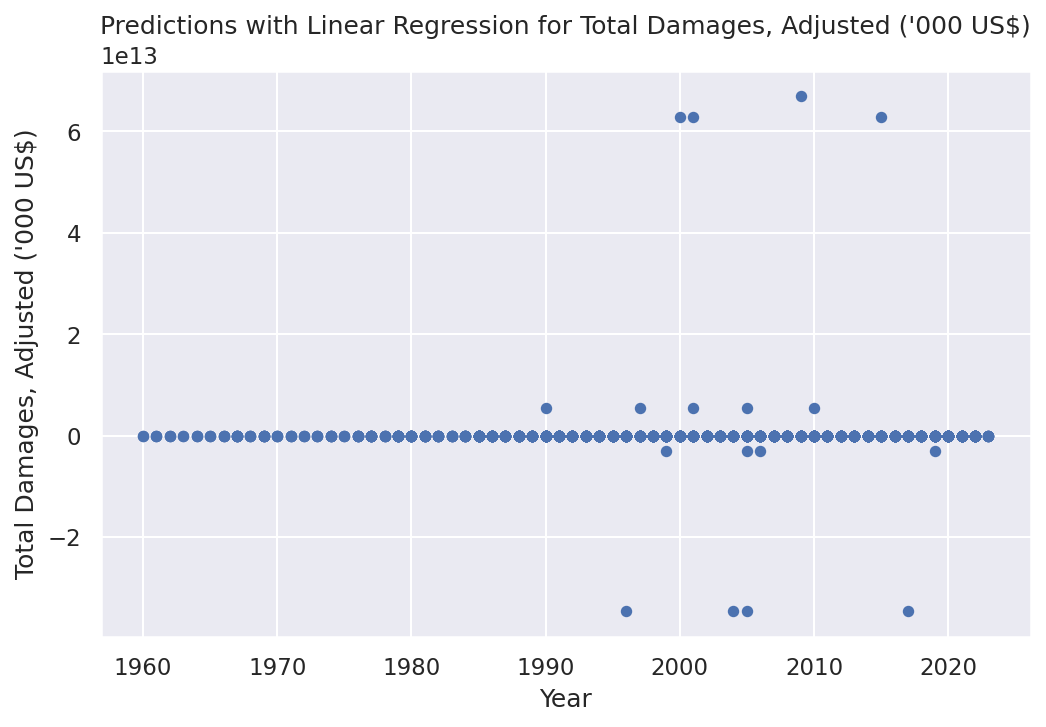

In [41]:
# visualize the predicted values with linear regression
years = data_imp.iloc[missing_index, :]['Year']
temp = pd.DataFrame(columns = ['Year', predict_var])
temp['Year'] = years
temp[predict_var] = missing_series_lm
temp.plot(kind='scatter', x='Year', y=predict_var)
plt.title(f'Predictions with Linear Regression for {predict_var}')
plt.show()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


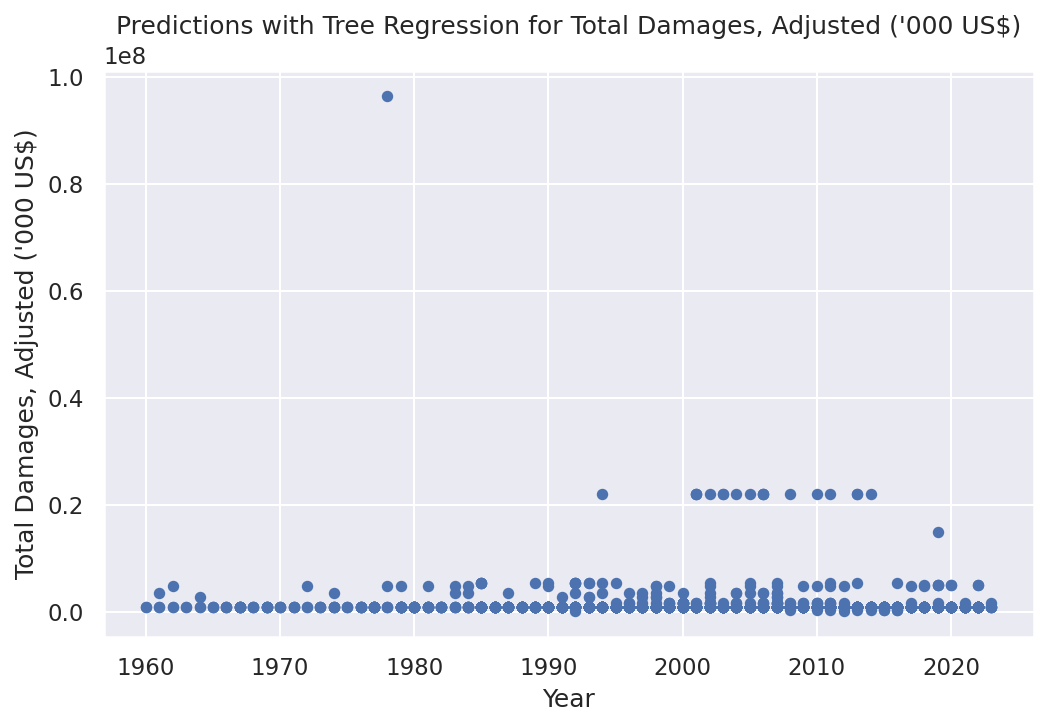

In [42]:
# visualize the predicted values with tree regression
temp = pd.DataFrame(columns = ['Year', predict_var])
temp['Year'] = years
temp[predict_var] = missing_series_dt
temp.plot(kind='scatter', x='Year', y=predict_var)
plt.title(f'Predictions with Tree Regression for {predict_var}')
plt.show()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


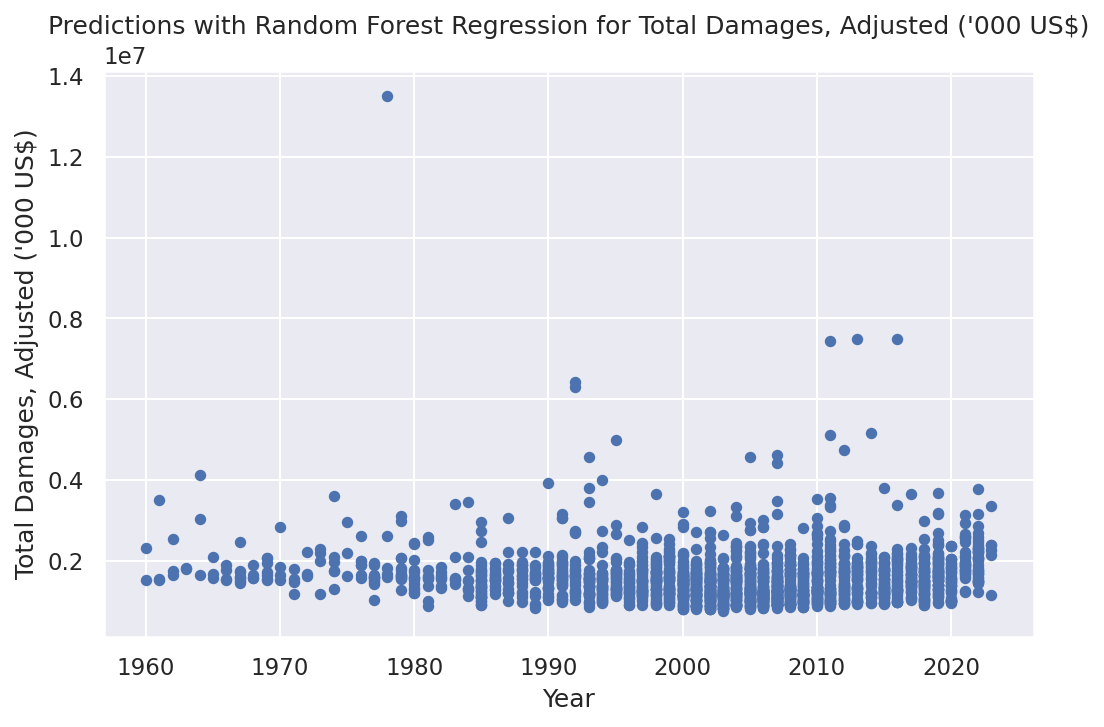

In [43]:
# visualize the predicted values with random forest regression
temp = pd.DataFrame(columns = ['Year', predict_var])
temp['Year'] = years
temp[predict_var] = missing_series_rf
temp.plot(kind='scatter', x='Year', y=predict_var)
plt.title(f'Predictions with Random Forest Regression for {predict_var}')
plt.show()

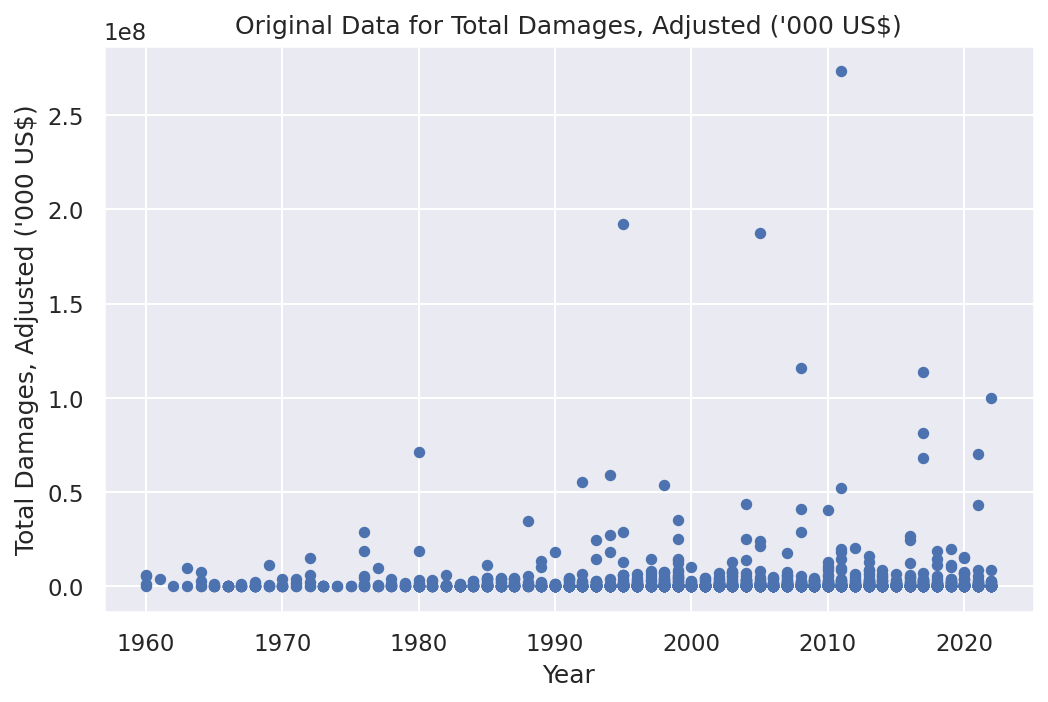

count    2.174000e+03
mean     1.838856e+06
std      1.048460e+07
min      2.000000e+00
25%      1.920425e+04
50%      1.329485e+05
75%      6.882890e+05
max      2.732184e+08
Name: Total Damages, Adjusted ('000 US$), dtype: float64

In [44]:
# visualize original data and it's statistical descriptions
data_imp.plot(kind='scatter', x='Year', y=predict_var)
plt.title(f'Original Data for {predict_var}')
plt.show()
data_imp[predict_var].describe()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


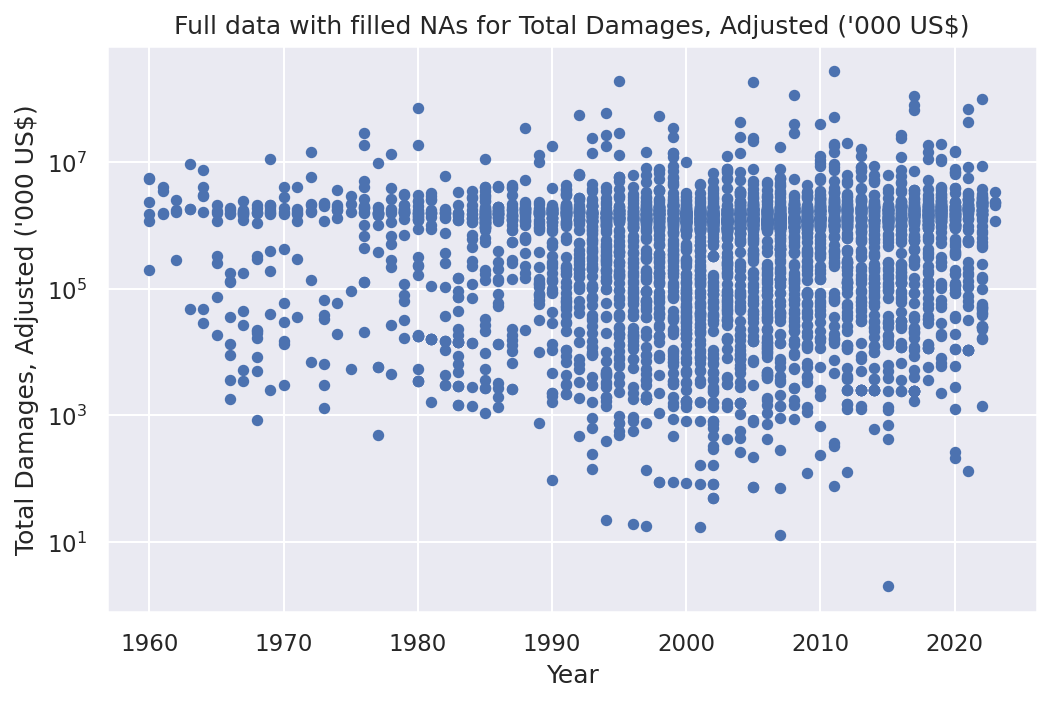

count    4.693000e+03
mean     1.686792e+06
std      7.150234e+06
min      2.000000e+00
25%      1.692060e+05
50%      1.183882e+06
75%      1.655237e+06
max      2.732184e+08
Name: Total Damages, Adjusted ('000 US$), dtype: float64

In [45]:
# fill in the missing values with one of the predictions (here Linear Regression) and visualize
data_imp[predict_var] = data_imp[predict_var].fillna(missing_series_rf)
data_imp.plot(kind='scatter', x='Year', y=predict_var, logy=True)
plt.title(f'Full data with filled NAs for {predict_var}')
plt.show()
data_imp[predict_var].describe()

In [46]:
print('Amount of negative valued predictions:')
print('- Linear Regression:', len(predictions_lm[predictions_lm < 0]))
print('- Tree Regression:', len(predictions_dt[predictions_dt < 0]))
print('- Random Forest Regression:', len(predictions_rf[predictions_rf < 0]))

Amount of negative valued predictions:
- Linear Regression: 499
- Tree Regression: 0
- Random Forest Regression: 0


In [47]:
# check how the data used for prediction looks like
# IDK if we want this
full_data.iloc[missing_index, :].set_index('Dis No').head(20)

Year   Seq Disaster Group Disaster Subgroup  \
Dis No                                                       
1960-0033-DZA  1960    33        Natural       Geophysical   
1961-0016-ETH  1961    16        Natural       Geophysical   
1962-0044-ALB  1962    44        Natural       Geophysical   
1962-0030-COL  1962    30        Natural       Geophysical   
1963-0055-BEL  1963    55        Natural    Meteorological   
1964-0016-AZO  1964    16        Natural       Geophysical   
1965-0093-IDN  1965    93        Natural       Geophysical   
1966-0110-CAN  1966   110        Natural    Meteorological   
1967-0101-IDN  1967   101        Natural       Geophysical   
1967-0131-FRA  1967   131        Natural       Geophysical   
1967-0102-IDN  1967   102        Natural       Geophysical   
1968-0064-IDN  1968    64        Natural       Geophysical   
1969-0082-CHN  1969    82        Natural       Geophysical   
1969-0052-IDN  1969    52        Natural       Geophysical   
1970-0010-CHN  1970    10        Natural       Geophysical   
1970-0112-IND  1970   112        Natural       Geophysical   
1971-0118-CAN  1971   118        Natural    Meteorological   
1973-0111-ECU  1973   111        Natural      Hydrological   
1974-9100-AUS  1974  9100        Natural    Climatological   
1974-0025-CHN  1974    25        Natural       Geophysical   

                     Disaster Type  Disaster Subtype    Disaster Subsubtype  \
Dis No                                                                        
1960-0033-DZA           Earthquake   Ground movement        Ground movement   
1961-0016-ETH           Earthquake   Ground movement        Ground movement   
1962-0044-ALB           Earthquake   Ground movement        Ground movement   
1962-0030-COL           Earthquake   Ground movement        Ground movement   
1963-0055-BEL  Extreme temperature         Cold wave              Cold wave   
1964-0016-AZO           Earthquake   Ground movement        Ground movement   
1965-0093-IDN           Earthquake   Ground movement        Ground movement   
1966-0110-CAN                Storm  Convective storm  Winter storm/Blizzard   
1967-0101-IDN           Earthquake   Ground movement        Ground movement   
1967-0131-FRA           Earthquake   Ground movement        Ground movement   
1967-0102-IDN           Earthquake   Ground movement        Ground movement   
1968-0064-IDN           Earthquake           Tsunami                Tsunami   
1969-0082-CHN           Earthquake   Ground movement        Ground movement   
1969-0052-IDN           Earthquake           Tsunami                Tsunami   
1970-0010-CHN           Earthquake   Ground movement        Ground movement   
1970-0112-IND           Earthquake   Ground movement        Ground movement   
1971-0118-CAN                Storm  Convective storm  Winter storm/Blizzard   
1973-0111-ECU                Flood             Flood                  Flood   
1974-9100-AUS              Drought           Drought                Drought   
1974-0025-CHN           Earthquake   Ground movement        Ground movement   

                      Country  ISO                     Region  ...  \
Dis No                                                         ...   
1960-0033-DZA         Algeria  DZA            Northern Africa  ...   
1961-0016-ETH        Ethiopia  ETH             Eastern Africa  ...   
1962-0044-ALB         Albania  ALB            Southern Europe  ...   
1962-0030-COL        Colombia  COL              South America  ...   
1963-0055-BEL         Belgium  BEL             Western Europe  ...   
1964-0016-AZO  Azores Islands  AZO            Southern Europe  ...   
1965-0093-IDN       Indonesia  IDN         South-Eastern Asia  ...   
1966-0110-CAN          Canada  CAN           Northern America  ...   
1967-0101-IDN       Indonesia  IDN         South-Eastern Asia  ...   
1967-0131-FRA          France  FRA             Western Europe  ...   
1967-0102-IDN       Indonesia  IDN         South-Eastern Asia  ...   
1

In [48]:
full_data[predict_var] = full_data[predict_var].fillna(missing_series_rf)

# make predictions for total deaths and total affected as well
predict_var = "Total Deaths"  # should match a column name from the dataset
_, _, predictions_rf = predict_nas(predict_var)
# create a missing series for each of the predictions
missing_index = full_data[predict_var][full_data[predict_var].isnull()].index
missing_series_rf = pd.Series(data = predictions_rf, index = missing_index)
# fill values
full_data[predict_var] = full_data[predict_var].fillna(missing_series_rf)

predict_var = "Total Affected"
_, _, predictions_rf = predict_nas(predict_var)
# create a missing series for each of the predictions
missing_index = full_data[predict_var][full_data[predict_var].isnull()].index
missing_series_rf = pd.Series(data = predictions_rf, index = missing_index)
# fill values
full_data[predict_var] = full_data[predict_var].fillna(missing_series_rf)


In [49]:
# checking for remaining features with missing values
full_data.columns[full_data.isnull().any()].tolist()

["Total Damages ('000 US$)"]

**CONCLUSIONS**

We managed to predict the values needed for our analysis using the 3 techniques, however, in linear regression, negative values showed in the predicted outcomes. Therefore we will not use this in the next sections but rather use the predictions from the random forest regression.

## Visualizations

After handling missing values and the dropping some of the features to reduce dimensionality, we will now inspect our data closer using visualizations. 



First, we start with visualizing the data for the whole world (all records), and we will be inspecting:

I) Total Deaths

II) Total Affceted

III) Total damaged (adjusted using CPI)

IV) Frequency of disaster occurence

**Plotting World Maps**

In [50]:
def get_world_data(data_set):
    # plotting a world map
    country_data = data_set.copy(deep = True)
    country_groups = country_data.groupby(by=['ISO']).size().reset_index(name ='disaster_freq')      # returns dataframe
    country_groups.rename(columns={"ISO": "iso_a3"}, inplace = True)

    # plotting a world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world.merge(country_groups,how='left', on=['iso_a3'])


    country_data = data.copy(deep = True)
    country_severity = country_data.groupby(by=['ISO'])[["Total Deaths", "Total Affected", "Total Damages, Adjusted ('000 US$)"]]\
        .sum().reset_index()      # returns dataframe
    country_severity.rename(columns={"ISO": "iso_a3"}, inplace = True)
    world = world.merge(country_severity,how='left', on=['iso_a3'])

    return world


def plot_world_map(world):
    # plotting the world maps
    fig, ax = plt.subplots(2, 2, figsize = (12,7))
    #world['disaster_req'] = country_groups
    # plotting frequency by country
    world.plot(column='Total Deaths', cmap = 'Reds', legend = True, ax = ax[0,0])
    ax[0,0].set_title('Total Deaths per country')

    world.plot(column='Total Affected', cmap = 'Reds', legend = True, ax = ax[1,0])
    ax[1,0].set_title('Total Affected People per country')

    world.plot(column="Total Damages, Adjusted ('000 US$)", cmap = 'Reds', legend = True, ax = ax[0,1])
    ax[0,1].set_title('Total monetary Damages per country')

    # plotting frequency by country
    world.plot(column='disaster_freq', cmap = 'Reds', legend = True, ax = ax[1,1])
    ax[1,1].set_title('Disaster frequency per country')

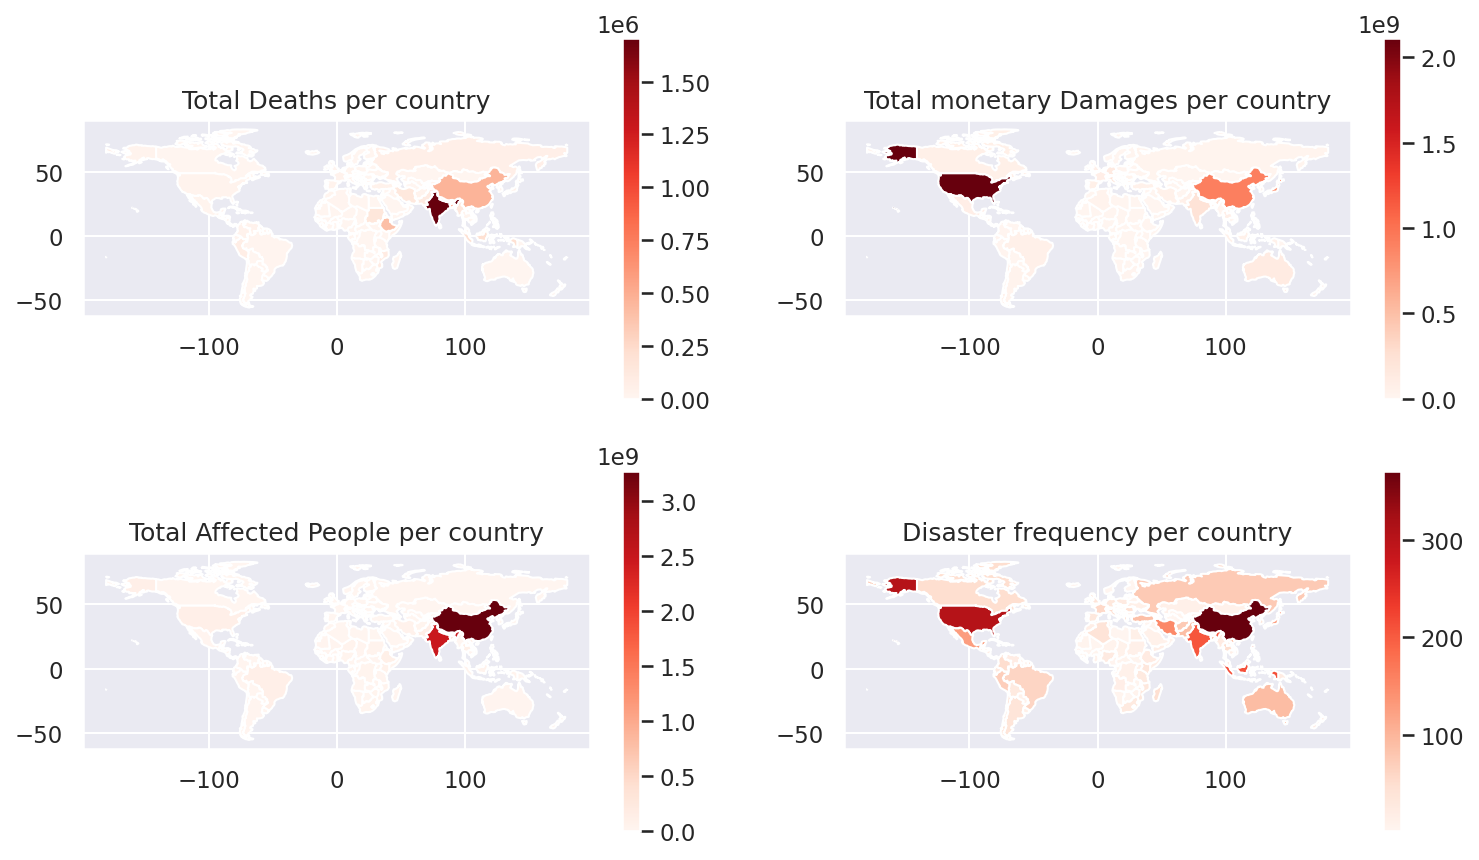

In [51]:
# plotting the data on a map view

world_data = get_world_data(full_data)
plot_world_map(world_data)

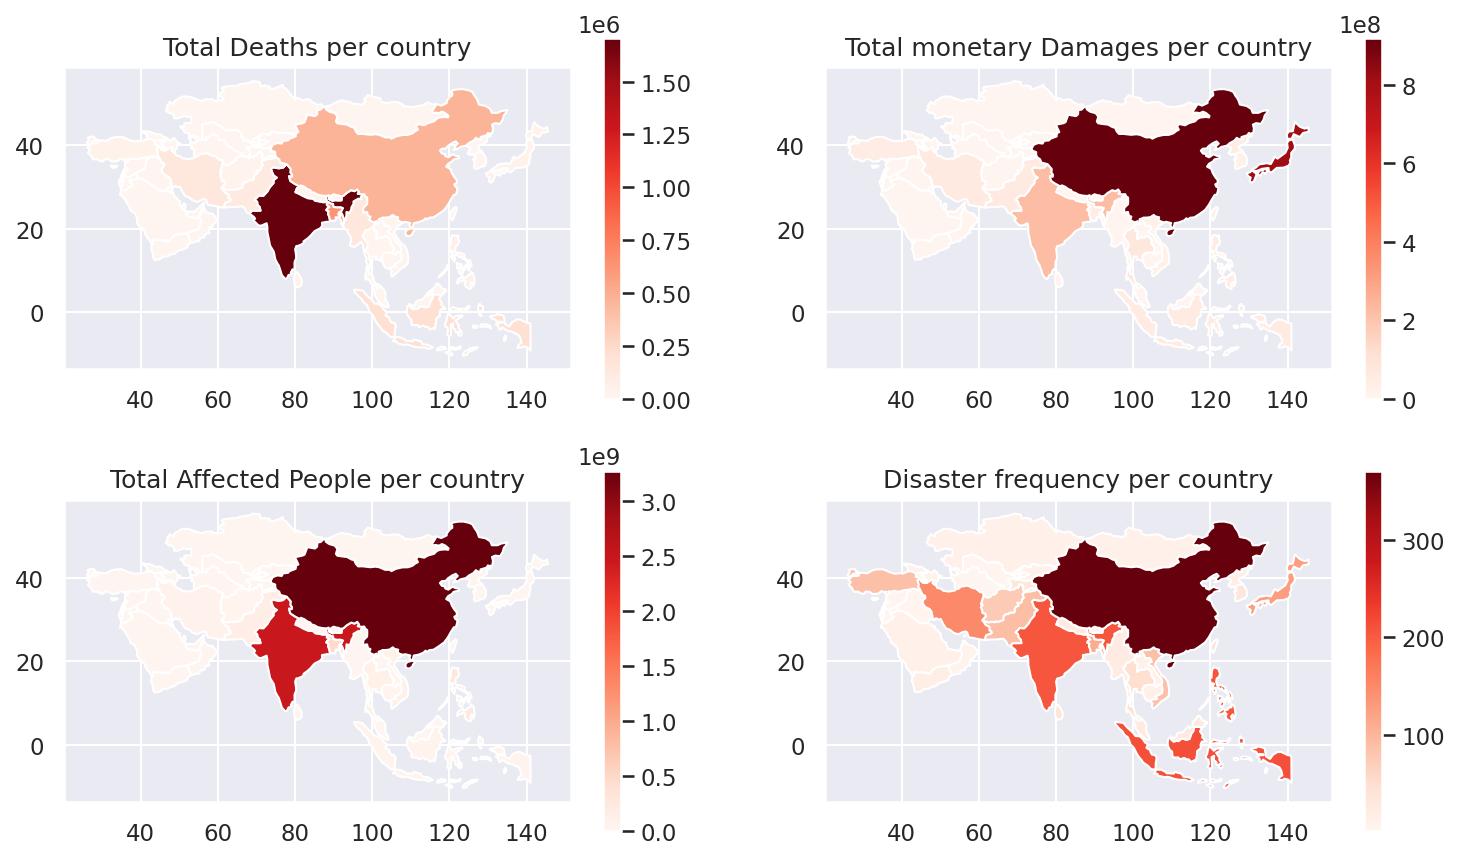

In [52]:
# Plotting only data for Asia
plot_world_map(world_data[world_data["continent"] == "Asia"])

In [53]:
# creating dataframes for timeseries (monthly)
timeseries_data = full_data.groupby(['Year', 'Start Month']).size().reset_index().rename(columns={0:'Count'})
timeseries_data = timeseries_data[timeseries_data['Start Month']!=0]

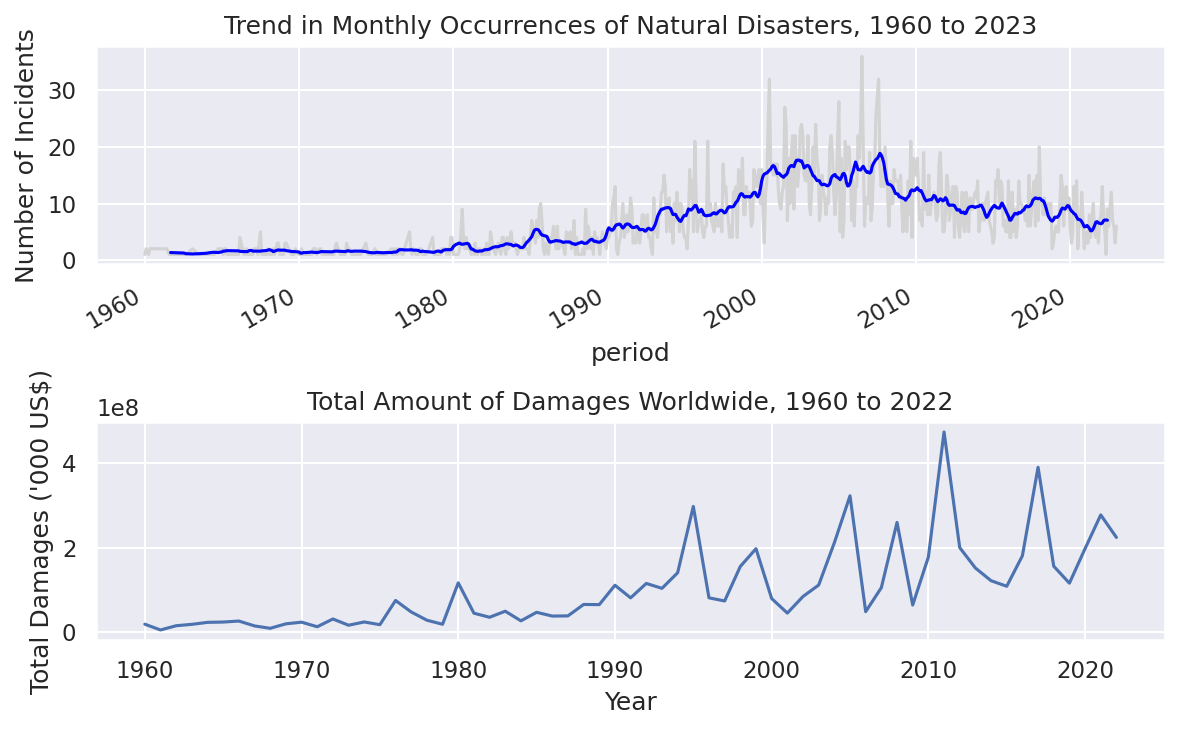

In [54]:
#formatting dates to be datetime
timeseries_data['period'] = timeseries_data['Year'].astype(str) + '-' + timeseries_data['Start Month'].astype(int).astype(str) + '-01'
timeseries_data['period'] = pd.to_datetime(timeseries_data['period'])
#timeseries_data['mov_avg'] = timeseries_data['period'].rolling(7).sum()

decomp_frequency = 12 # seasonality for yearly model
decomp = seasonal_decompose(
    timeseries_data.set_index("period").Count.interpolate("linear"),
    period = decomp_frequency,
    model = "additive")

trend = decomp.trend

fig3, ax3 = plt.subplots(2)

timeseries_data.plot(x="period", y="Count", ax = ax3[0], legend=False, c = 'lightgrey')
trend.plot(ax=ax3[0], label = 'trend', color = 'blue')
ax3[0].set_ylabel('Number of Incidents')
ax3[0].set_title('Trend in Monthly Occurrences of Natural Disasters, 1960 to 2023')



# filter out 2023 and group by year
total_damages_by_year = data[data['Year'] != 2023].groupby('Year')['Total Damages, Adjusted (\'000 US$)'].sum()

# plot total damages by year
ax3[1].plot(total_damages_by_year.index, total_damages_by_year)
#plt.hist(total_damages_by_year)

ax3[1].set_xlabel('Year')
ax3[1].set_ylabel('Total Damages (\'000 US$)')
ax3[1].set_title('Total Amount of Damages Worldwide, 1960 to 2022')

fig3.tight_layout(pad=1.0)

plt.show()

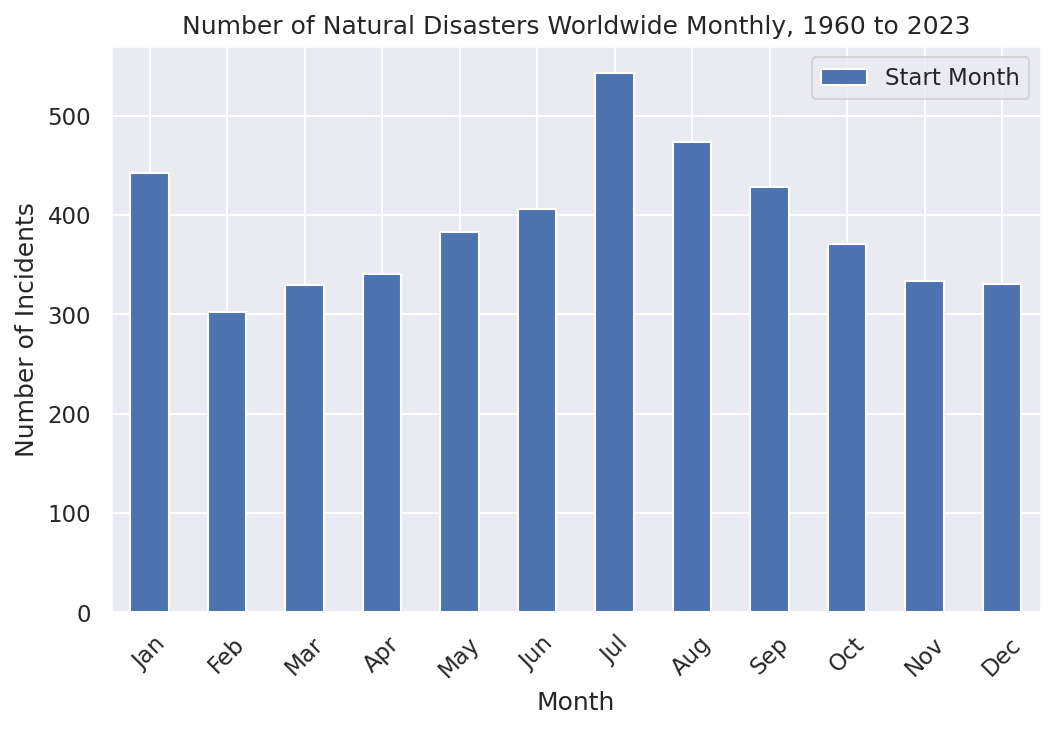

In [55]:
monthly_disaster_occurrences = pd.DataFrame(full_data[(full_data['Start Month'] != 0)]['Start Month'].value_counts()).sort_index()
monthly_disaster_occurrences.plot(kind = 'bar', label = 'Disaster occurence')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# labeling and legend (old: Trend in Monthly Total Occurrences of Natural Disasters, 1960 to 2023)
plt.title('Number of Natural Disasters Worldwide Monthly, 1960 to 2023')
plt.xlabel('Month')
plt.xticks(np.arange(0,12), months, rotation=45)
plt.ylabel('Number of Incidents')
plt.show()

**Analyze data per Continent**

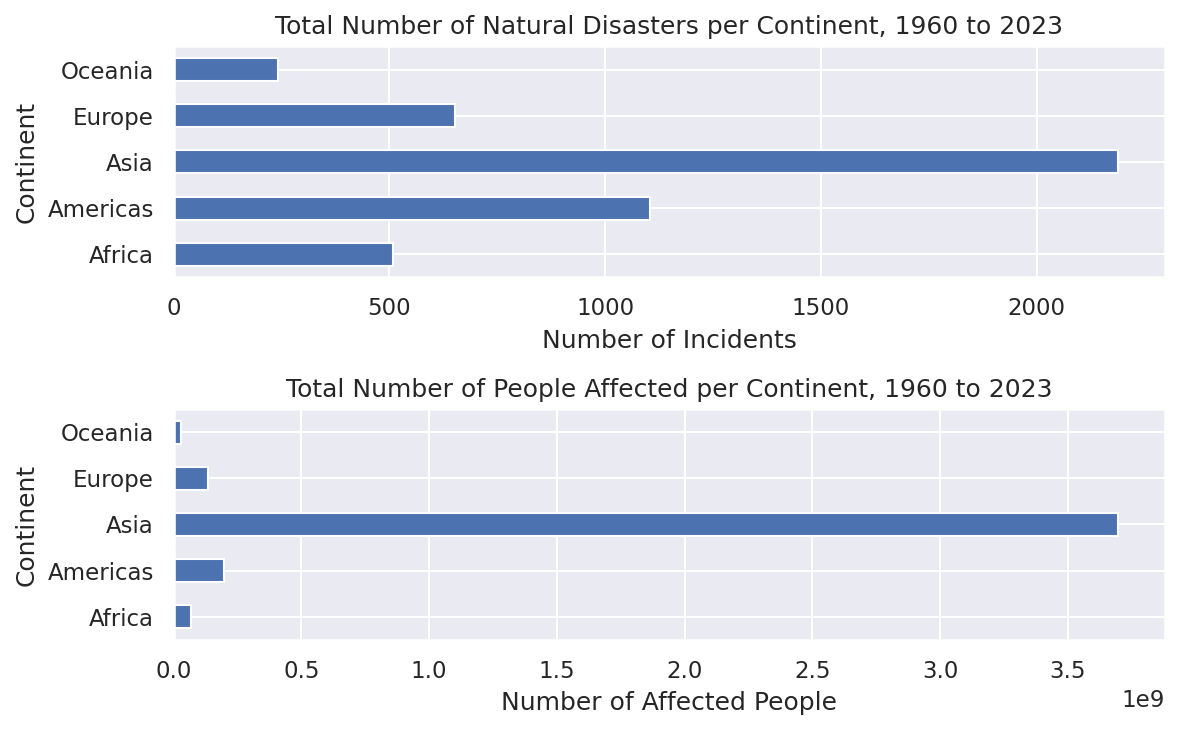

In [56]:
# ANALYSIS BY CONTINENT

fig2, ax2 = plt.subplots(2)

# disaster occurence
continent_occurrences = full_data.groupby(by=['Continent']).size().reset_index().rename(columns={0:'Occurrences'})
continent_occurrences.plot(kind="barh",x='Continent', y='Occurrences', legend=False, ax = ax2[0])
ax2[0].set_title('Total Number of Natural Disasters per Continent, 1960 to 2023')
ax2[0].set_xlabel('Number of Incidents')

# number affected people
continent_affected = full_data.groupby(by=['Continent']).agg({'Total Affected': np.sum})
continent_affected.plot(kind="barh", y='Total Affected', legend=False, ax = ax2[1])
ax2[1].set_title('Total Number of People Affected per Continent, 1960 to 2023')
ax2[1].set_xlabel('Number of Affected People')

fig2.tight_layout(pad=1.0)
plt.show()

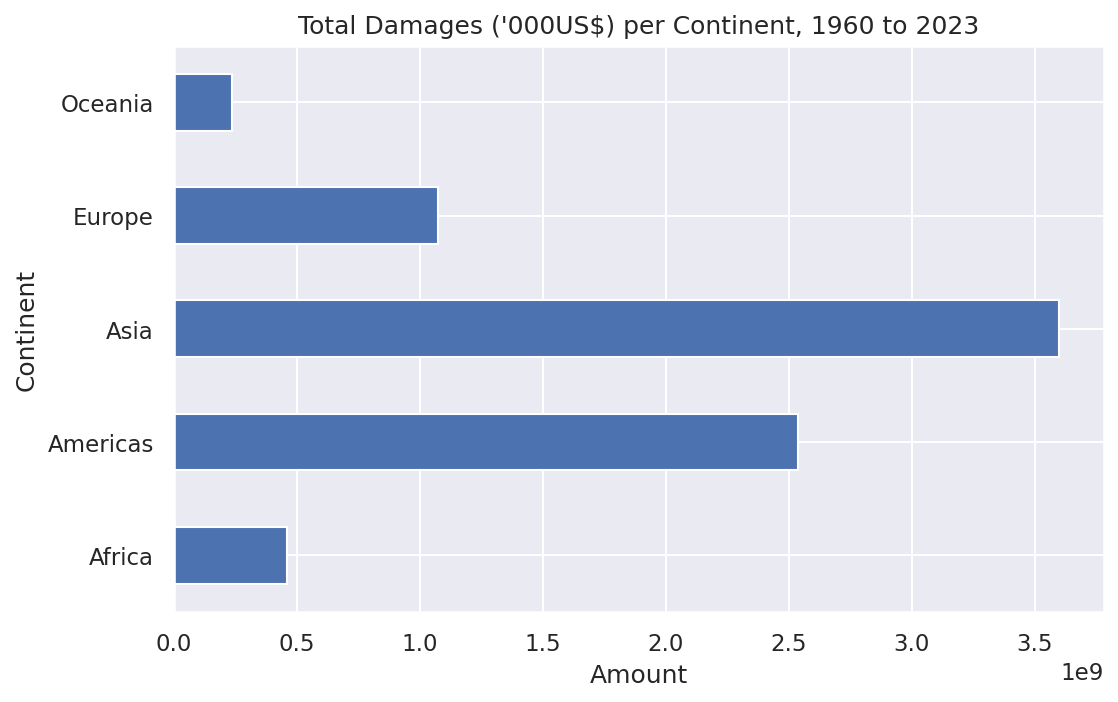

In [57]:
# This is probably biased???
continent_damages = full_data[full_data["Total Damages, Adjusted ('000 US$)"] > 0].groupby(by=['Continent']).agg({"Total Damages, Adjusted ('000 US$)": np.sum})
continent_damages.plot(kind="barh", y="Total Damages, Adjusted ('000 US$)", legend=False)
plt.title("Total Damages ('000US$) per Continent, 1960 to 2023")
plt.xlabel('Amount')
plt.show()

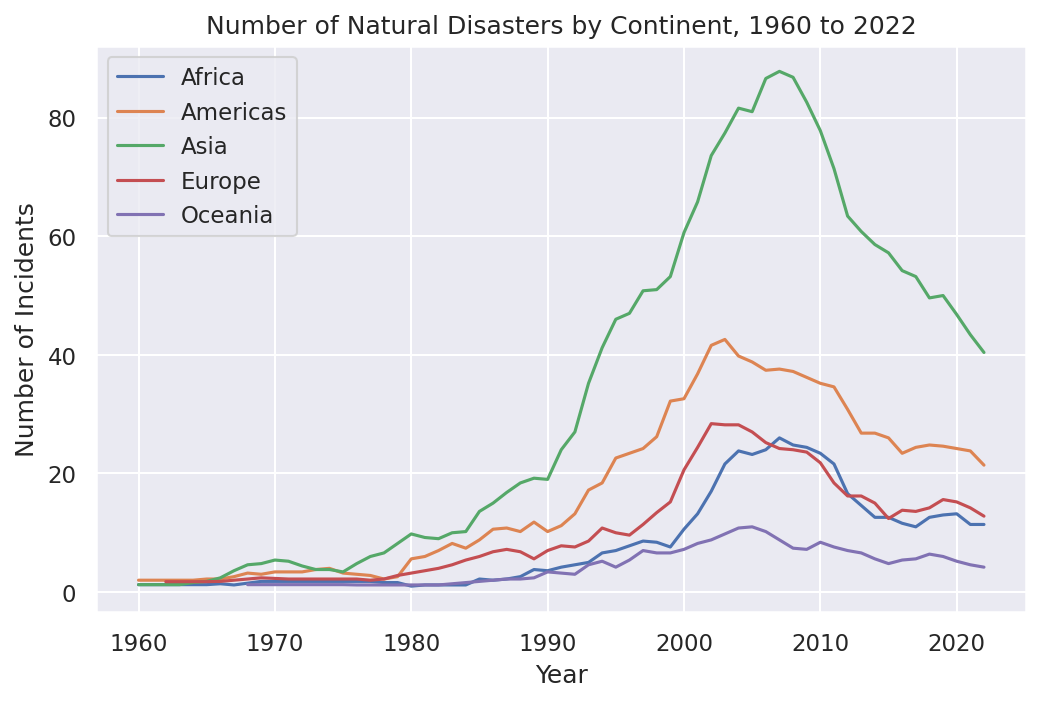

In [58]:
# TREND ANALYSIS BY CONTINENT

yearly_trend_continents = full_data.groupby(['Continent', 'Year']).size().reset_index().rename(columns={0:'Count'})
yearly_trend_continents = yearly_trend_continents[yearly_trend_continents['Year'] != 2023]

continents = yearly_trend_continents['Continent'].unique()
smooth_window = 5
# plot the lines separately for each continent
for continent in continents:
    continent_data = yearly_trend_continents[yearly_trend_continents['Continent'] == continent].copy(deep=True)  # deep copy to avoid warnings
    smooth = continent_data["Count"].rolling(window = smooth_window, center = False).mean()
    smooth = smooth.fillna(continent_data.head(smooth_window-1)["Count"].mean())  # fill the nans with the average of the data from those indices
    continent_data['smooth'] = smooth
    sns.lineplot(data=continent_data, x='Year', y='smooth', label=continent, linewidth=1.5)

# labeling and legend 
plt.title('Number of Natural Disasters by Continent, 1960 to 2022')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

**Comparison by disaster type**
We will investigate the Disaster types and occurences worldwide and for one country (Indonesia).

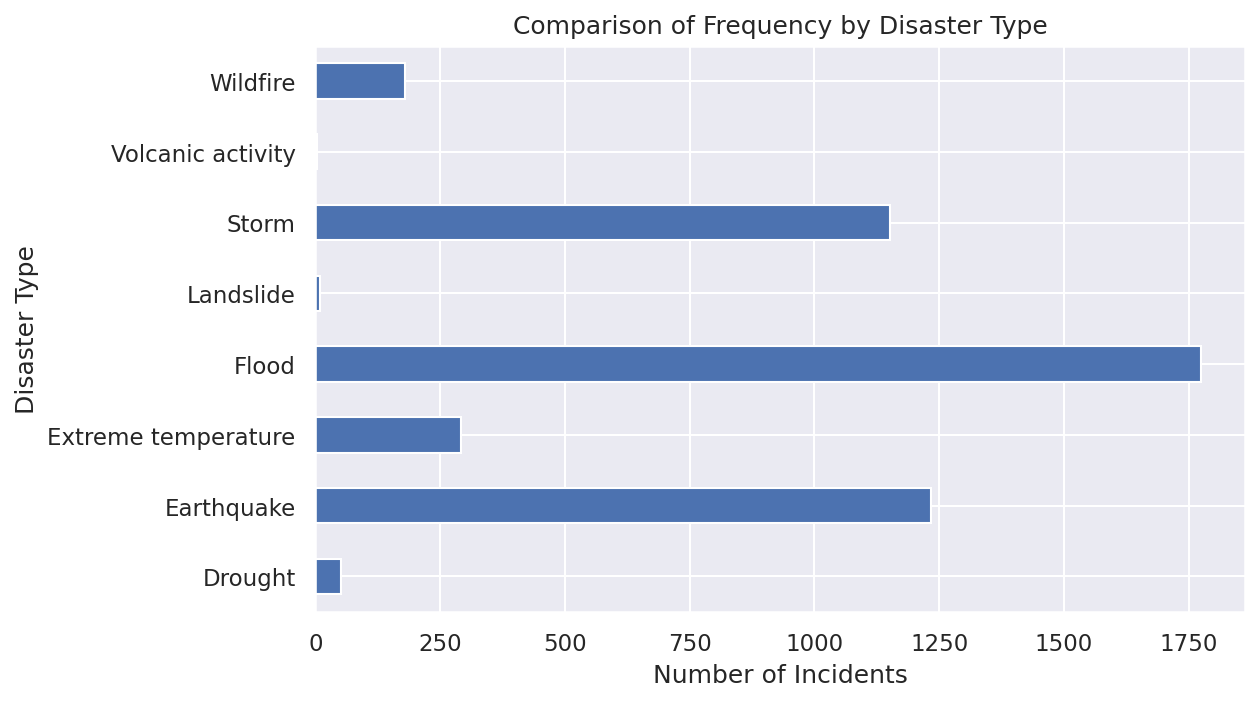

In [59]:
disaster_occurrences = pd.DataFrame(full_data['Disaster Type'].value_counts()).sort_index()
disaster_occurrences.plot(kind='barh', legend=False)
plt.title('Comparison of Frequency by Disaster Type')
plt.xlabel('Number of Incidents')
plt.ylabel('Disaster Type')
plt.show()

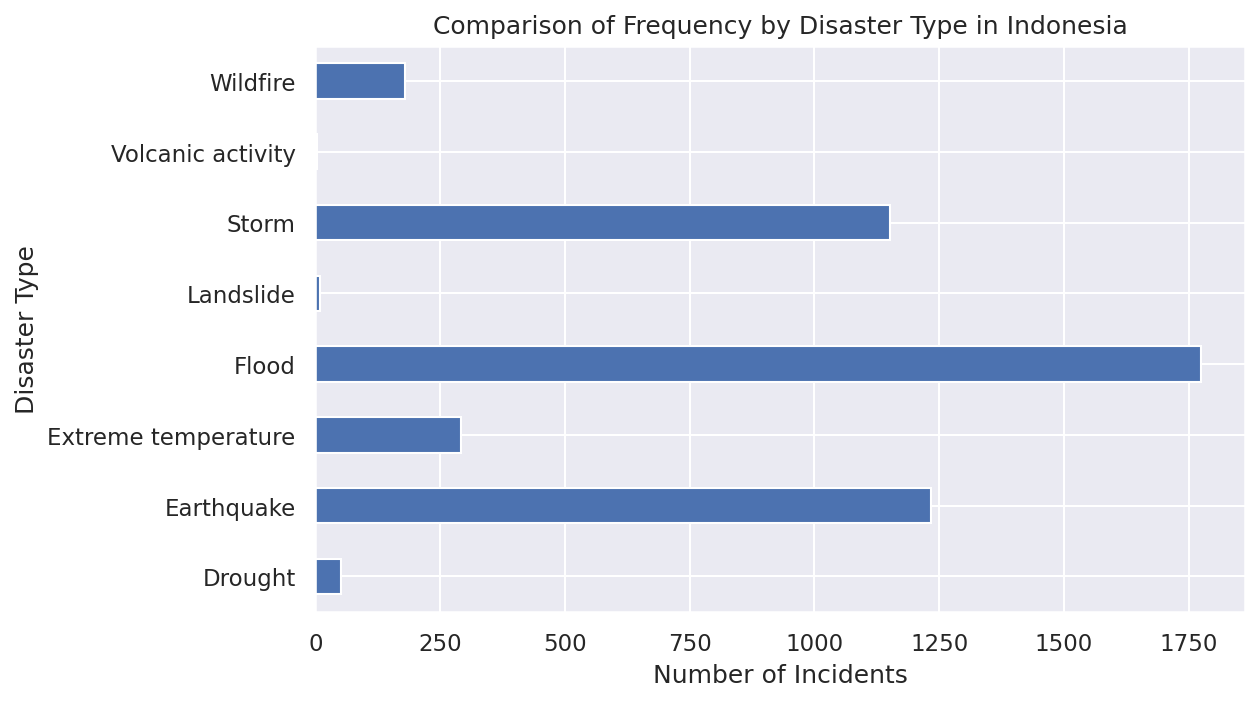

In [60]:
ind = full_data[full_data["Country"] == "Indonesia"]
disaster_ind = pd.DataFrame(ind['Disaster Type'].value_counts()).sort_index()
disaster_occurrences.plot(kind='barh', legend=False)
plt.title('Comparison of Frequency by Disaster Type in Indonesia')
plt.xlabel('Number of Incidents')
plt.ylabel('Disaster Type')
plt.show()

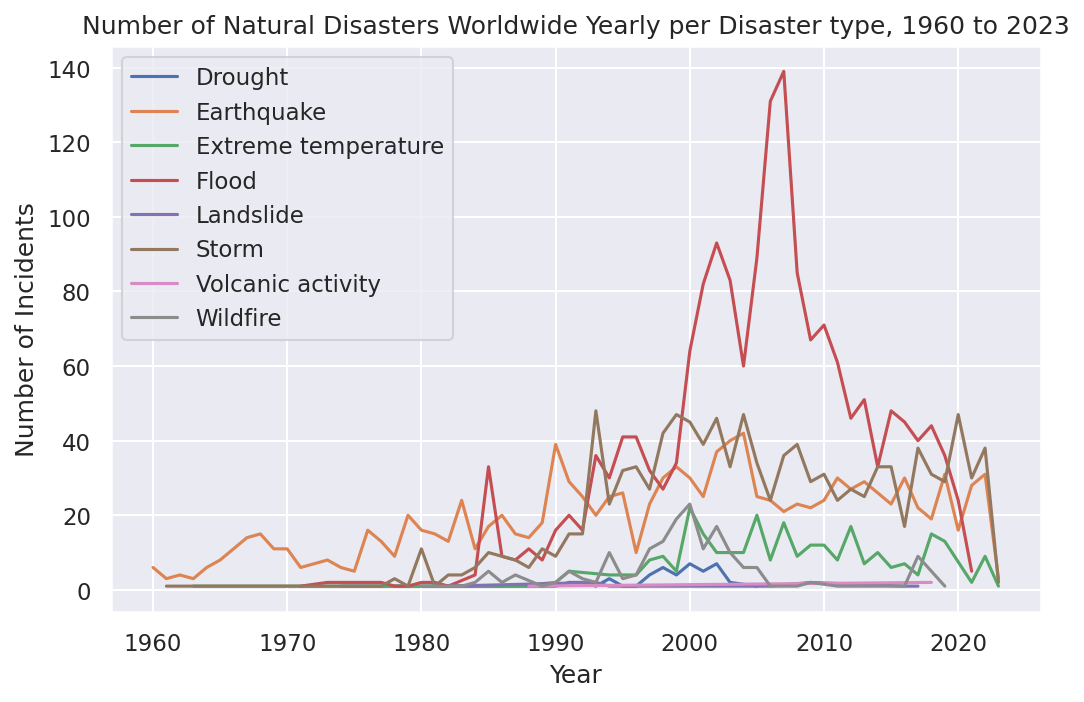

In [61]:
yearly_disaster_occurrences = full_data.groupby(['Disaster Type', 'Year']).size().reset_index().rename(columns={0:'Count'})

disaster_types = yearly_disaster_occurrences['Disaster Type'].unique()

# plot the lines separately for each continent
for disaster in disaster_types:
    disaster_data = yearly_disaster_occurrences[yearly_disaster_occurrences['Disaster Type'] == disaster]
    sns.lineplot(data=disaster_data, x='Year', y='Count', label=disaster, linewidth=1.5)

# labeling and legend 
plt.title('Number of Natural Disasters Worldwide Yearly per Disaster type, 1960 to 2023')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

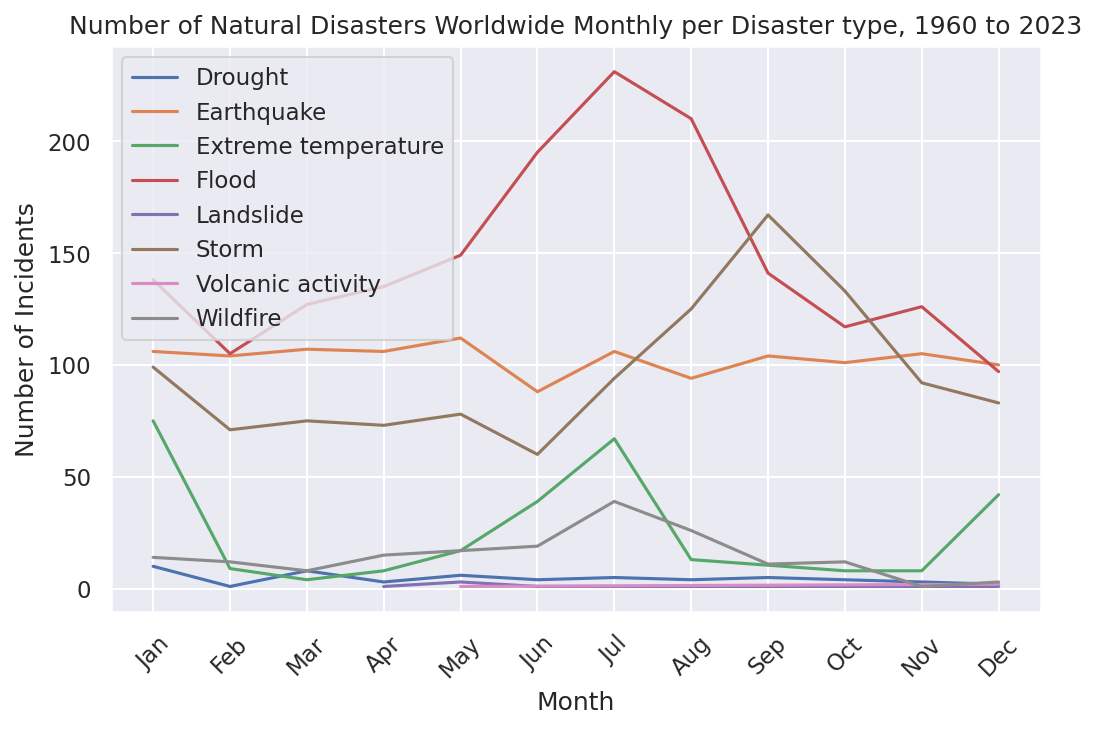

In [62]:
relevant_data = full_data[full_data['Start Month'] != 0]
monthly_disaster_occurrences = relevant_data.groupby(['Disaster Type', 'Start Month']).size().reset_index().rename(columns={0:'Count'})

disaster_types = monthly_disaster_occurrences['Disaster Type'].unique()

# plot the lines separately for each continent
for disaster in disaster_types:
    disaster_data = monthly_disaster_occurrences[monthly_disaster_occurrences['Disaster Type'] == disaster]
    sns.lineplot(data=disaster_data, x='Start Month', y='Count', label=disaster, linewidth=1.5)

# labeling and legend 
plt.title('Number of Natural Disasters Worldwide Monthly per Disaster type, 1960 to 2023')
plt.xlabel('Month')
plt.xticks(np.arange(1,13), months, rotation=45)
plt.ylabel('Number of Incidents')
plt.show()

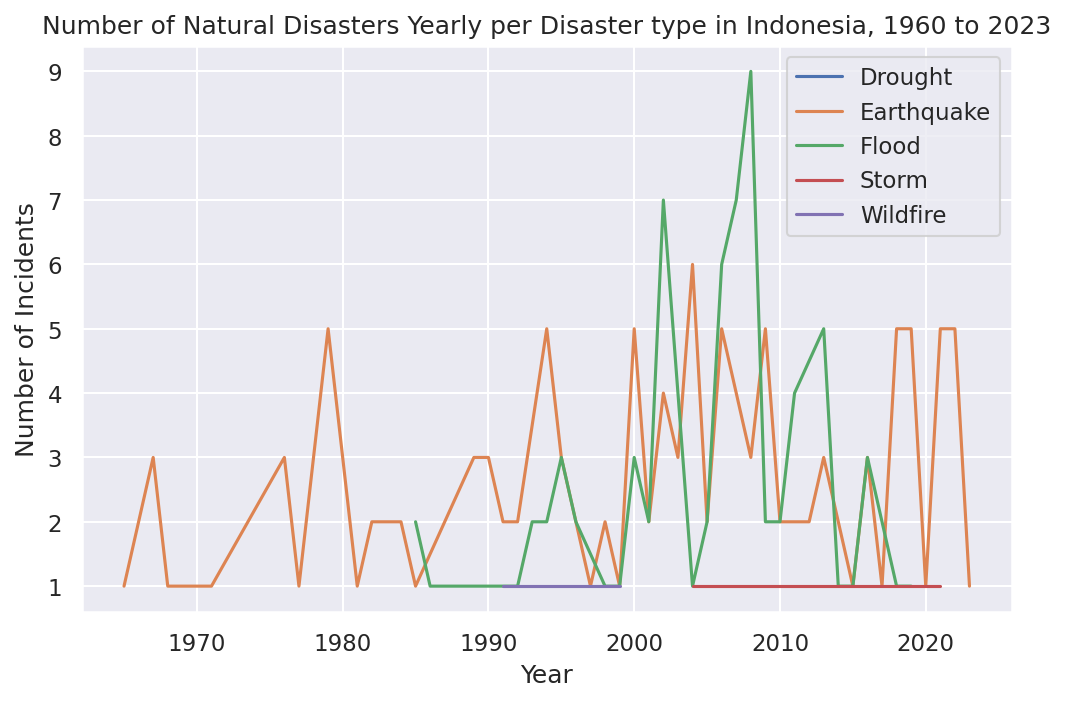

In [63]:
ind = full_data[full_data["Country"] == "Indonesia"]
monthly_disaster_occurrences = ind.groupby(['Disaster Type', 'Year']).size().reset_index().rename(columns={0:'Count'})

disaster_types = monthly_disaster_occurrences['Disaster Type'].unique()

# plot the lines separately for each continent
for disaster in disaster_types:
    disaster_data = monthly_disaster_occurrences[monthly_disaster_occurrences['Disaster Type'] == disaster]
    sns.lineplot(data=disaster_data, x='Year', y='Count', label=disaster, linewidth=1.5)

# labeling and legend 
plt.title('Number of Natural Disasters Yearly per Disaster type in Indonesia, 1960 to 2023')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

In the analyzed time frame, from the map plot, we can see that the countries with the most  deaths (India, China and Ethiopia) and the ones with the most affected people (China, and India) are very similar. Furthermore, for disaster occurrences, the countries with most entries are the USA, China, India, and Indonesia, and for most monetary damages, the US and China have much larger records than the other countries.

When inspecting the different continents, Asia has both the largest number of occurrences, and affected people, which is very likely to be due to the fact that it has the largest population, and a very special geographical location. For the second most affect continent, Africa has the most affected people (likely to a larger population size than the other continents) and America has a higher number of disaster occurrences (potentially due to more recordings, or geographical location). For monetary damages, America has the largest record, again, potential due to more recordings.

For the trend analysis, we can see that for all continents (and worldwide) the number of natural disasters increased over the past 60 years. This could however also stem from a lack of records in the early years of the data recordings. This trend can also be seen for the amount of damages that were recorded, which could additionally also come from an increased value in damaged properties.

As for the disaster type, Storms and floods are the most recorded ones, followed by earthquakes.

Inspecting the disaster types for an individual country shows a different distribution, which will clearly vary for each individual country, and it can also be seen that the curve jumps up and down much more often, which was to be expected, since the world plot is created with much more data from different geo locations and therefore displays more of an average value.

**Analyzing countries**

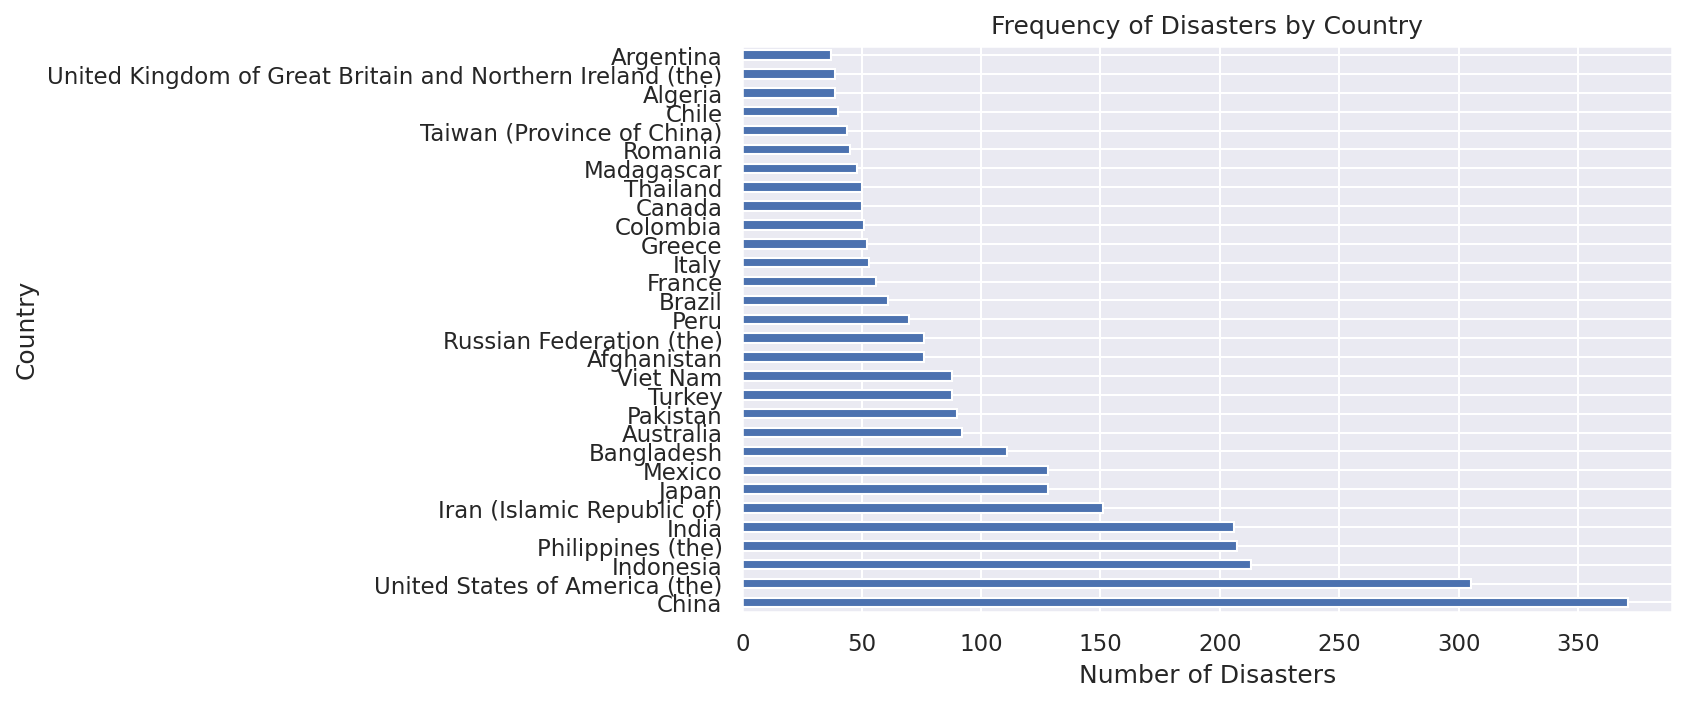

In [64]:
# TOP 30 COUNTRIES
disasters_by_country = pd.DataFrame(full_data['Country'].value_counts())
disasters_by_country.iloc[:30].plot(kind='barh', legend=False)
plt.title('Frequency of Disasters by Country')
plt.xlabel('Number of Disasters')
plt.ylabel('Country')
plt.show()

## **Prediction: Time Series Analysis**

*Forecasting:*

- Amount of Natural Disatsers
- Total Damages
- Total Affected
- Total Deaths

**Prophet Model**

In [65]:
def plot_prophet(model, model_fc):
    model.plot(model_fc)
    model.plot_components(model_fc)
    plt.show()
  

def get_prophet_univariate(train_data, test_data, predict_p):
    # uni-variate model
    model = Prophet()  # initiating prophet using the default parameters
    model.fit(train_data)
    future_model = model.make_future_dataframe(periods=len(test_data)+predict_p, freq = "Y")

    model_forecast = model.predict(future_model)

    plot_prophet(model, model_forecast)

    univar_mae = mean_absolute_error(test_data['y'], model_forecast[['yhat']][len(train_data)+1:len(train_data)+1+len(test_data)])
    print(f'The univariate MAE is : {univar_mae}')


**SARIMAX Model**

In [66]:
# https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8
def get_sarimax_model(train, test, predict_p, name):
    train_data = np.array(train['y'], dtype=float)
    sarimax_model_fit = sarimax_best_model(train_data)
    print(sarimax_model_fit)
    fc = sarimax_model_fit.predict(start=0, end=len(test.index)+predict_p)
    plot_sarimax(train, test, fc, predict_p+1, name)
    univar_mae = mean_absolute_error(test.y, fc[:][:len(test)])
    print(f'The univariate MAE is : {univar_mae}')


def sarimax_best_model(train_data):
    # parameter ranges
    p, d, q = range(0, 3), [1], range(0, 3)
    P, D, Q, s = range(0, 3), [1], range(0, 3), [7]

    param_pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    param_list = list(itertools.product(param_pdq, seasonal_pdq))

    model_list = []

    for param in param_list:
        try:
            sari_mod = SARIMAX(train_data, order=param[0], seasonal_order=param[1])
            fitted_sarimax = sari_mod.fit(disp=False)
            model_list.append((fitted_sarimax, fitted_sarimax.aic, param))

        except:
            continue
    print(model_list[0])
    # first entry in list has the lowest AIC value, is the assumed to be the best model
    best_model_df = pd.DataFrame(model_list, columns=['fitted_model', 'aic', 'param']).sort_values(by=['aic'], ascending=True)
    best_model_param = best_model_df.iloc[0].param
    best_model = SARIMAX(train_data, order=best_model_param[0], seasonal_order=best_model_param[1])
    return best_model.fit(disp=False)


def plot_sarimax(train, test, fc, p, name):
    plt.figure(figsize=(8, 5))

    # plotting actual index data
    plt.plot(train.ds, train.y, label="training data")
    plt.plot(test.ds, test.y, label="testing data")

    dates = pd.to_datetime(dict(year=range(test['ds'].iloc[-1].year + 1, test['ds'].iloc[-1].year + 1 + p), month=[1]*p, day=[1]*p))
    # plotting forecasted data
    plt.plot(np.concatenate((test.ds.to_numpy(), dates.to_numpy()), axis = 0 ), fc, label="forecast", color = 'green')

    plt.legend(loc='best')
    plt.title("Forecasting Natural Disasters " + name)
    plt.show()

Retrieve the data used for TS predicitons

In [67]:
def get_train_test_for_ts(data_set, country_name, feature_name):
    data_cnt = data_set[data_set['Country'] == country_name]
    timeseries_data = data_cnt.groupby(['Year']).size().reset_index().rename(columns={0:'Count'})
    data_yrs = data_cnt.groupby(by=['Year']).sum(numeric_only = True).reset_index()
    data_yrs['Count'] = timeseries_data['Count']
    data_yrs = data_yrs[data_yrs['Year'] != 2023]
    data_yrs['ds'] = pd.to_datetime(dict(year=data_yrs['Year'], month=[1]*len(data_yrs), day=[1]*len(data_yrs)))

    data_yrs_pred = data_yrs[['ds', feature_name]] 
    data_yrs_pred.sort_values
    data_yrs_pred.columns = ['ds', 'y'] 
    train_split_index = int (len(data_yrs_pred) * 0.8)
    train_yrs = data_yrs_pred.iloc[:train_split_index, :]
    test_yrs = data_yrs_pred.iloc[train_split_index : , :]

    return test_yrs, train_yrs


def get_train_test_for_ts_all(data_set, feature_name):
    timeseries_data = data_set.groupby(['Year']).size().reset_index().rename(columns={0:'Count'})
    data_yrs = data_set.groupby(by=['Year']).sum(numeric_only = True).reset_index()
    data_yrs['Count'] = timeseries_data['Count']
    data_yrs = data_yrs[data_yrs['Year'] != 2023]
    data_yrs['ds'] = pd.to_datetime(dict(year=data_yrs['Year'], month=[1]*len(data_yrs), day=[1]*len(data_yrs)))

    data_yrs_pred = data_yrs[['ds', feature_name]] 
    data_yrs_pred.sort_values
    data_yrs_pred.columns = ['ds', 'y'] 
    train_split_index = int (len(data_yrs_pred) * 0.8)
    train_yrs = data_yrs_pred.iloc[:train_split_index, :]
    test_yrs = data_yrs_pred.iloc[train_split_index : , :]

    return test_yrs, train_yrs

In [68]:
def plot_ts_indonesia_world(data_set, feature, periods):
    # one country: indonesia
    test_aff, train_aff = get_train_test_for_ts(data_set, 'Indonesia', feature)
    get_prophet_univariate(train_aff[['ds', 'y']], test_aff[['ds', 'y']], periods)
    get_sarimax_model(train_aff, test_aff, periods, feature + " Indonesia")

    # whole world
    test_all_cnt, train_all_cnt = get_train_test_for_ts_all(data_set, feature)
    get_prophet_univariate(train_all_cnt[['ds', 'y']], test_all_cnt[['ds', 'y']], periods)
    get_sarimax_model(train_all_cnt, test_all_cnt, periods, feature + " Worldwide")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/sx5wpuww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/n3j4kmwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87003', 'data', 'file=/tmp/tmpvuhzj6lw/sx5wpuww.json', 'init=/tmp/tmpvuhzj6lw/n3j4kmwz.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_modelisum9qi0/prophet_model-20230328105837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:58:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


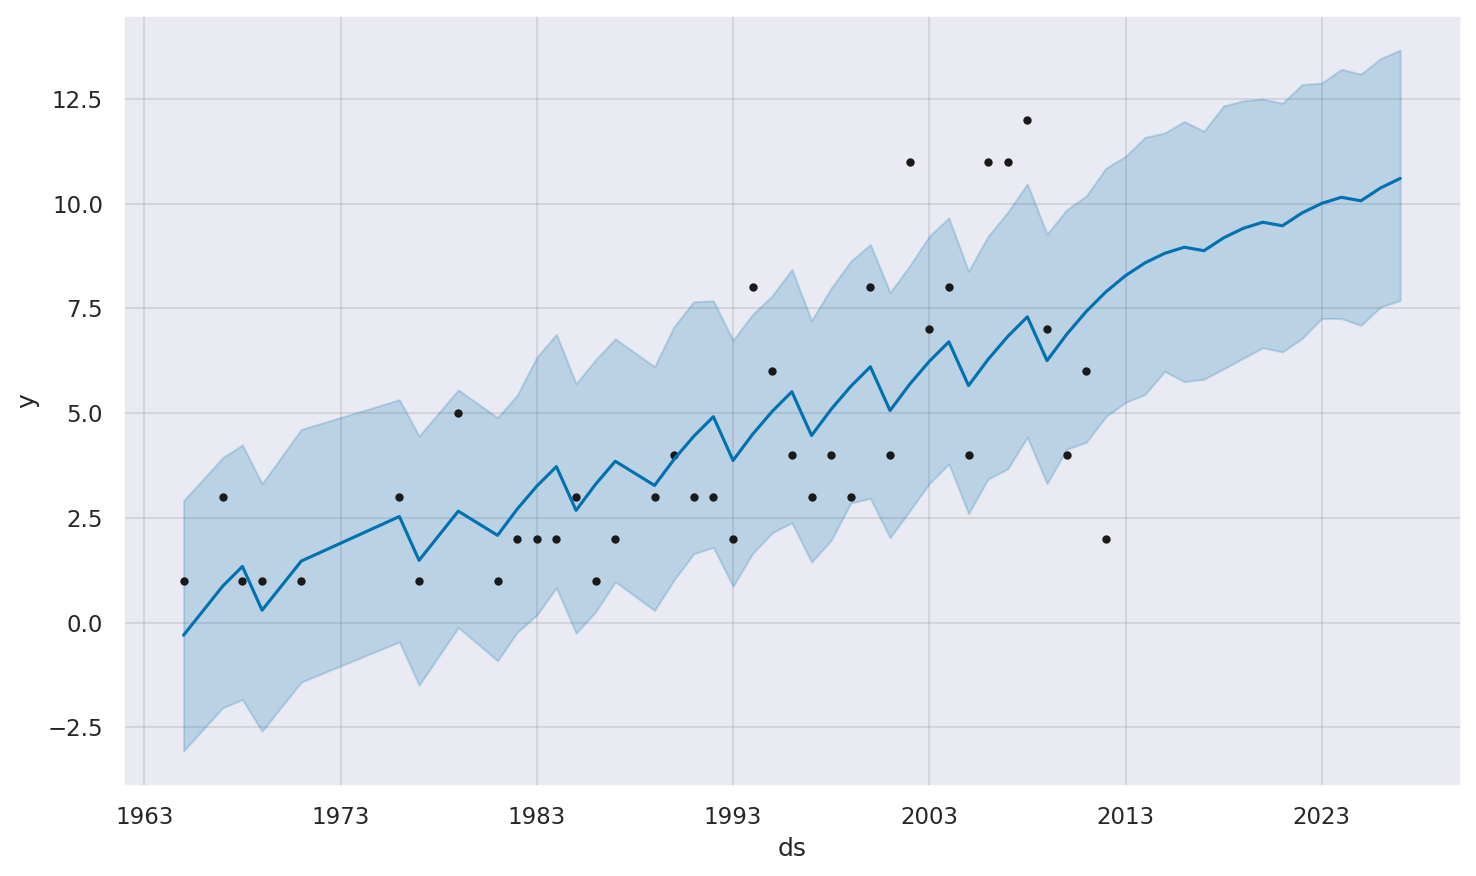

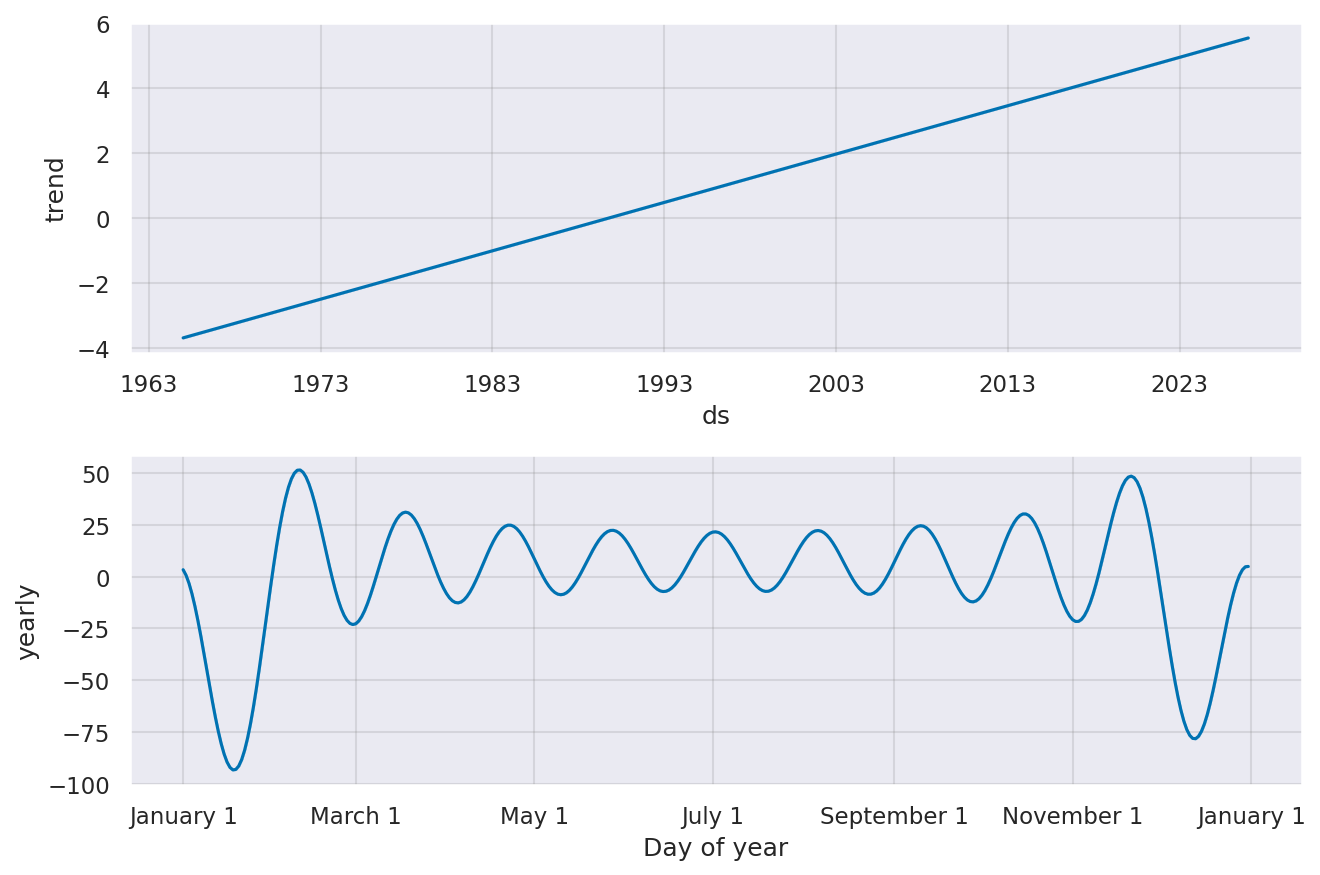

The univariate MAE is : 4.765399915037515
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c09c5a60>, 185.97779218487312, ((0, 1, 0), (0, 1, 0, 7)))


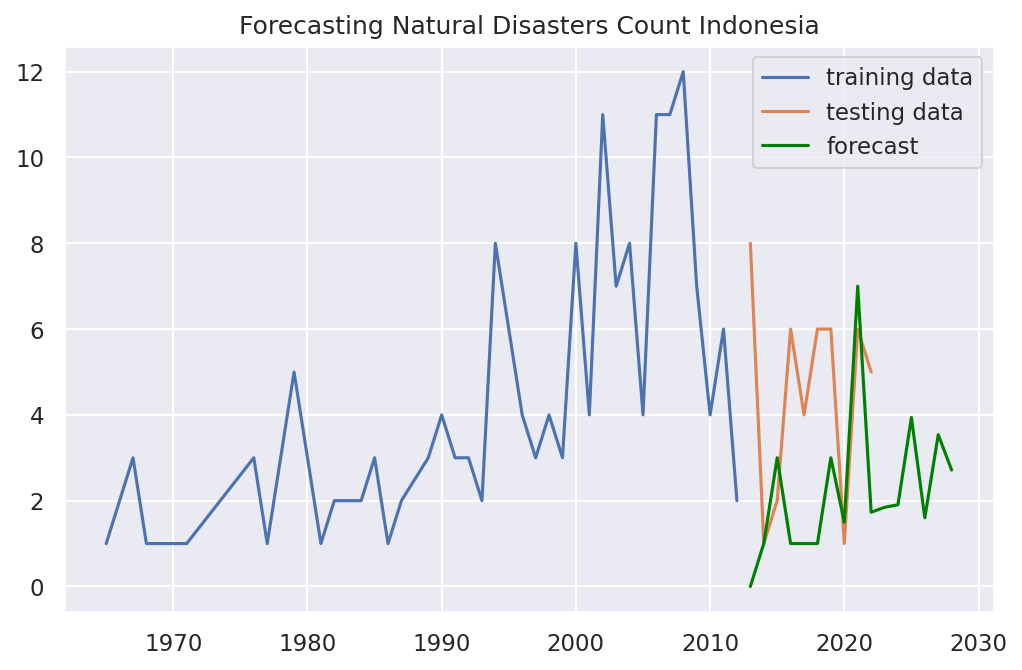

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/imb1aed8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/tvuderl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1133', 'data', 'file=/tmp/tmpvuhzj6lw/imb1aed8.json', 'init=/tmp/tmpvuhzj6lw/tvuderl_.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_modelge_m__28/prophet_model-20230328105937.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:59:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


The univariate MAE is : 2.976930559382613


10:59:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


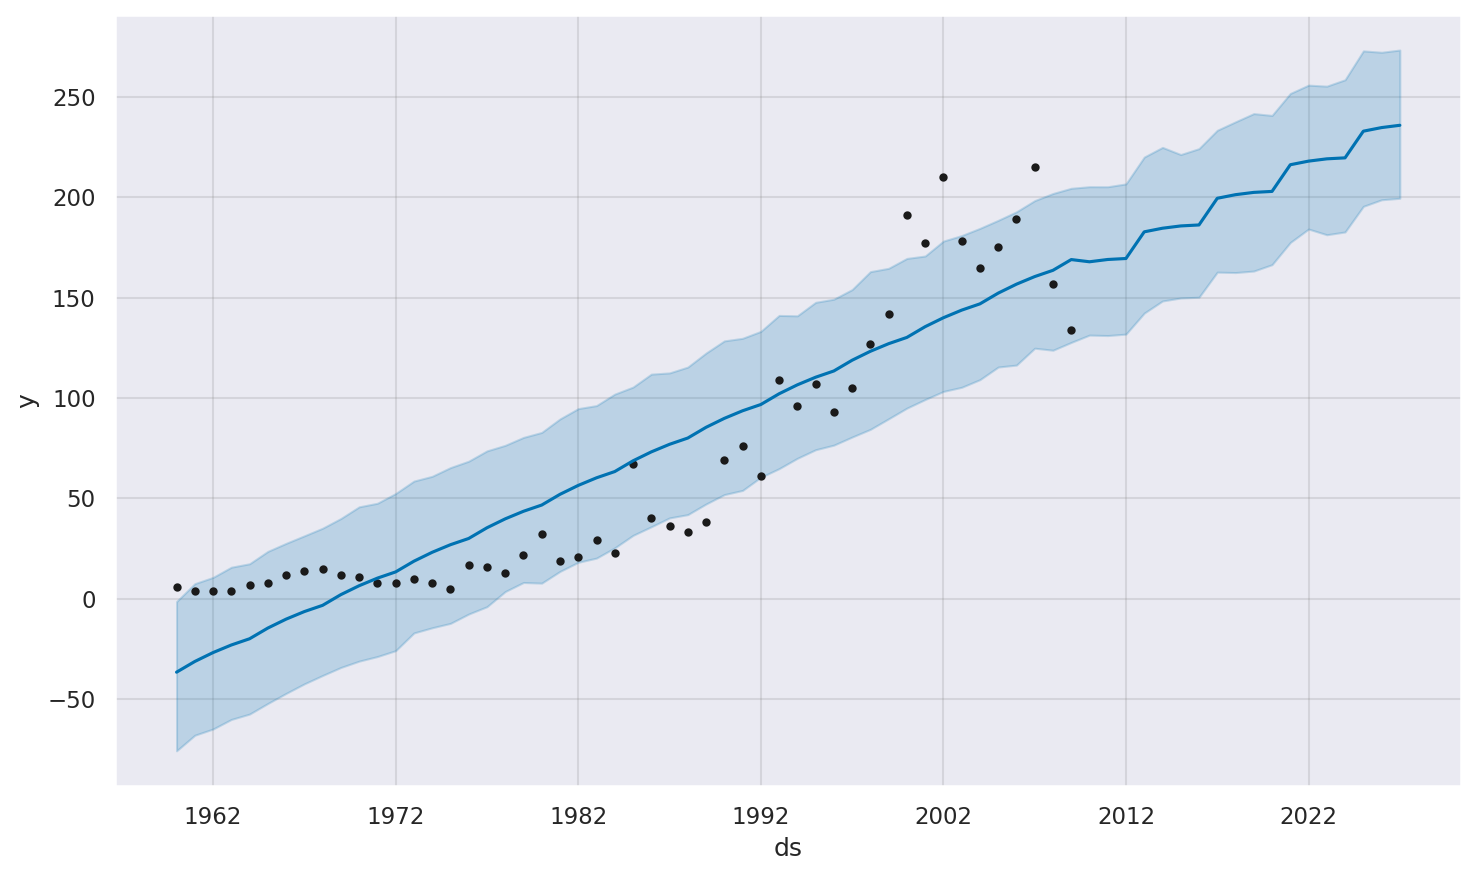

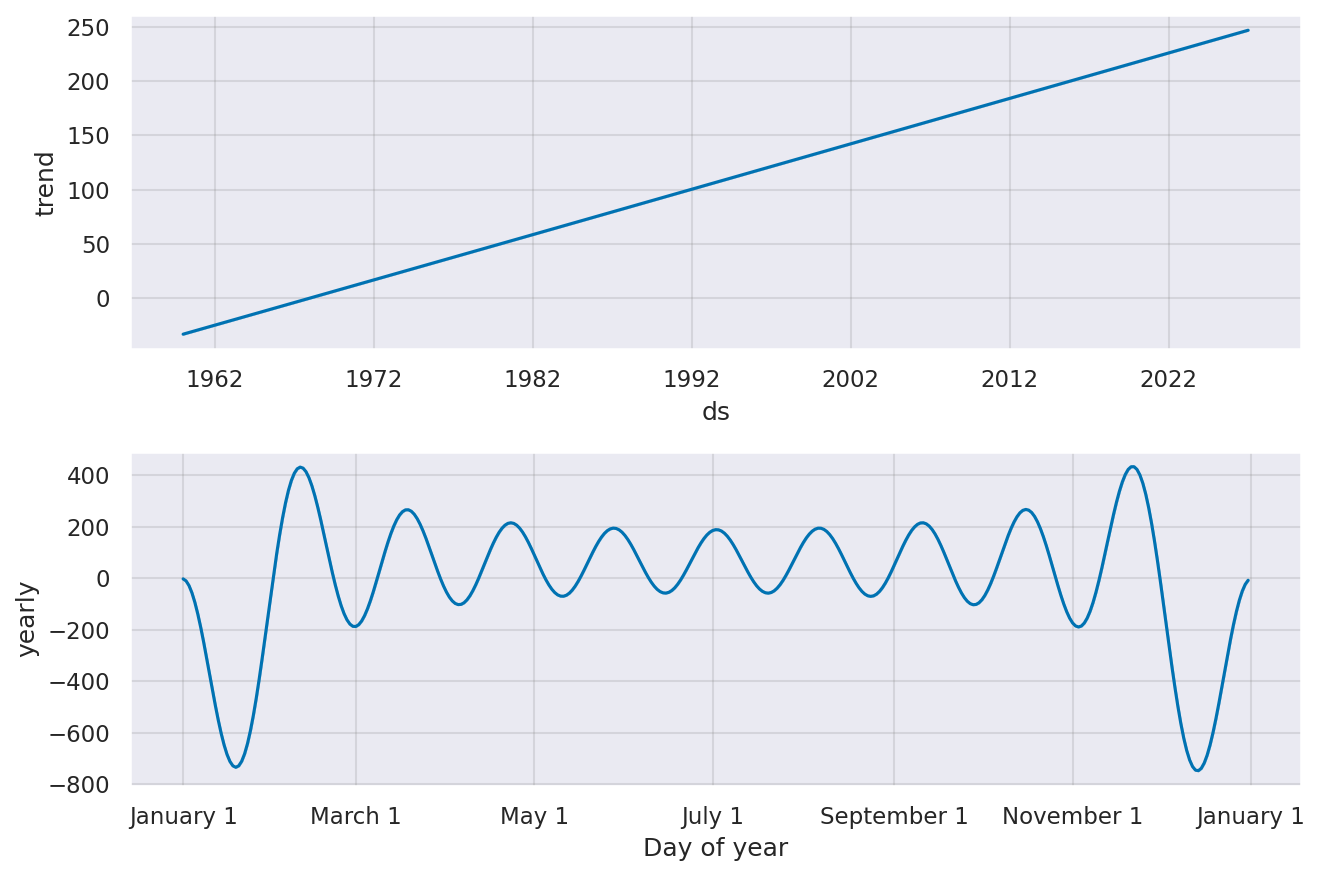

The univariate MAE is : 89.86879525342269
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64bff214c0>, 387.0498086675691, ((0, 1, 0), (0, 1, 0, 7)))


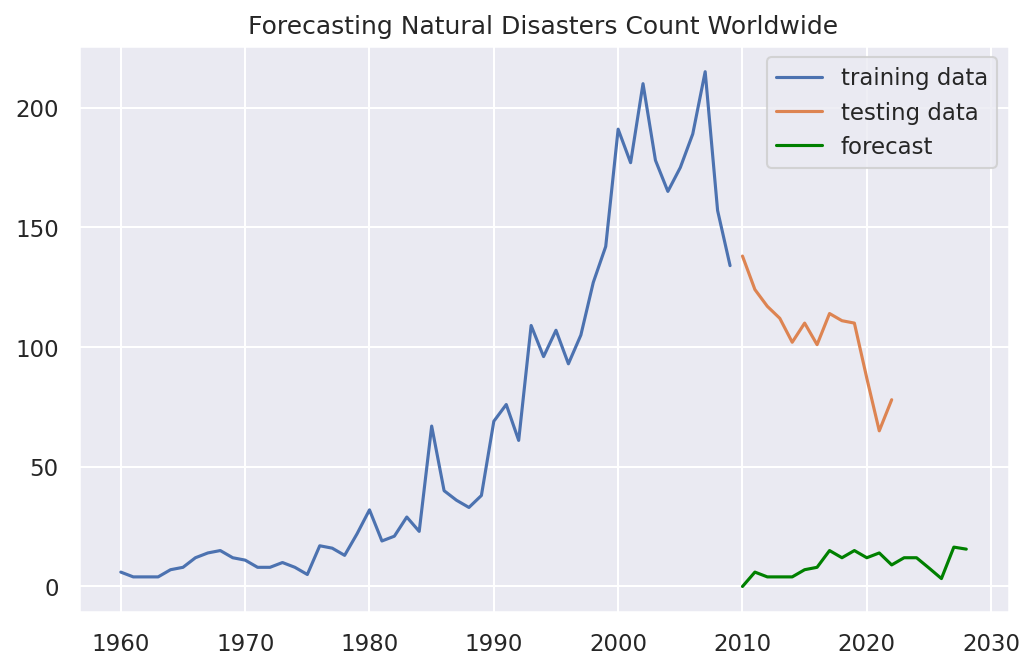

The univariate MAE is : 96.8461823610804


In [69]:
warnings.filterwarnings("ignore")
periods_to_predict = 5

# predicting occurences in the next years
plot_ts_indonesia_world(full_data, "Count", periods_to_predict)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/jv99iux6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/ymkvhm2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21162', 'data', 'file=/tmp/tmpvuhzj6lw/jv99iux6.json', 'init=/tmp/tmpvuhzj6lw/ymkvhm2a.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_model623s22l2/prophet_model-20230328110019.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:00:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:00:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


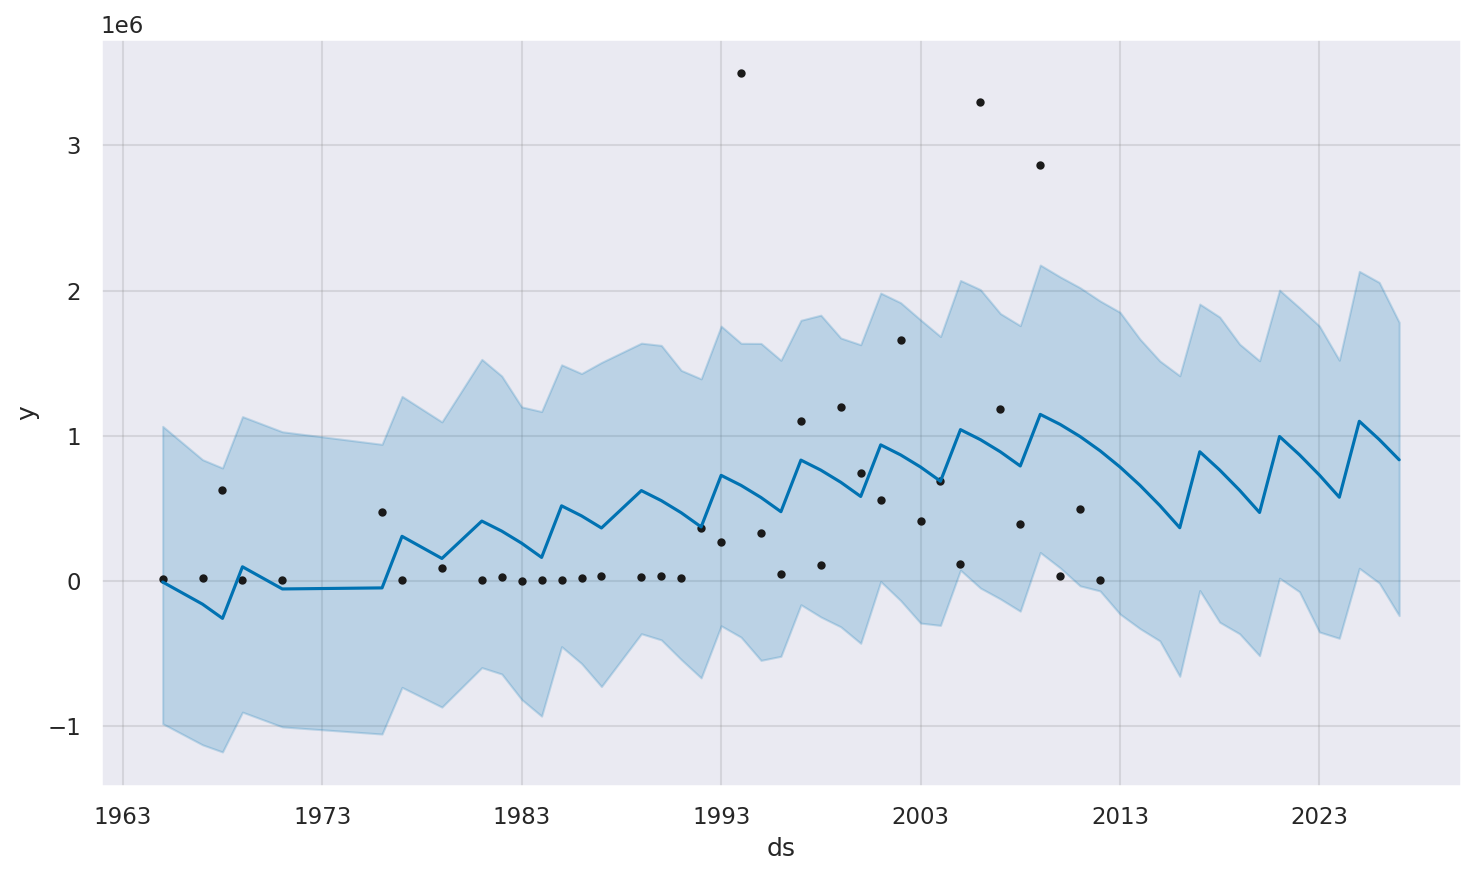

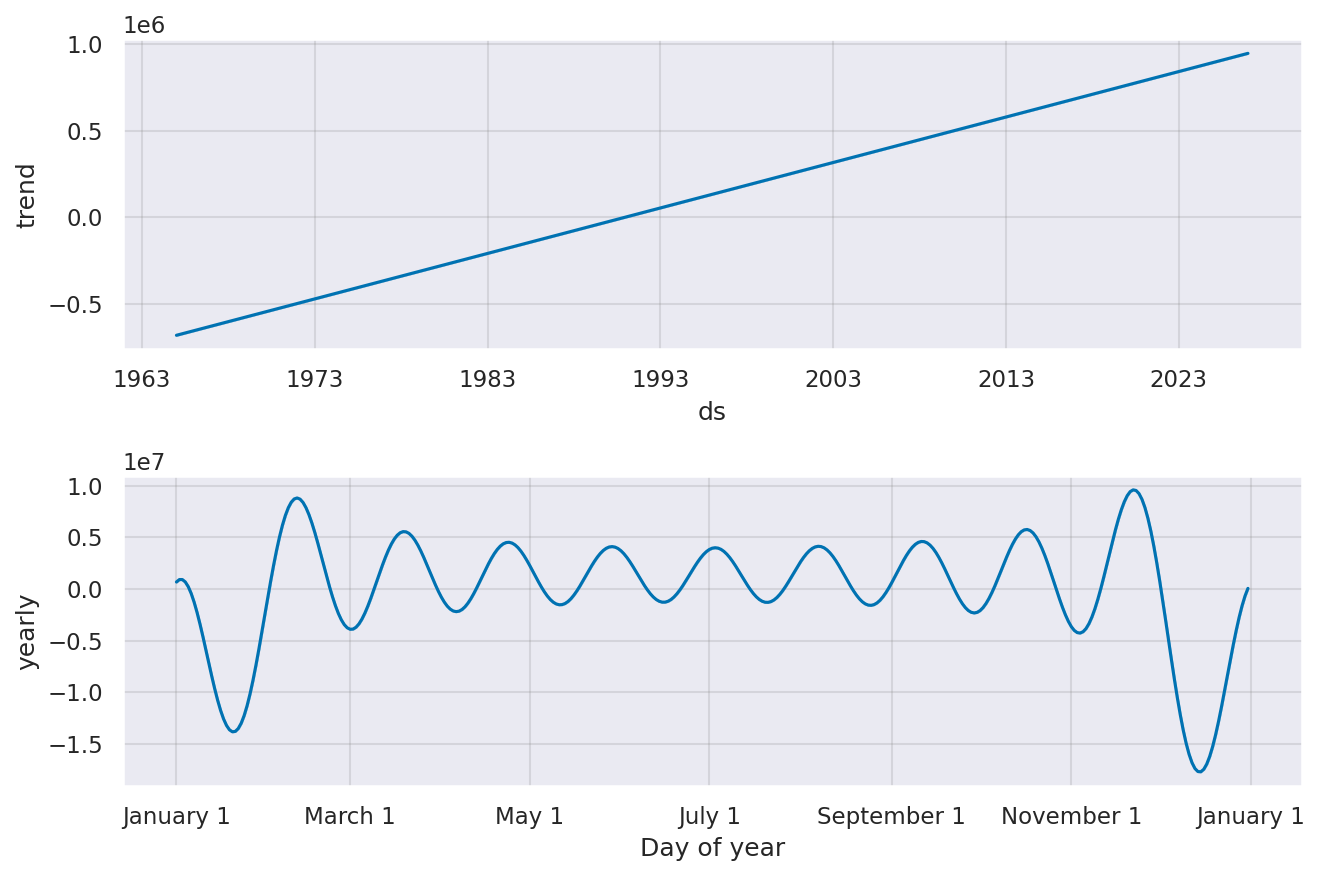

The univariate MAE is : 761171.9827711424
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c080ce50>, 971.8057705964175, ((0, 1, 0), (0, 1, 0, 7)))


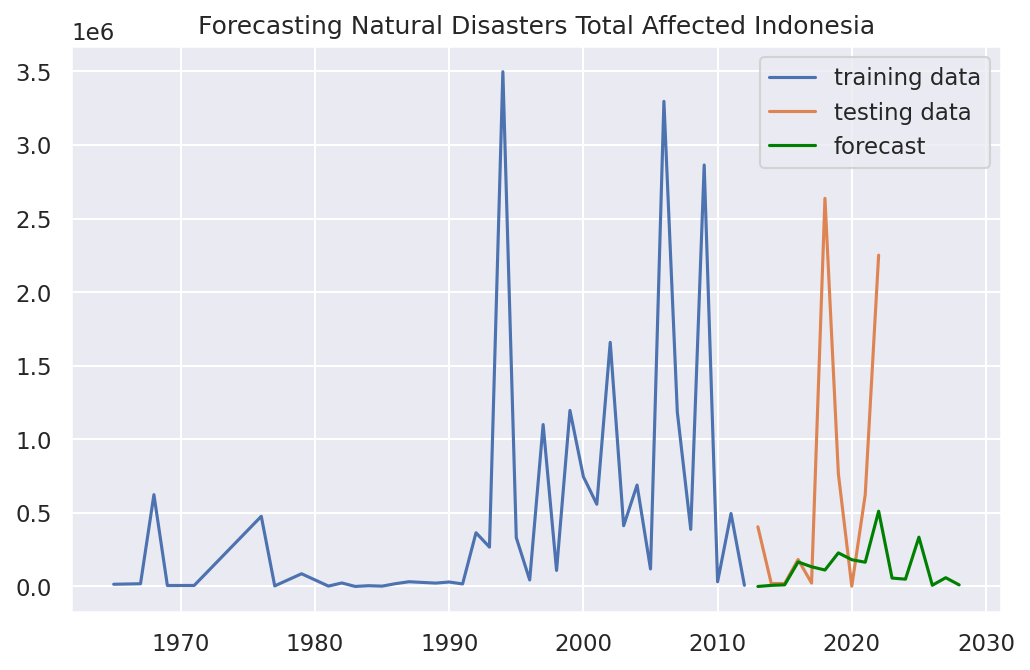

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/z1b6w_pa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/enb0uhb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85340', 'data', 'file=/tmp/tmpvuhzj6lw/z1b6w_pa.json', 'init=/tmp/tmpvuhzj6lw/enb0uhb6.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_model1fd5_6kr/prophet_model-20230328110047.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:00:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


The univariate MAE is : 599583.9560668453


11:00:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


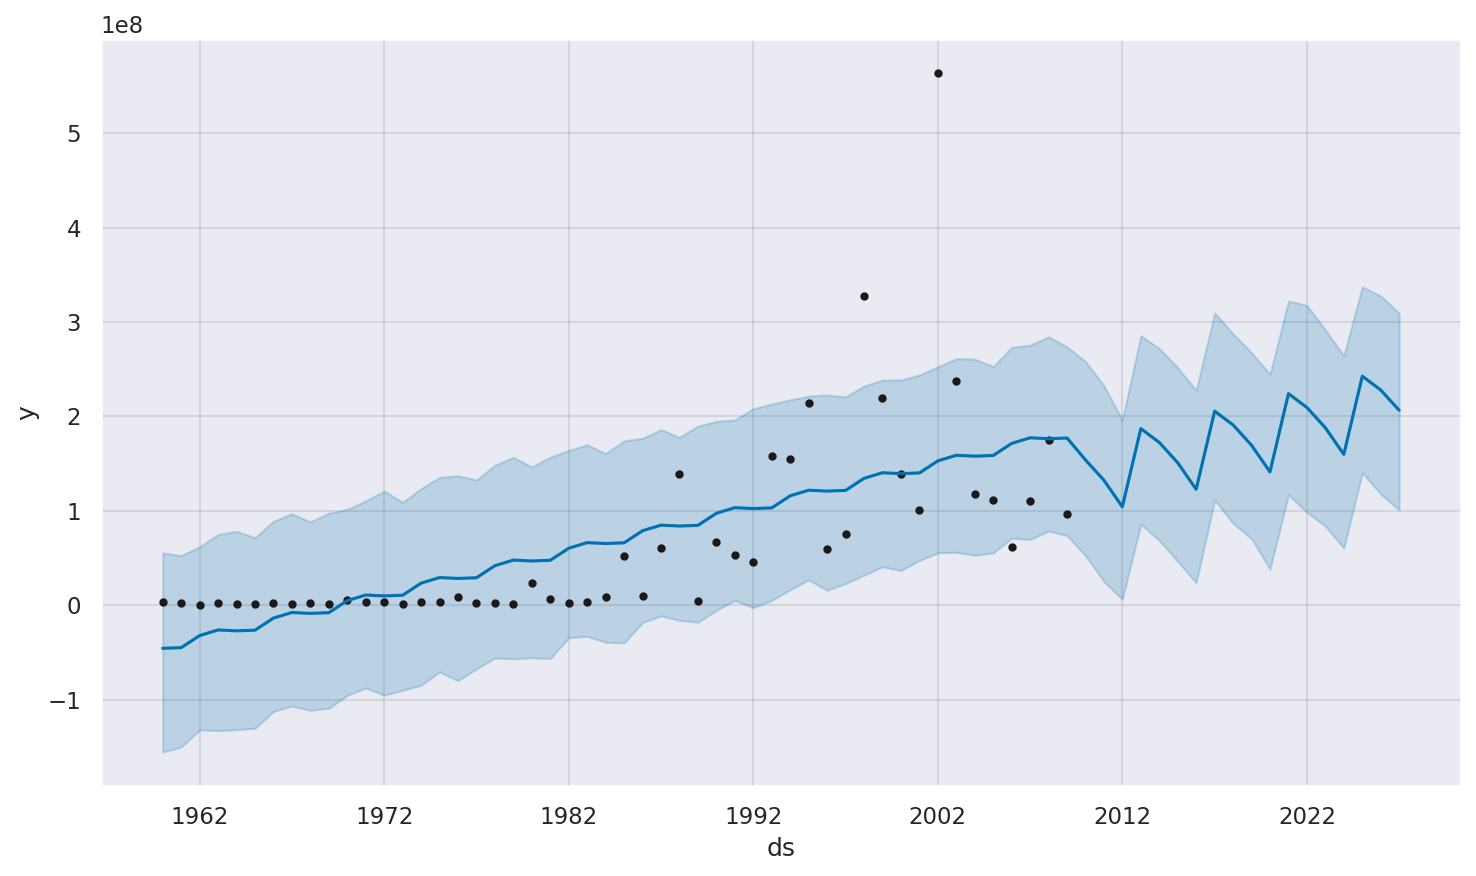

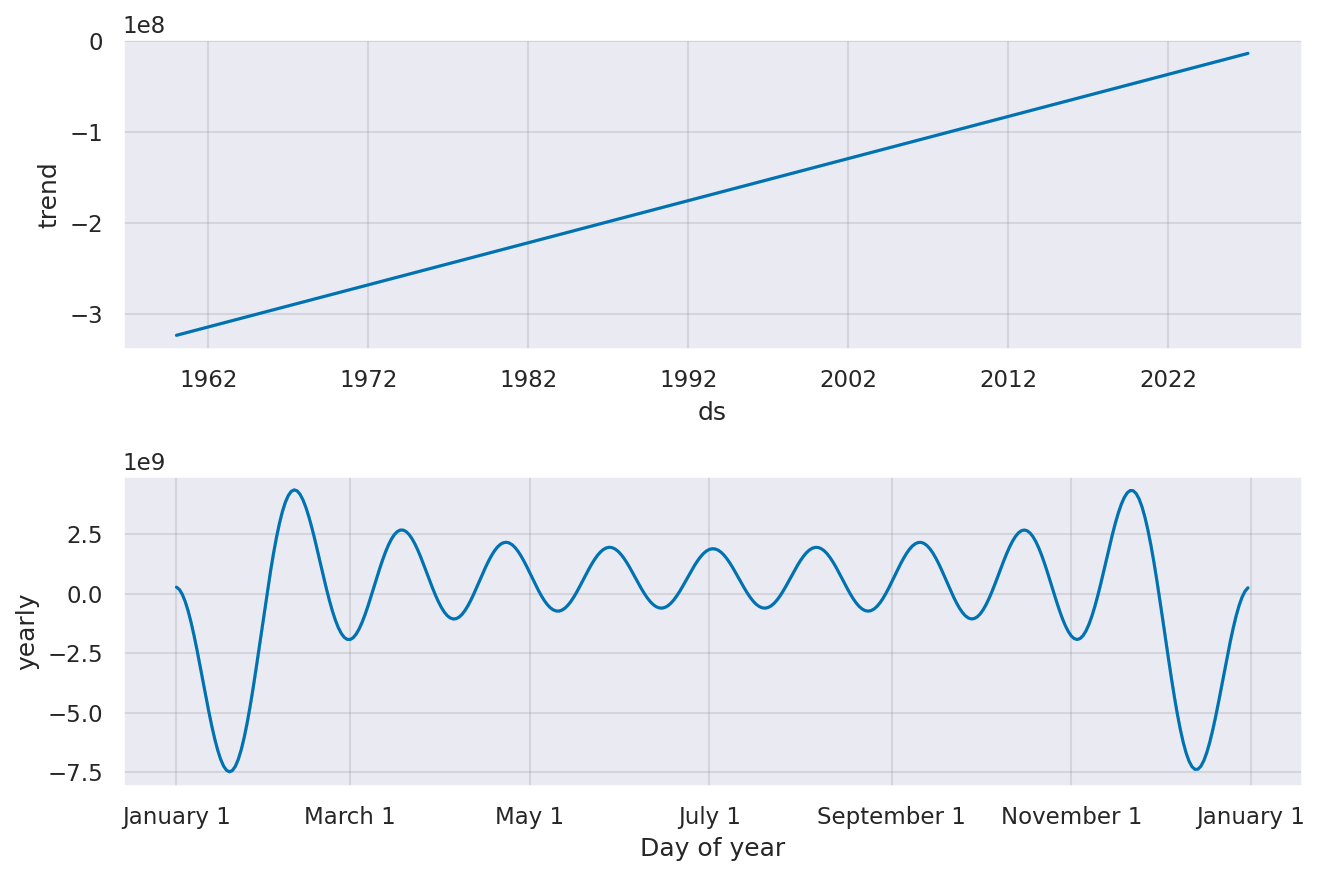

The univariate MAE is : 123199539.56394474
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c13bbf70>, 1695.526450632393, ((0, 1, 0), (0, 1, 0, 7)))


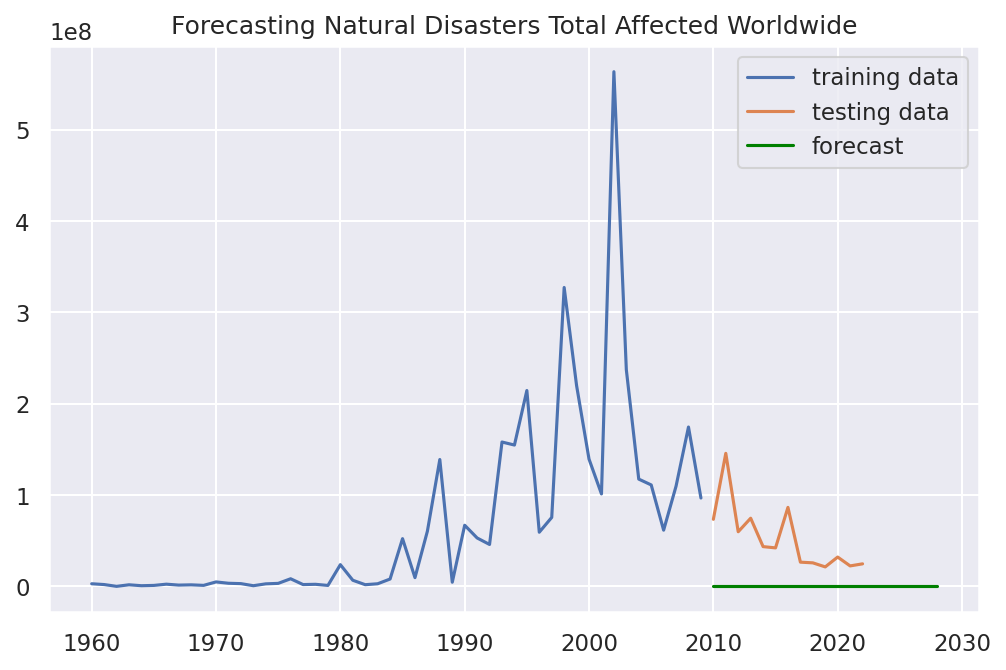

The univariate MAE is : 52294066.75201072


In [70]:
# prediciting affected people in the next years
plot_ts_indonesia_world(full_data, "Total Affected", periods_to_predict)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/da9a31r5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/xvdijwut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49478', 'data', 'file=/tmp/tmpvuhzj6lw/da9a31r5.json', 'init=/tmp/tmpvuhzj6lw/xvdijwut.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_modelykcj05tu/prophet_model-20230328110134.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


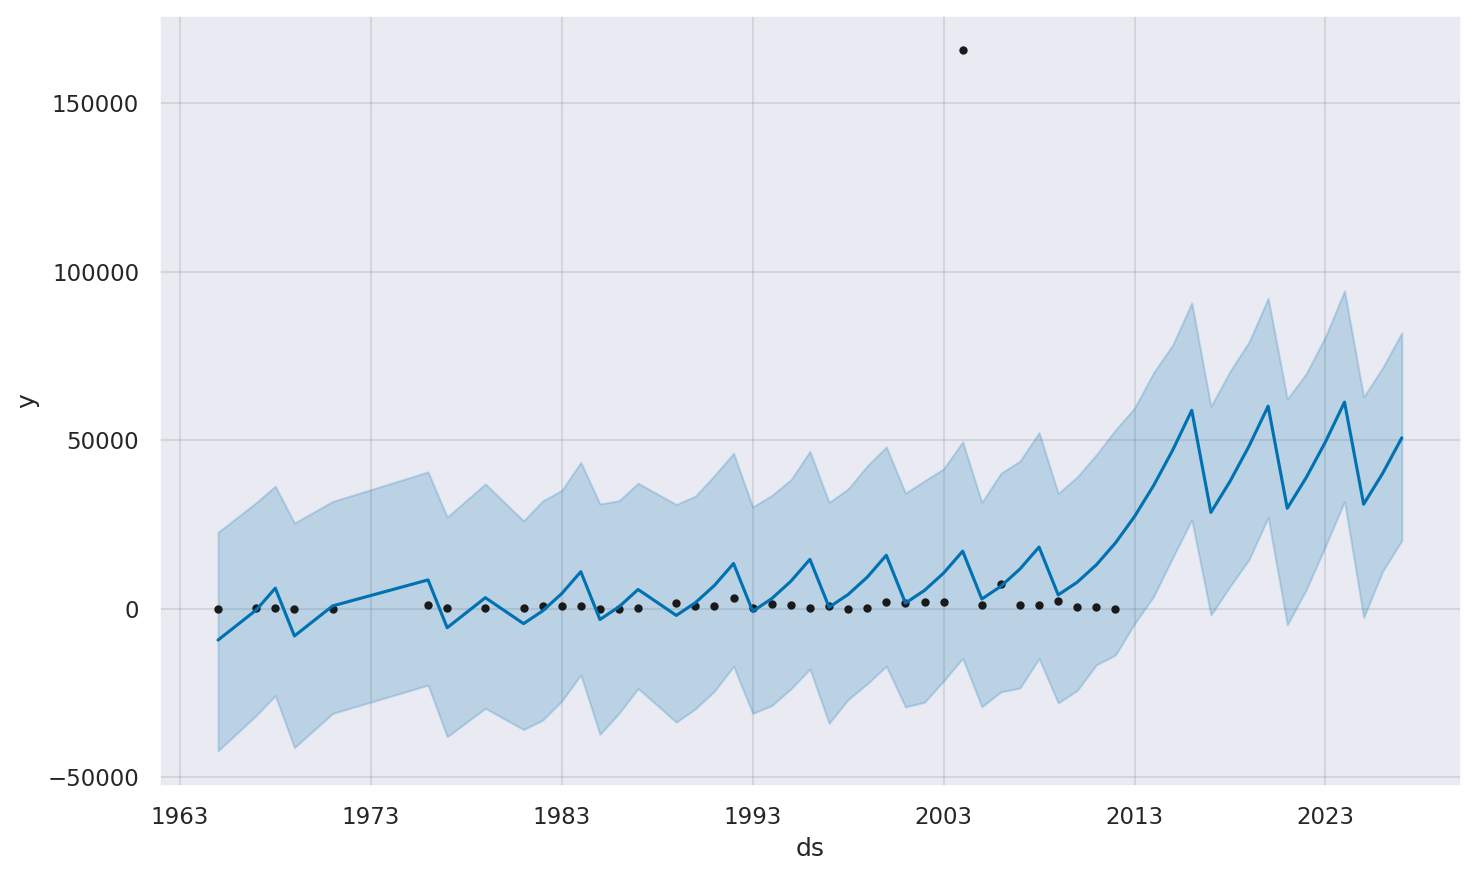

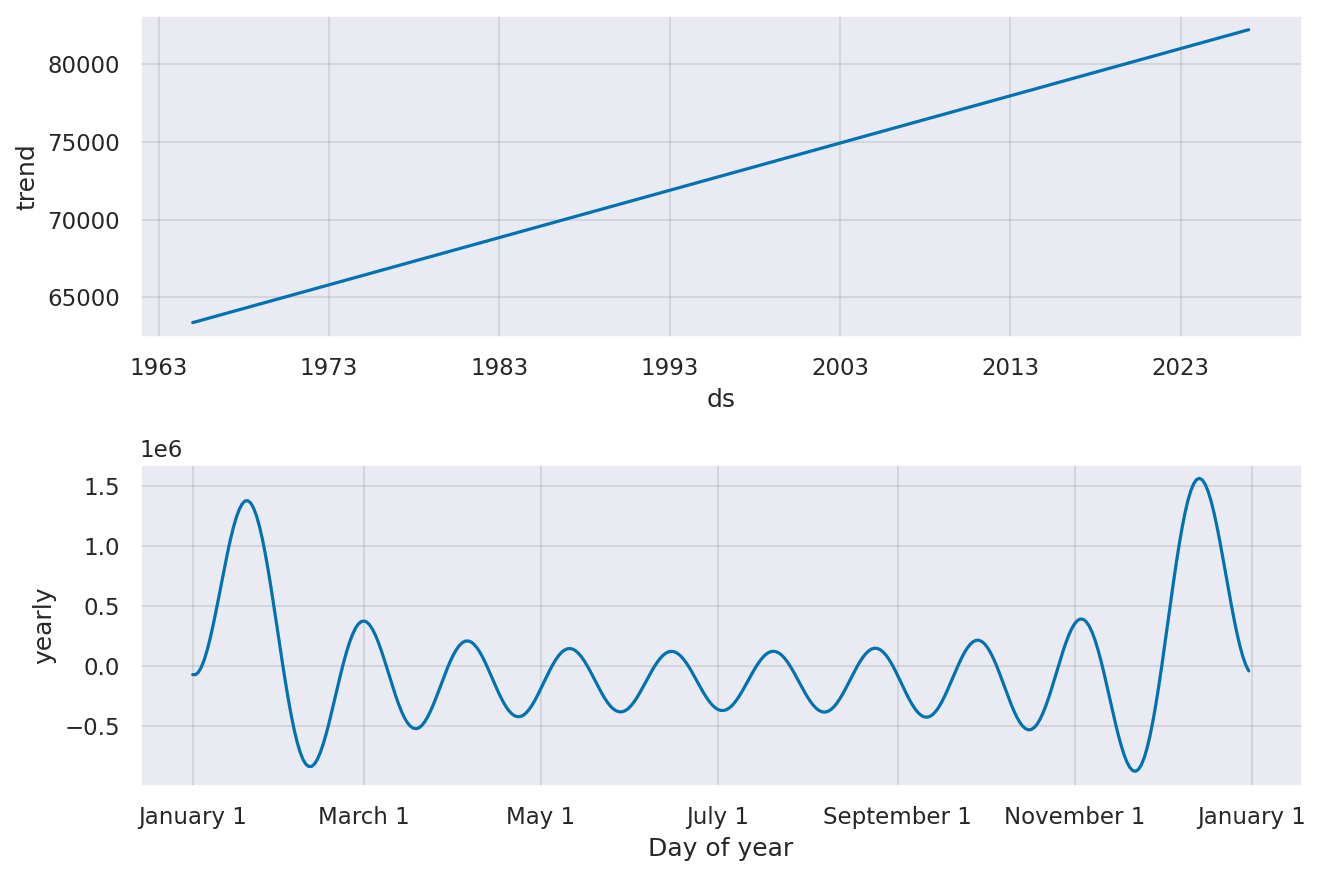

The univariate MAE is : 41593.18970023805
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c1214070>, 771.8178891699903, ((0, 1, 0), (0, 1, 0, 7)))


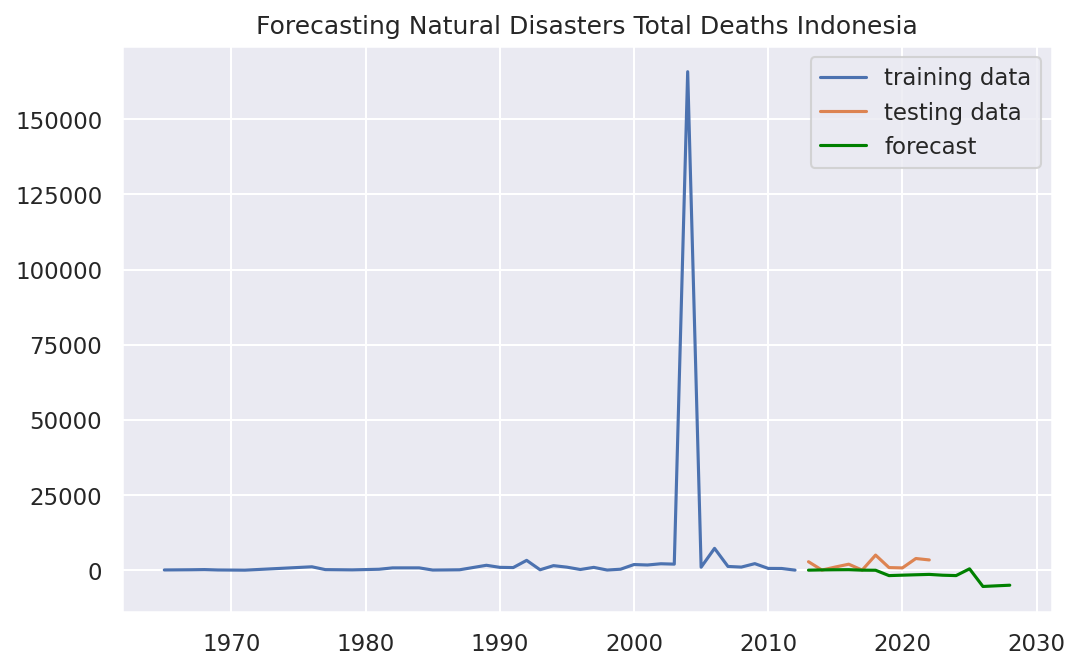

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/nj64zwx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/izfq36bp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44208', 'data', 'file=/tmp/tmpvuhzj6lw/nj64zwx7.json', 'init=/tmp/tmpvuhzj6lw/izfq36bp.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_modelamskzlhy/prophet_model-20230328110203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:02:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


The univariate MAE is : 2595.9949285475996


11:02:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


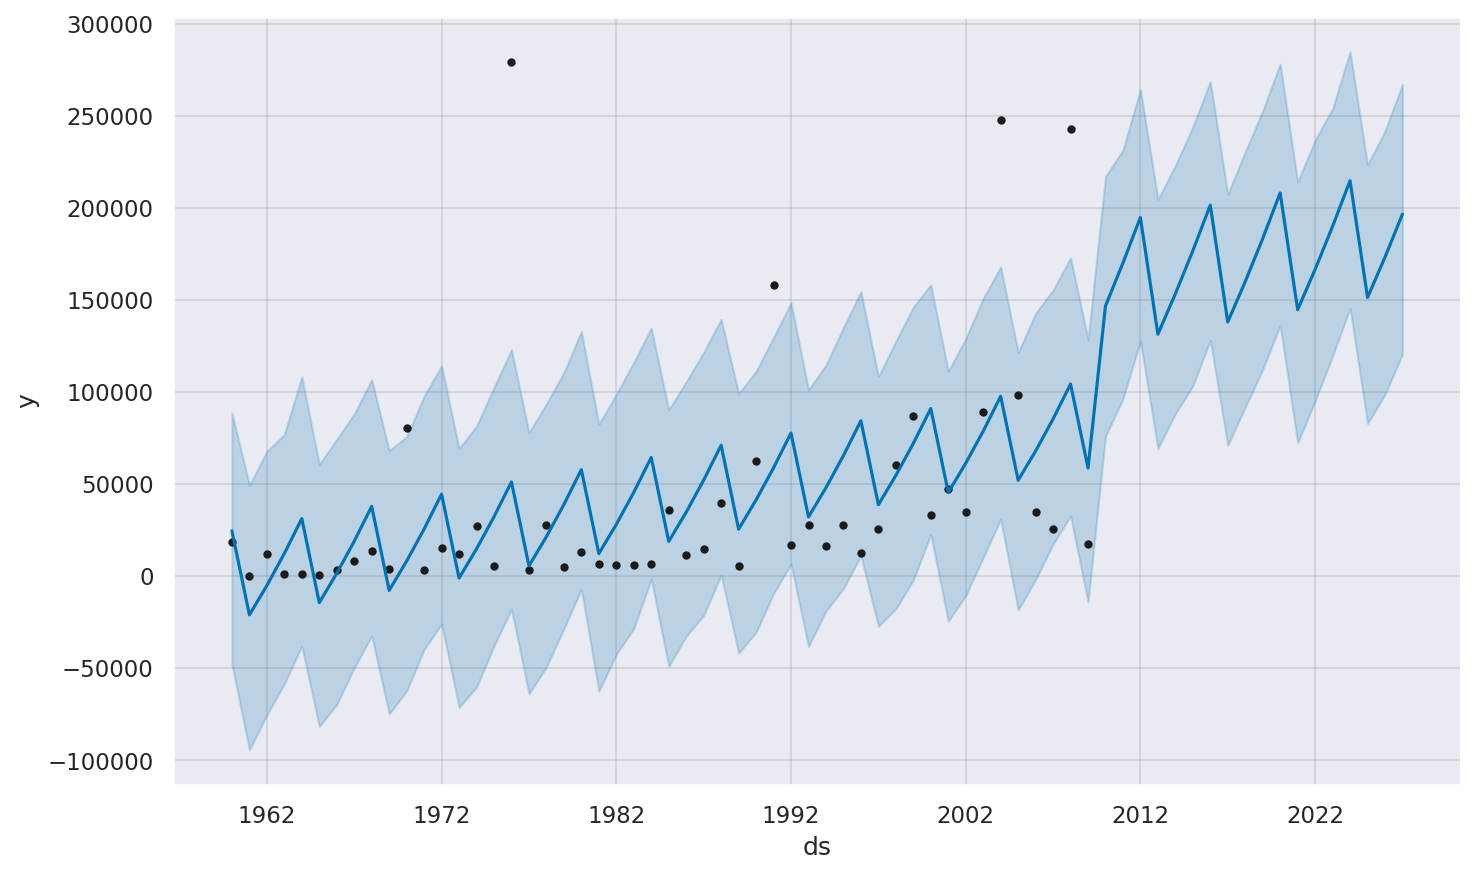

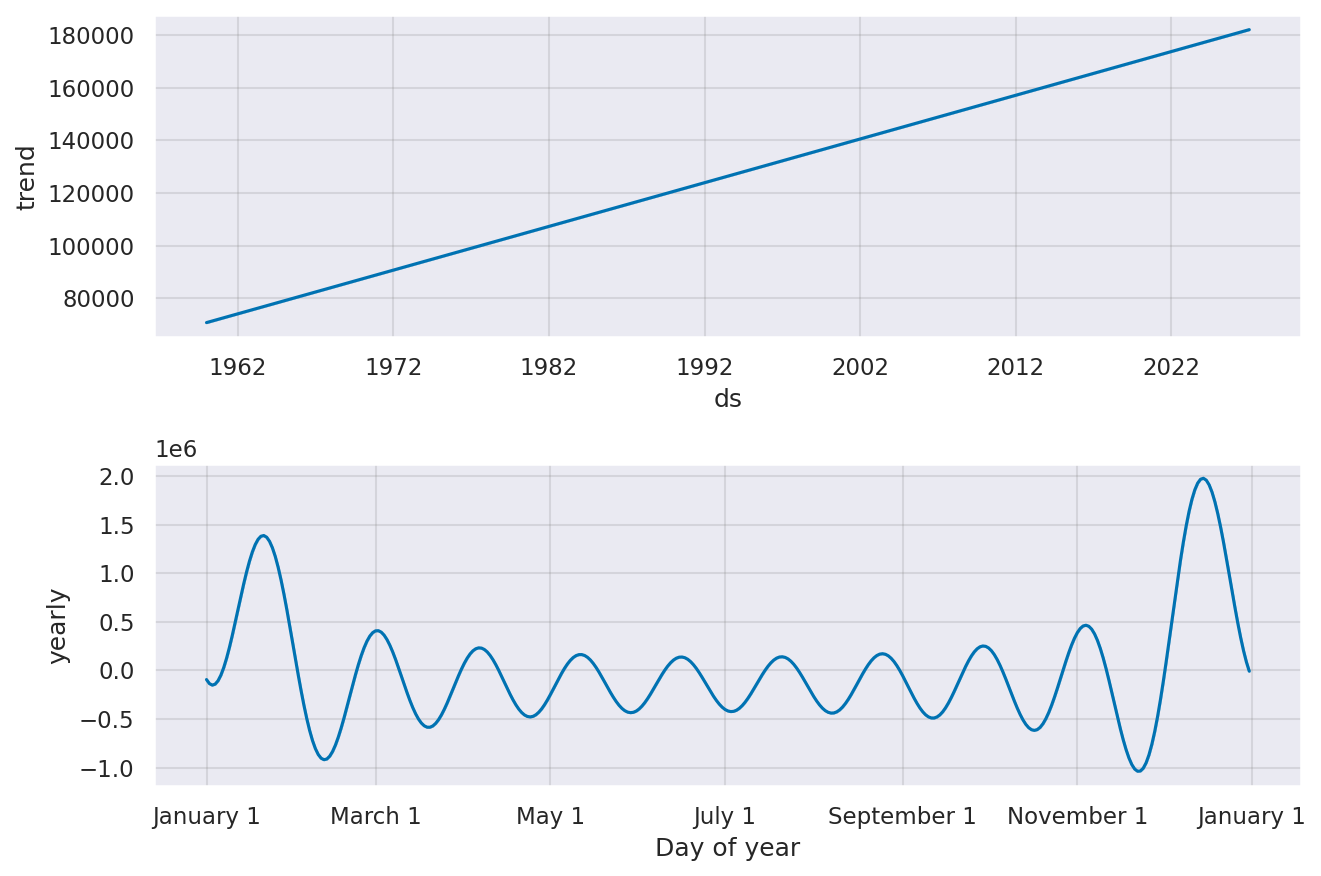

The univariate MAE is : 147047.6091764112
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c11d2490>, 1105.7209487346925, ((0, 1, 0), (0, 1, 0, 7)))


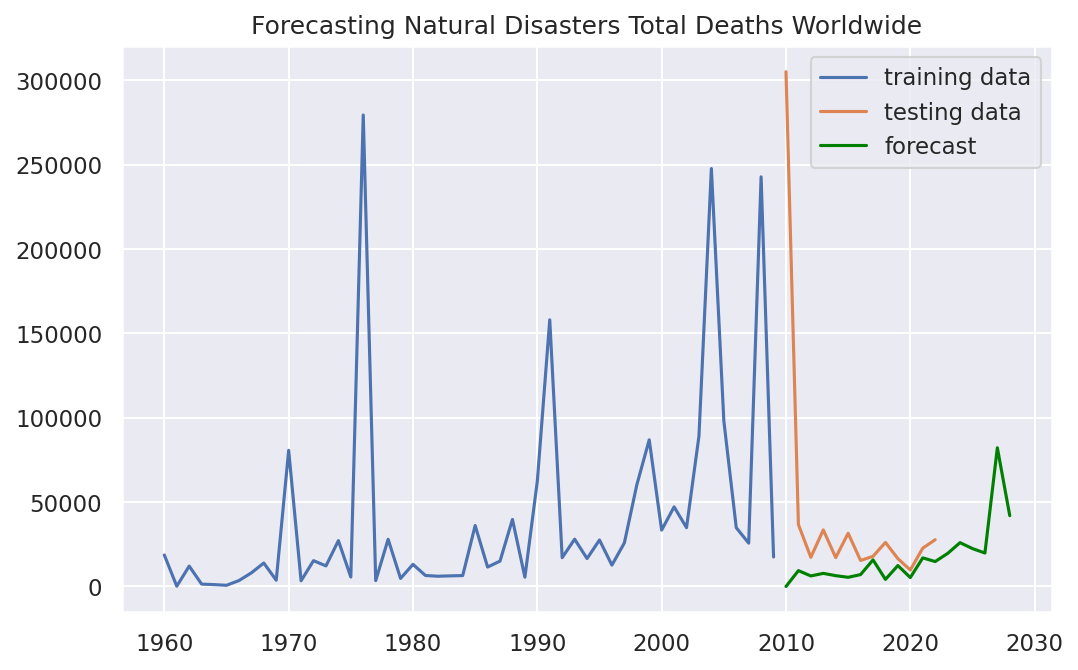

The univariate MAE is : 35825.41657844728


In [ ]:
# prediciting affected people in the next years
plot_ts_indonesia_world(full_data, "Total Deaths", periods_to_predict)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/_shhnx9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/4y9fpzrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69209', 'data', 'file=/tmp/tmpvuhzj6lw/_shhnx9v.json', 'init=/tmp/tmpvuhzj6lw/4y9fpzrg.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_modelnucdvkeu/prophet_model-20230328110227.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:02:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:02:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


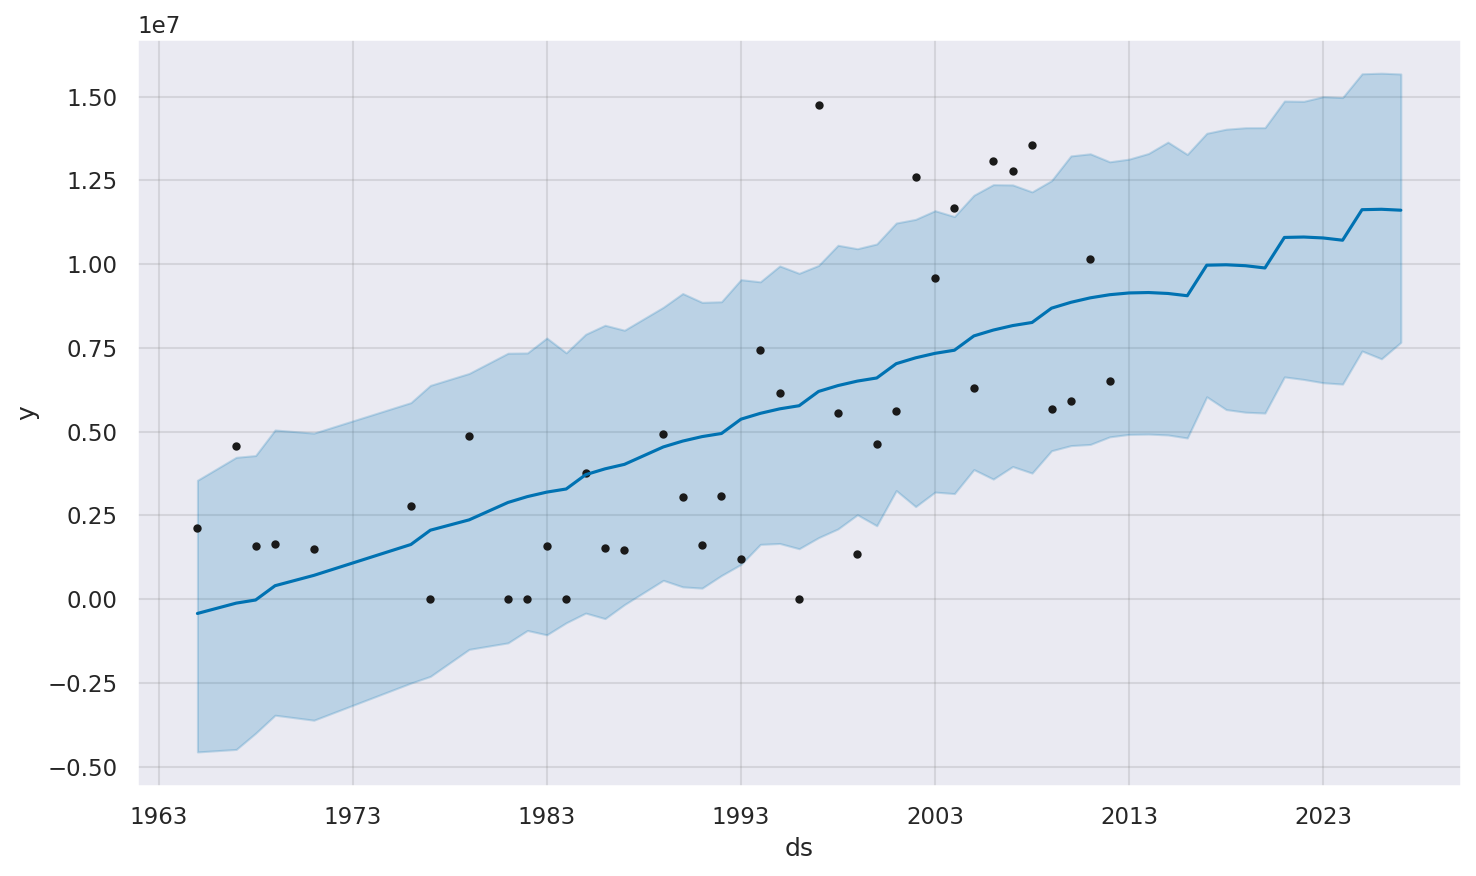

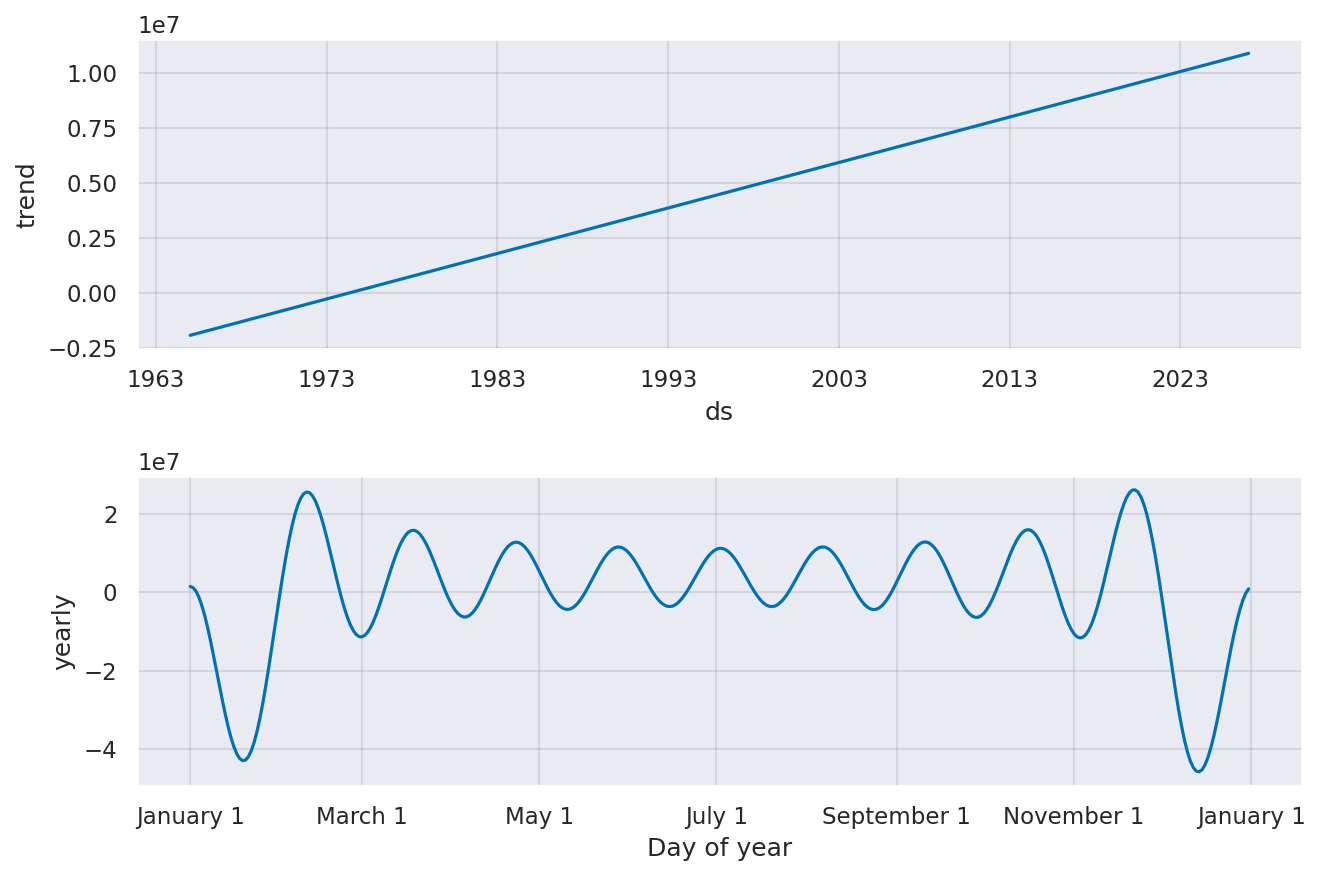

The univariate MAE is : 4677246.332576886
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c11ea640>, 1066.2668733096348, ((0, 1, 0), (0, 1, 0, 7)))


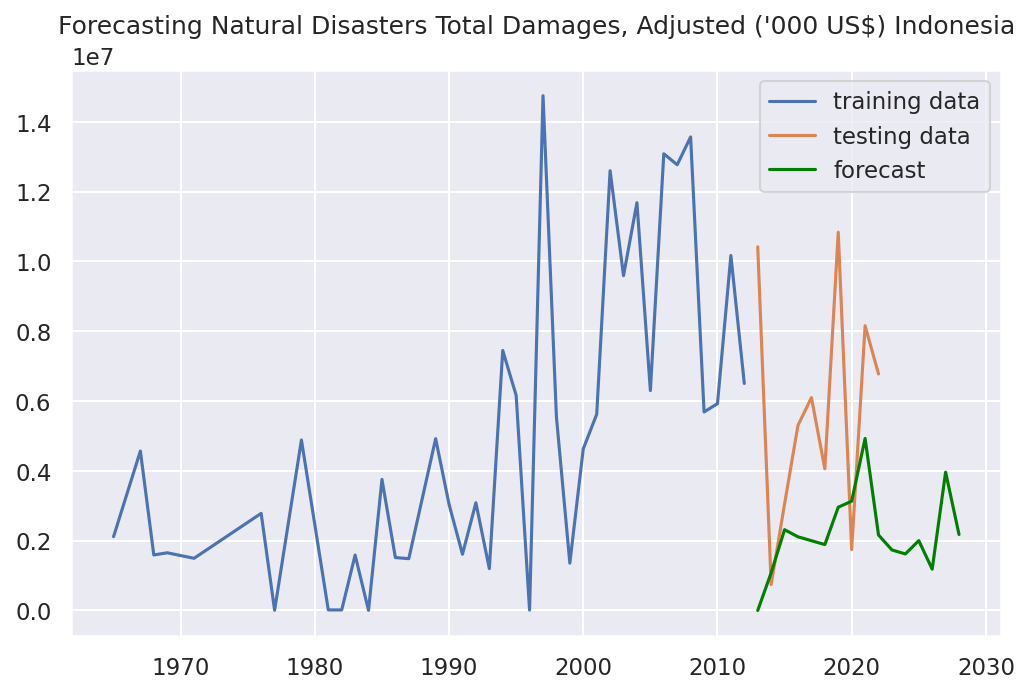

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/e1cnson1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvuhzj6lw/uckldpzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10024', 'data', 'file=/tmp/tmpvuhzj6lw/e1cnson1.json', 'init=/tmp/tmpvuhzj6lw/uckldpzd.json', 'output', 'file=/tmp/tmpvuhzj6lw/prophet_modelpu_pczaj/prophet_model-20230328110246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:02:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


The univariate MAE is : 3805984.7959246337


11:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


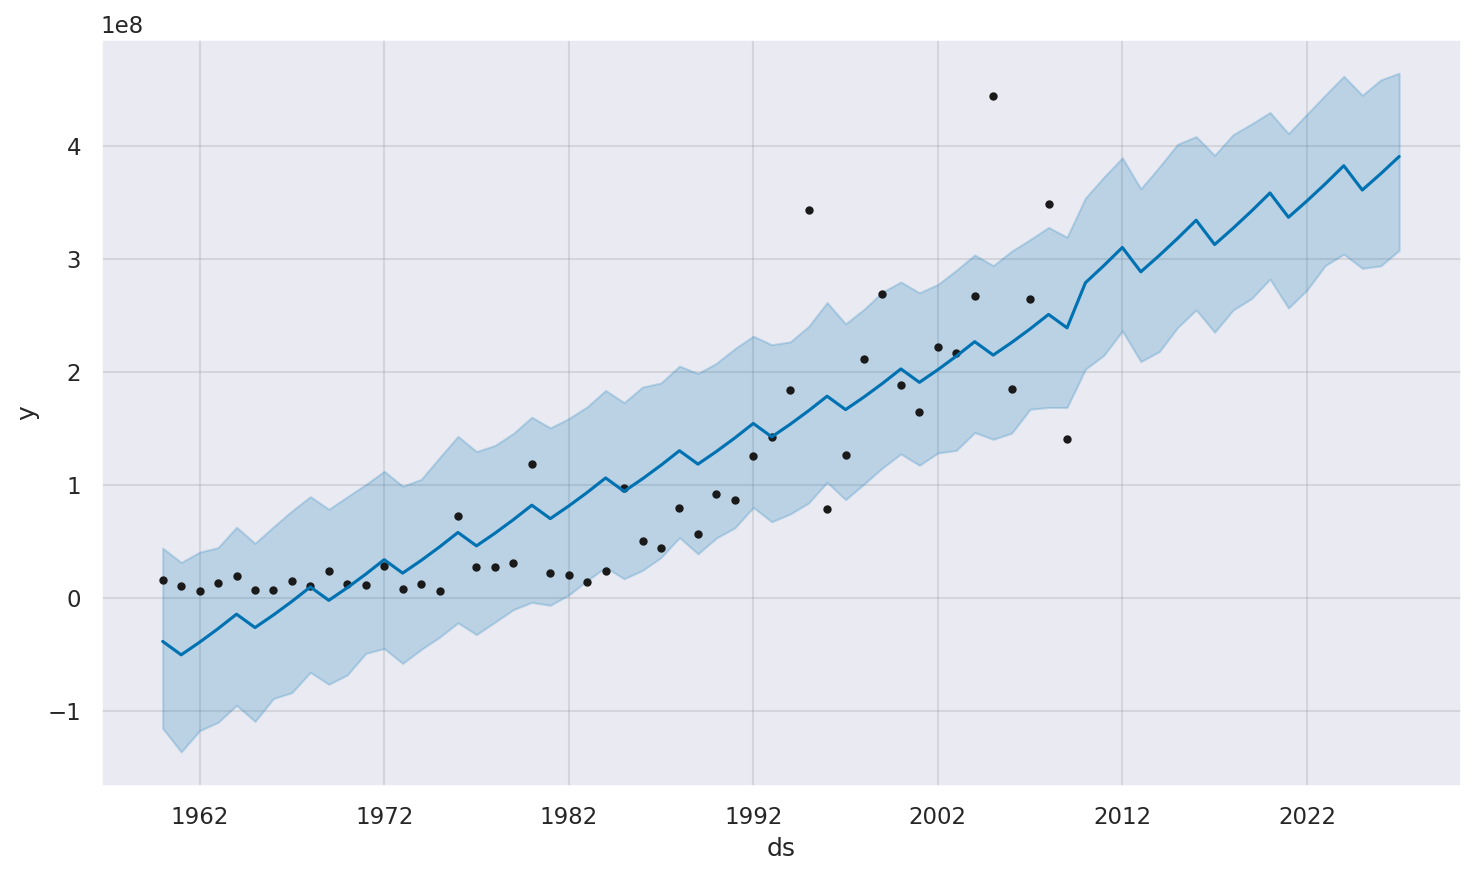

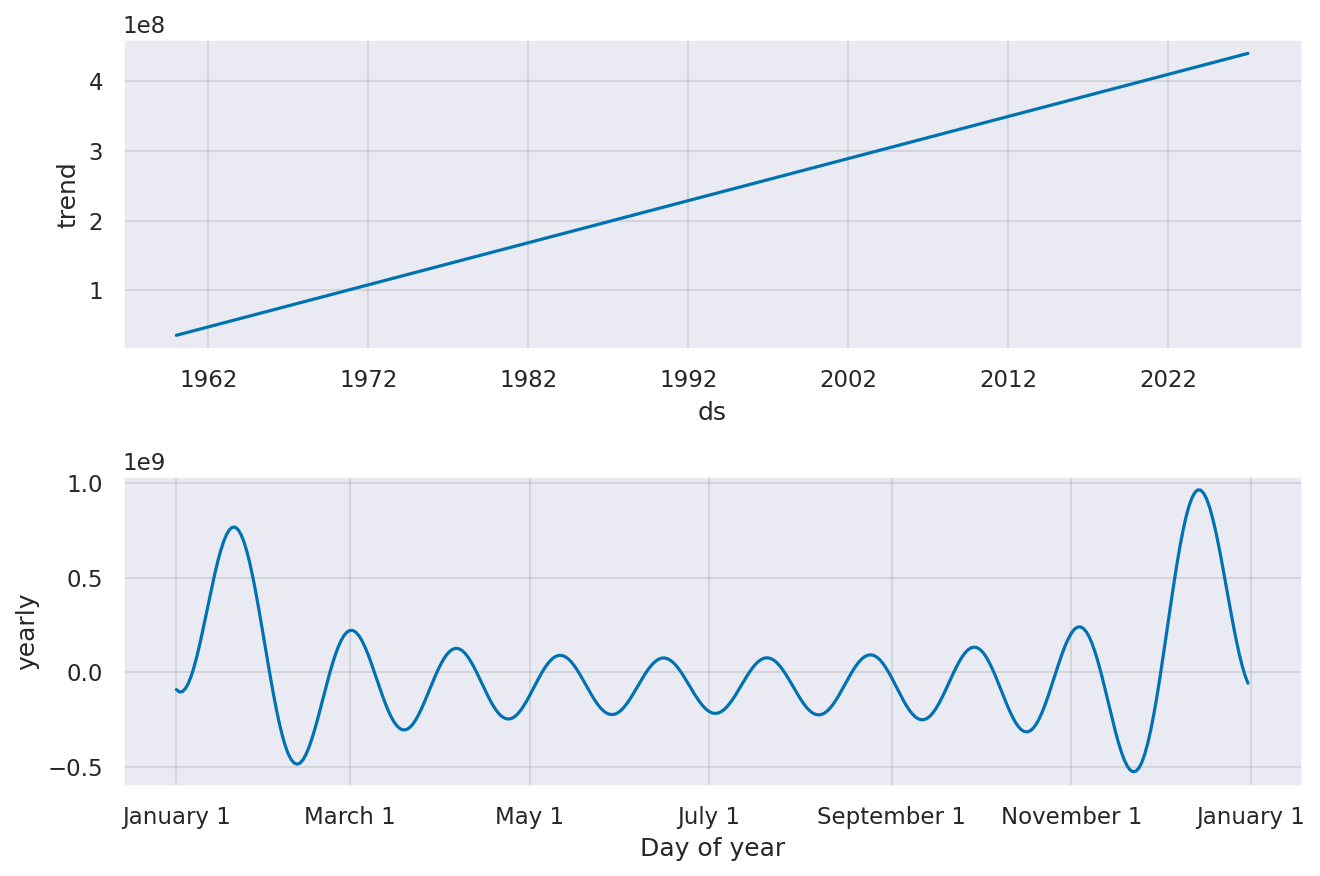

The univariate MAE is : 152986341.29279023
(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7f64c12673d0>, 1674.0227121805067, ((0, 1, 0), (0, 1, 0, 7)))


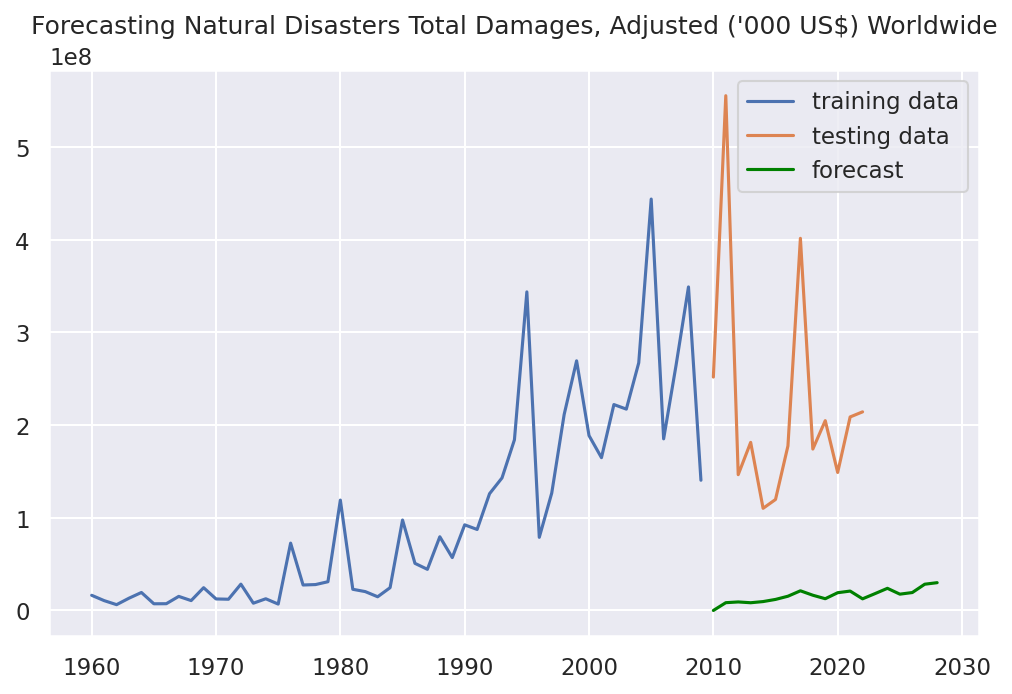

The univariate MAE is : 209929848.33023736


In [ ]:
# prediciting affected people in the next years
plot_ts_indonesia_world(full_data, "Total Damages, Adjusted ('000 US$)", periods_to_predict)

## **Prediction: Linear Regression**

*Forecasting:*

- Total Damages
- Total Affected
- Total Deaths


**Helper functions**

In [ ]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    rmse = np.sqrt(np.sum((np.array(actual)-np.array(predicted))**2)/len(actual))  # formula above
    return rmse


def select_columns(data, *columns):
    return data.reindex(columns = columns)


def train_test_country(data, country):
    data = data[data.Country == country]
    train, test = train_test_split(data, test_size=0.2)
    return train, test


def plot_training_path(final_model):
    # map out the path of the model
    plt.plot(final_model.alphas_, np.sqrt(np.apply_along_axis(np.mean, 1, final_model.mse_path_)))
    plt.axvline(x=final_model.alpha_, color='red', linestyle='dashed')
    ax = plt.gca()
    ax.set_title('Average LASSO RMSE Path')
    ax.set_xlabel('alpha')
    ax.set_ylabel('RMSE')
    plt.show()
  

def plot_residuals(y_test, y_predicted, variable):
    fm_residuals = y_test - y_predicted
    ax = sns.regplot(x=y_test, y=fm_residuals)
    ax.set_xlabel(f'{variable} (Test Data)')
    ax.set_ylabel('Residuals (Actual - Predicted)')
    plt.title('Residuals for the Final Model')
    plt.show()


**Train - test split worldwide data** 

In [ ]:
np.random.seed(12) 
# Split the data 
train, test = train_test_split(full_data, test_size=0.2)

In [ ]:
print('train:', train.shape)
print('test:', test.shape)

train: (3754, 26)
test: (939, 26)


**Feature selection**

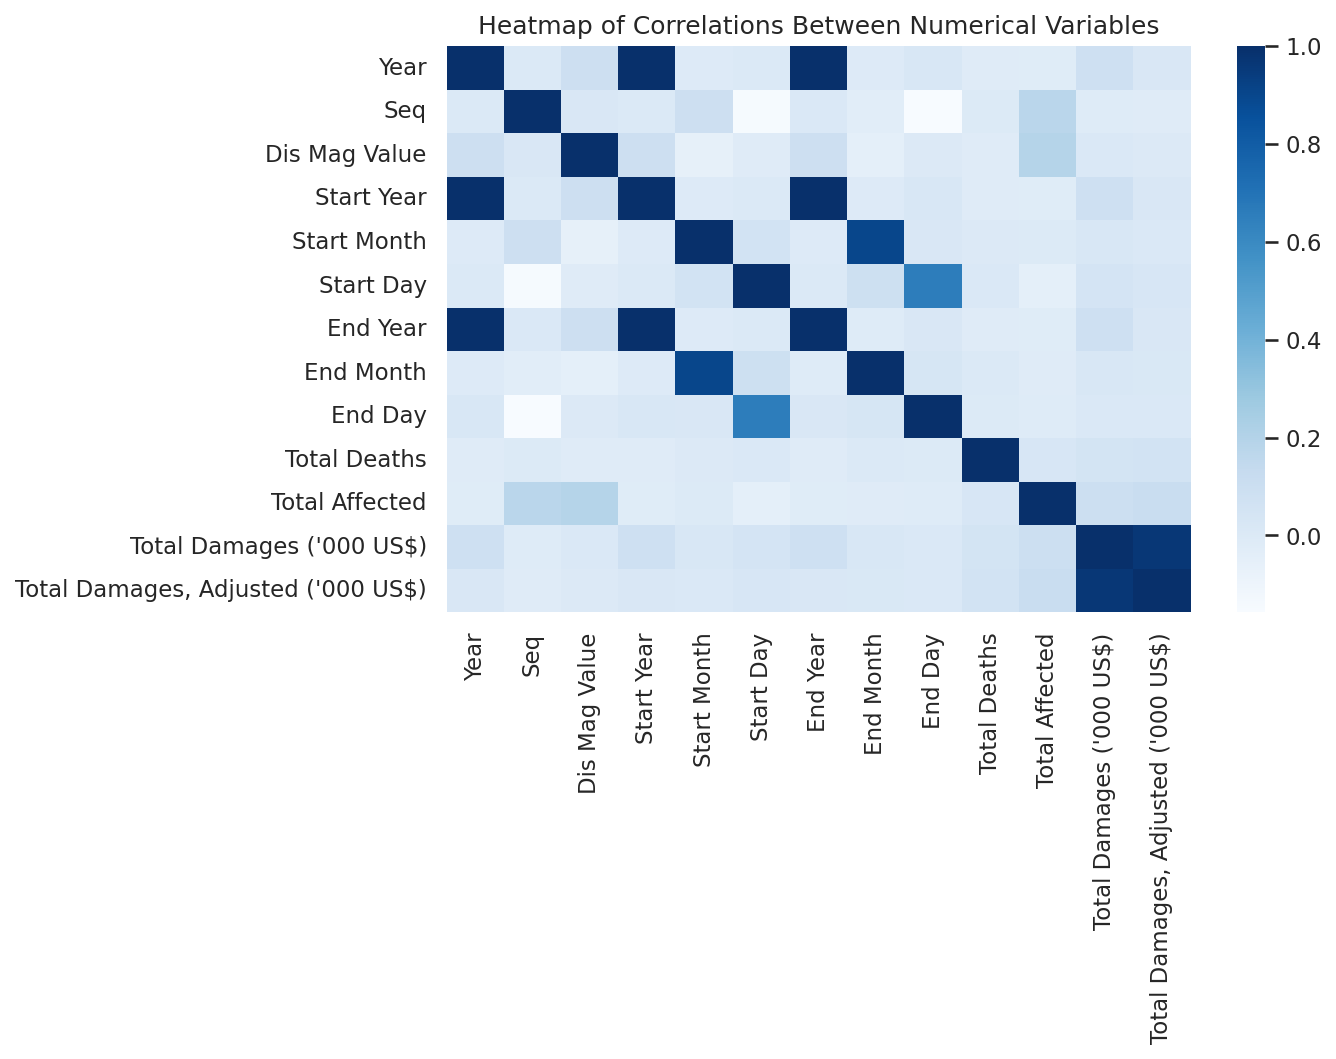

In [ ]:
# see how the different (numerical) variables correlate
correlation = train.corr()
sns.heatmap(data=correlation, cmap='Blues')
plt.title('Heatmap of Correlations Between Numerical Variables')
plt.show()

From the plot it is visible that Total Deaths, Total Affected and Total Damages are correlated and can be used to predict each other in the linear model. Other standout feature seems to be Dis Mag Value.

In [ ]:
train.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Country',
       'ISO', 'Region', 'Continent', 'Location', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages ('000 US$)', 'Total Damages, Adjusted ('000 US$)',
       'CPI'],
      dtype='object')

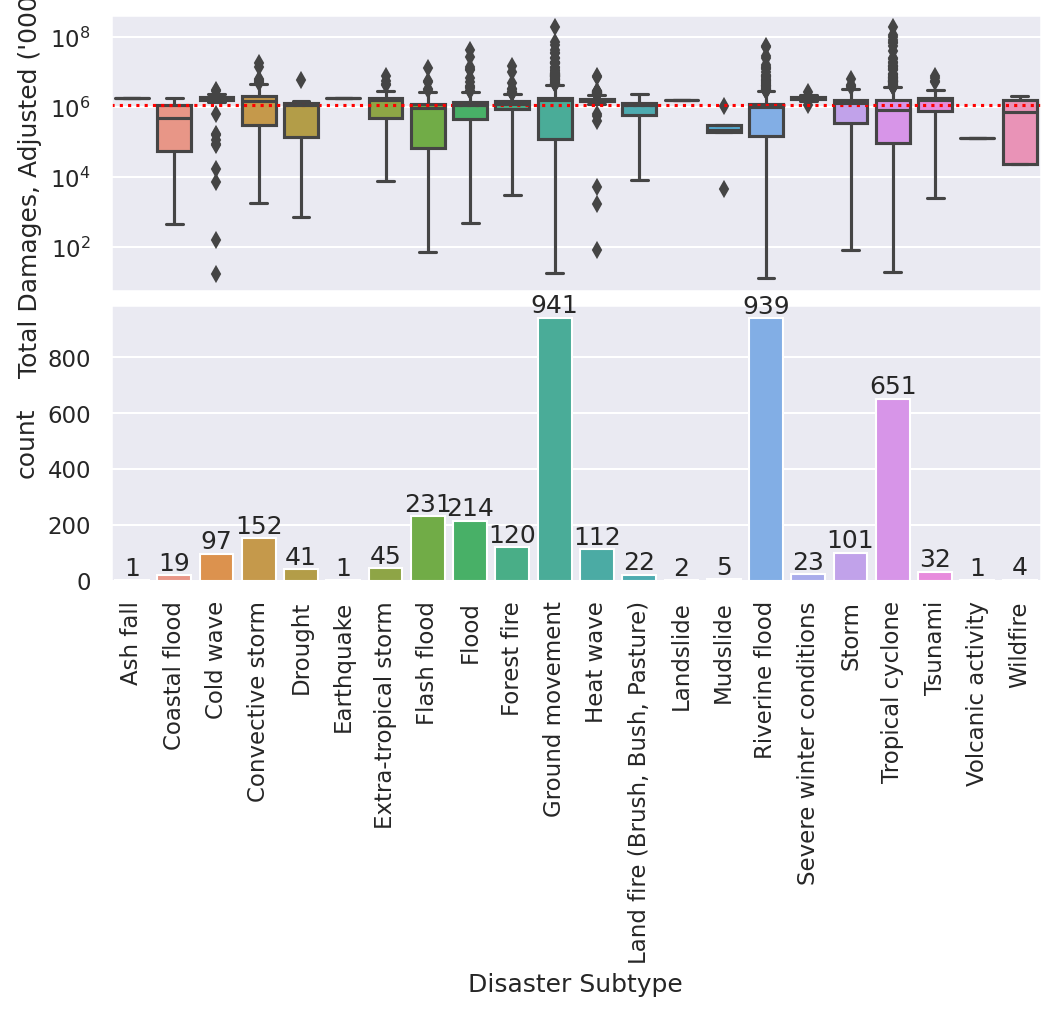

In [ ]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Disaster Subtype',
    y= "Total Damages, Adjusted ('000 US$)",
    data=train.sort_values('Disaster Subtype'),
    ax=axs[0]
)

# logarithmic scale to get a clearer visualization
axs[0].set_yscale('log')

sns.countplot(
    x='Disaster Subtype',
    data=train.sort_values('Disaster Subtype'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=train["Total Damages, Adjusted ('000 US$)"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.05)

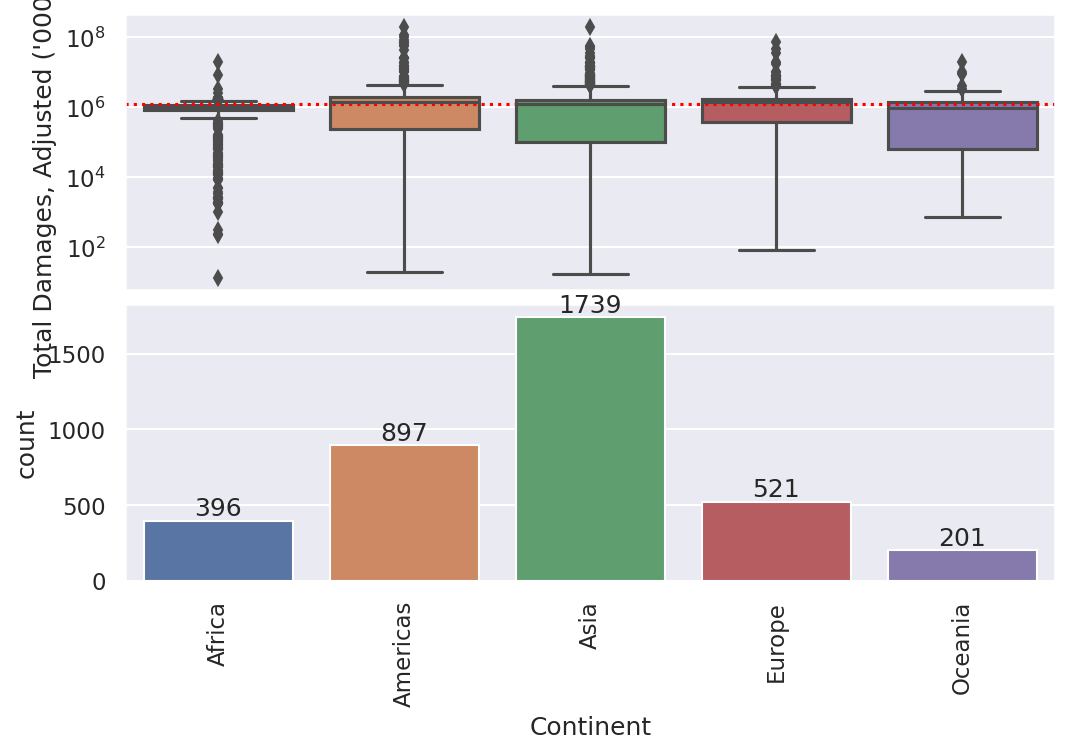

In [ ]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Continent',
    y= "Total Damages, Adjusted ('000 US$)",
    data=train.sort_values('Continent'),
    ax=axs[0]
)
# logarithmic scale to get a clearer visualization
axs[0].set_yscale('log')

sns.countplot(
    x='Continent',
    data=train.sort_values('Continent'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=train["Total Damages, Adjusted ('000 US$)"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.05)

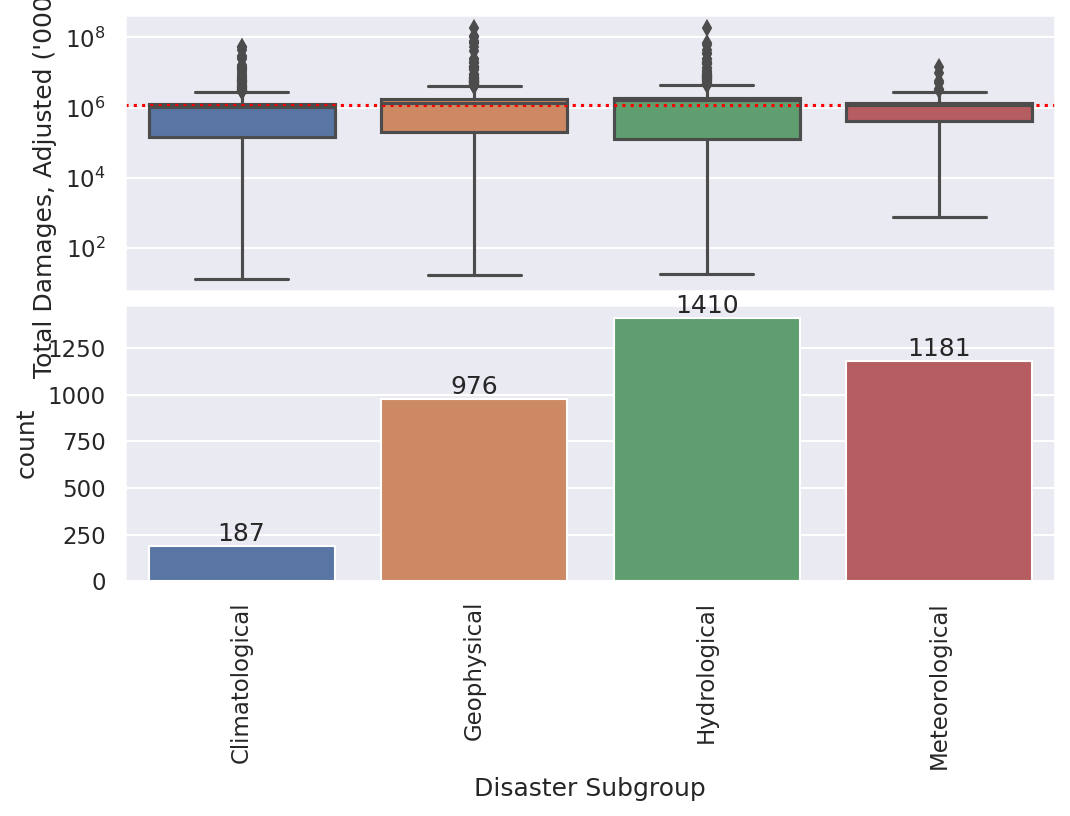

In [ ]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Disaster Subgroup',
    y= "Total Damages, Adjusted ('000 US$)",
    data=train.sort_values('Continent'),
    ax=axs[0]
)
axs[0].set_yscale('log')

sns.countplot(
    x='Disaster Subgroup',
    data=train.sort_values('Disaster Subgroup'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=train["Total Damages, Adjusted ('000 US$)"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.05)

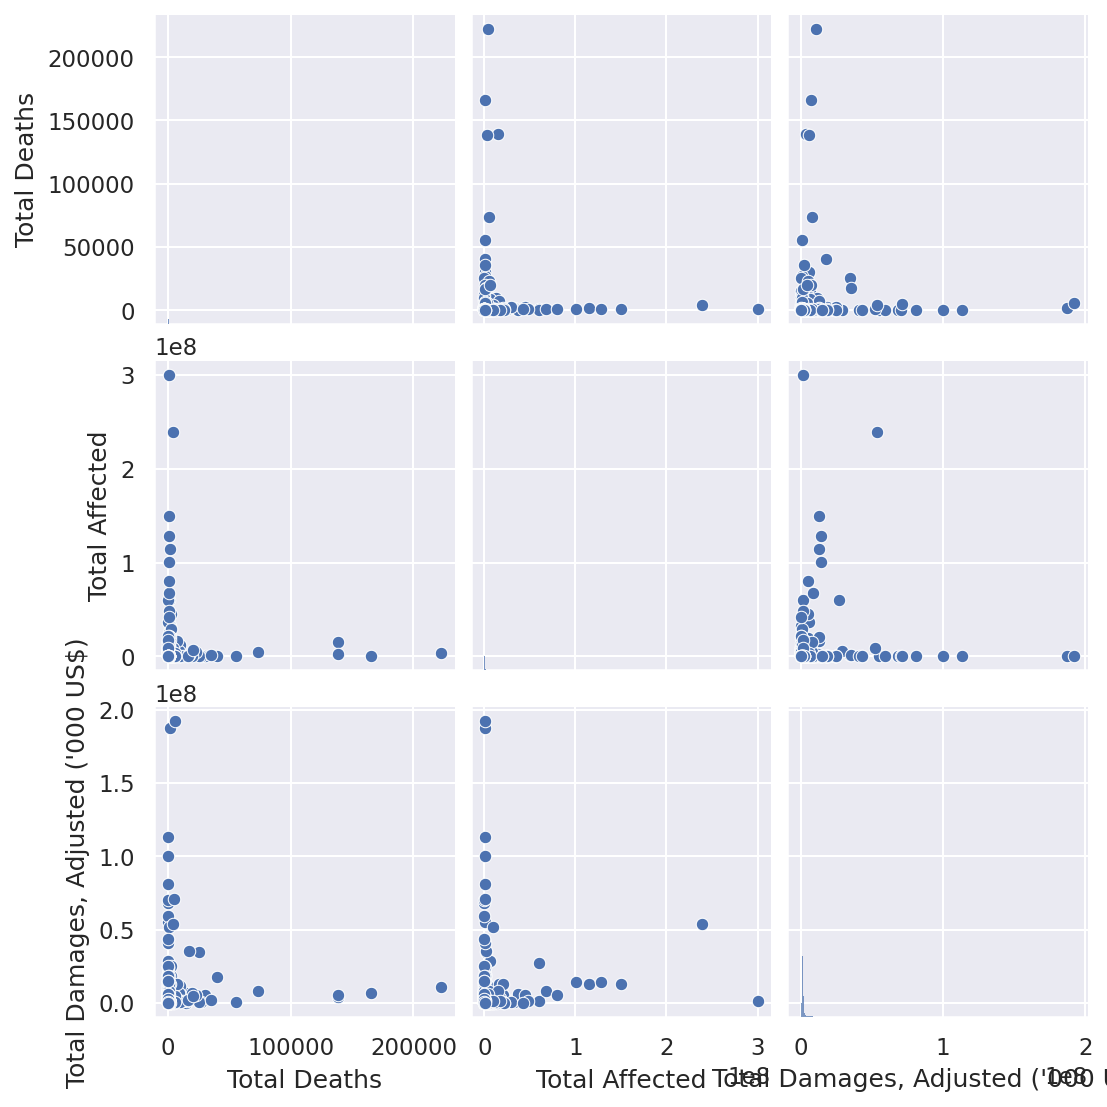

In [ ]:
temp = train[['Total Deaths', 'Total Affected', "Total Damages, Adjusted ('000 US$)"]]
sns.pairplot(temp)

Rhe visualized relationships show most of the featuress that were decided to be included in the linear regression models. It is visible that these features have somewhat linear relationships with the Total damages feature.

**One hot encoding of features**

In [ ]:
from pandas.api.types import CategoricalDtype

def ohe_continent(data):
    """
    One-hot-encodes Continent.  New columns are of the form continent_NAME
    """
    continents = full_data['Continent'].unique()
    continent_type = CategoricalDtype(categories=continents)
    data['Continent'] = data['Continent'].astype(continents)
    data = pd.get_dummies(data,
                          prefix='continent',
                          columns=['Continent'], 
                          drop_first=True)
    return data


def ohe_disaster_type(data):
    """
    One-hot-encodes disaster type.  New columns are of the form disaster_TYPE
    """
    disasters = full_data['Disaster Type'].unique()
    disas_type = CategoricalDtype(categories=disasters)
    data['Disaster Type'] = data['Disaster Type'].astype(disas_type)
    data = pd.get_dummies(data,
                          prefix='disaster',
                          columns=['Disaster Type'], 
                          drop_first=True)
    return data


def ohe_country(data):
    """
    One-hot-encodes country.  New columns are of the form country_NAME
    """
    countries = full_data['Country'].unique()
    country_type = CategoricalDtype(categories=countries)
    data['Country'] = data['Country'].astype(country_type)
    data = pd.get_dummies(data,
                          prefix='country',
                          columns=['Country'], 
                          drop_first=True)
    return data


def ohe_dis_mag_scale(data):
    """
    One-hot-encodes Dis Mag Scale.  New columns are of the form dis_mag_scale_NAME
    """
    dismags = full_data['Dis Mag Scale'].unique()
    dismag_type = CategoricalDtype(categories=dismags)
    data['Dis Mag Scale'] = data['Dis Mag Scale'].astype(dismag_type)
    data = pd.get_dummies(data,
                          prefix='dis_mag_scale',
                          columns=['Dis Mag Scale'], 
                          drop_first=True)
    return data

**Model pipeline creation for Worldwide prediction**

In [ ]:
def pipeline_damages(data):
    data = (
        data
        # Transform data
        .pipe(select_columns, 
              "Total Damages, Adjusted ('000 US$)", 
              'Disaster Type', 
              'Country',
              'Continent',
              'Dis Mag Scale', 
              'Year',
              'Start Month',
              'End Month',
              'Dis Mag Value',
              'Total Affected',
              'Total Deaths'
             )
        .pipe(ohe_country)
        .pipe(ohe_continent)
        .pipe(ohe_disaster_type)
        .pipe(ohe_dis_mag_scale)
    )
    
    # Return predictor and response variables separately
    X = data.drop(["Total Damages, Adjusted ('000 US$)"], axis = 1)
    y = data["Total Damages, Adjusted ('000 US$)"]
    
    return X, y

In [ ]:
def pipeline_deaths(data):
    data = (
        data
        # Transform data
        .pipe(select_columns, 
              "Total Damages, Adjusted ('000 US$)", 
              'Disaster Type', 
              'Country',
              'Continent',
              'Dis Mag Scale', 
              'Year',
              'Start Month',
              'End Month',
              'Dis Mag Value',
              'Total Affected',
              'Total Deaths'
             )
        .pipe(ohe_country)
        .pipe(ohe_continent)
        .pipe(ohe_disaster_type)
        .pipe(ohe_dis_mag_scale)
    )
    
    # Return predictor and response variables separately
    X = data.drop(["Total Deaths"], axis = 1)
    y = data["Total Deaths"]
    
    return X, y

In [ ]:
def pipeline_affected(data):
    data = (
        data
        # Transform data
        .pipe(select_columns, 
              "Total Damages, Adjusted ('000 US$)", 
              'Disaster Type', 
              'Country',
              'Continent',
              'Dis Mag Scale', 
              'Year',
              'Start Month',
              'End Month',
              'Dis Mag Value',
              'Total Affected',
              'Total Deaths'
             )
        .pipe(ohe_country)
        .pipe(ohe_continent)
        .pipe(ohe_disaster_type)
        .pipe(ohe_dis_mag_scale)
    )
    
    # Return predictor and response variables separately
    X = data.drop(["Total Affected"], axis = 1)
    y = data["Total Affected"]
    
    return X, y

**Train and test models**

In [ ]:
# DAMAGES
# Process the data
X_train, y_train = pipeline_damages(train)
X_test, y_test = pipeline_damages(test)


# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(max_iter=2000, alphas=alphas, cv=5)

# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(final_model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=200.0 is 9627806.17.


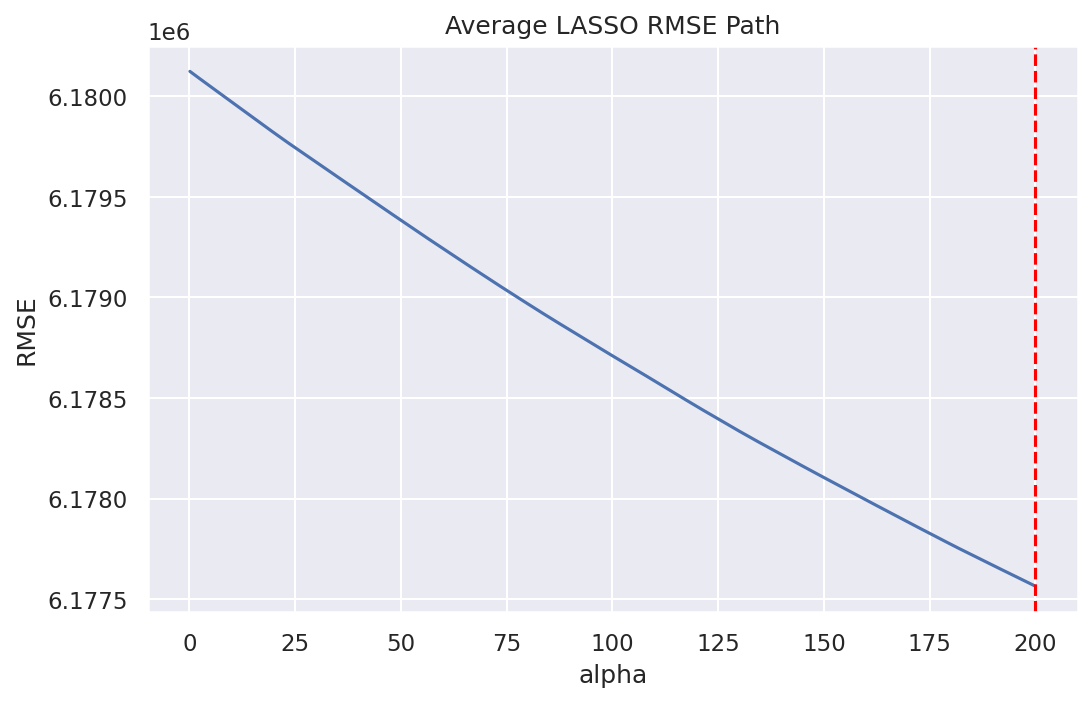

In [ ]:
plot_training_path(final_model)

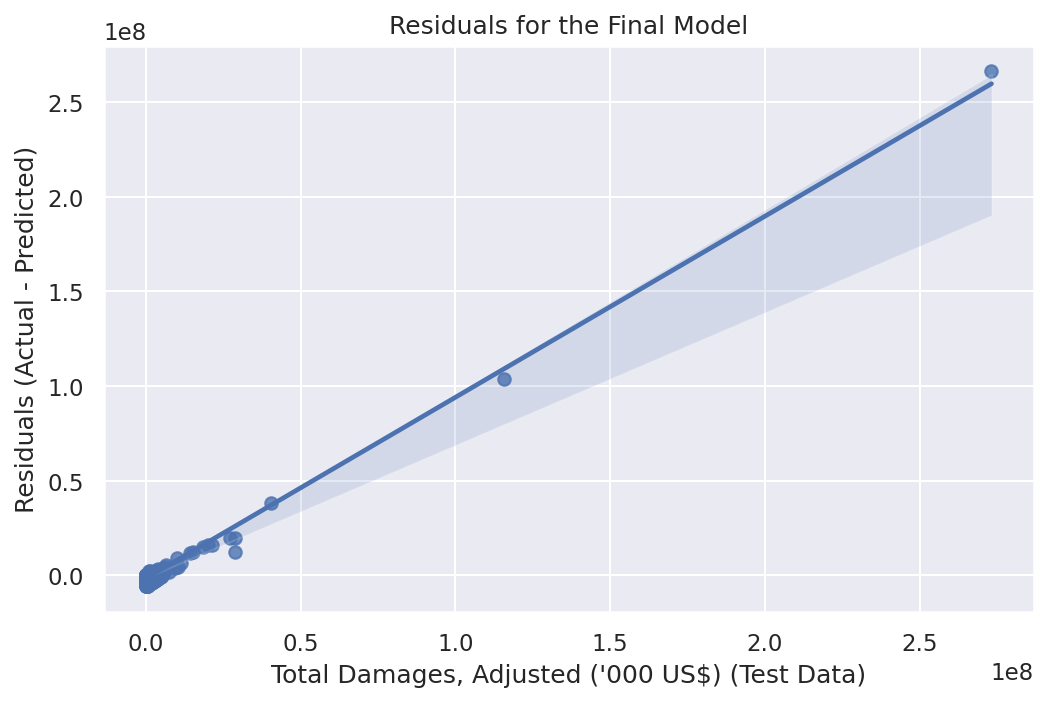

In [ ]:
plot_residuals(y_test, y_predicted, "Total Damages, Adjusted ('000 US$)")

In [ ]:
# DEATHS
# Process the data
X_train, y_train = pipeline_deaths(train)
X_test, y_test = pipeline_deaths(test)


# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(max_iter=2000, alphas=alphas, cv=5)

# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(final_model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=71.0 is 8569.57.


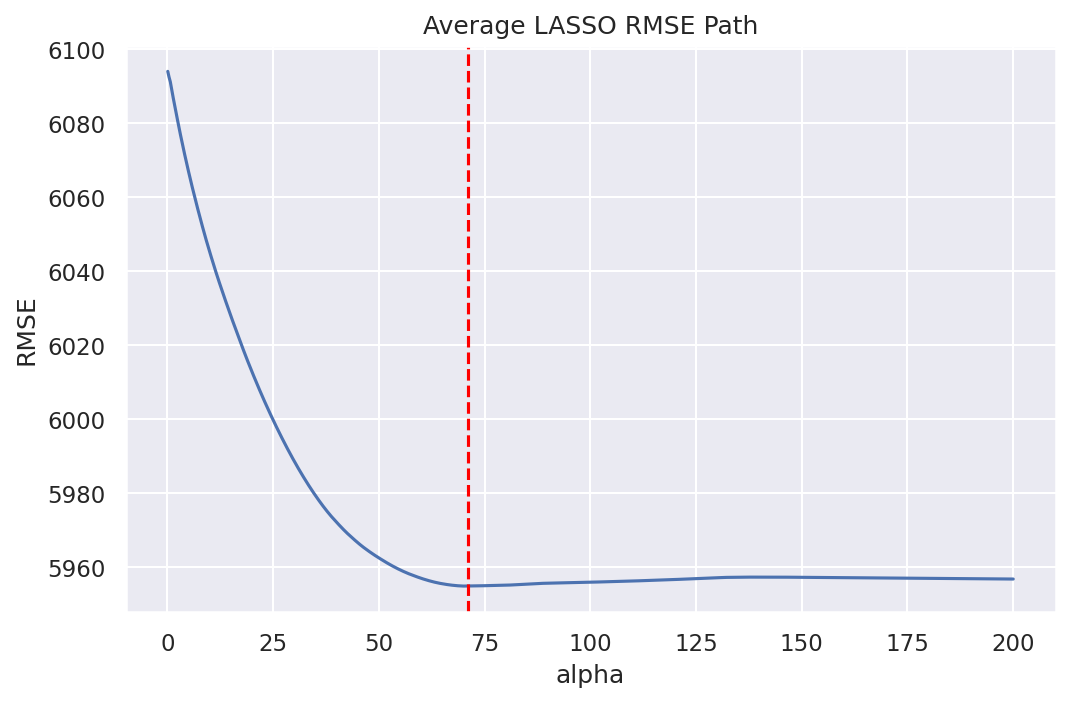

In [ ]:
plot_training_path(final_model)

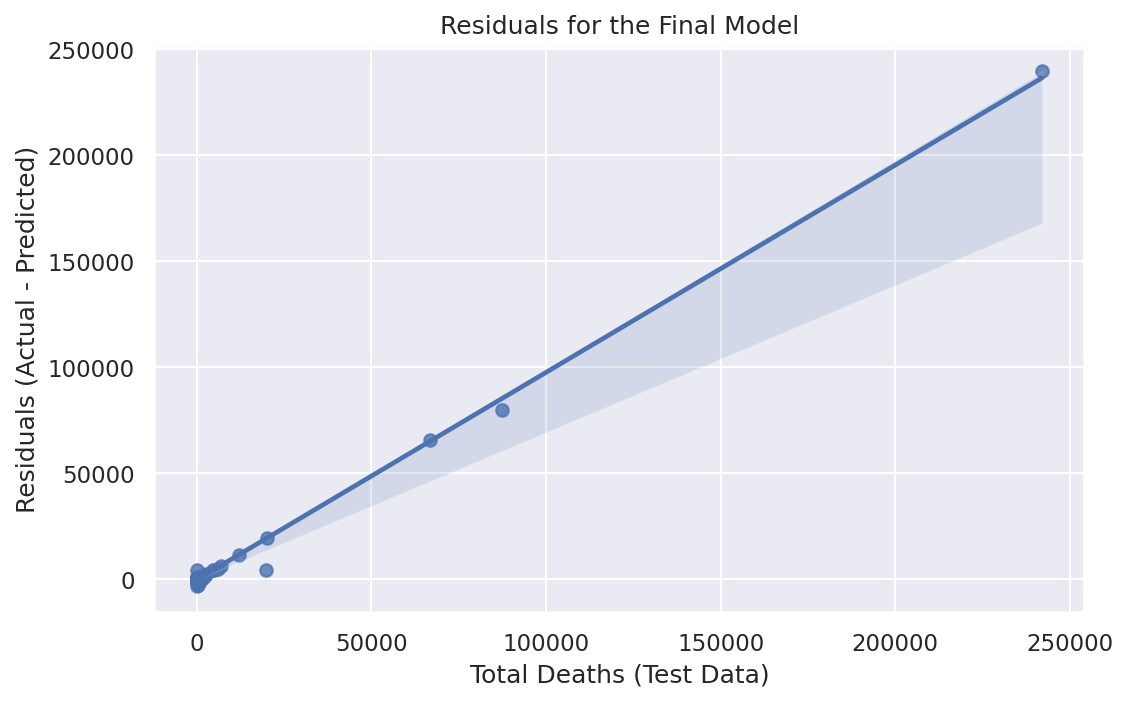

In [ ]:
plot_residuals(y_test, y_predicted, 'Total Deaths')

In [ ]:
# AFFECTED
# Process the data
X_train, y_train = pipeline_affected(train)
X_test, y_test = pipeline_affected(test)


# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(max_iter=2000, alphas=alphas, cv=5)

# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(final_model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=200.0 is 5587650.69.


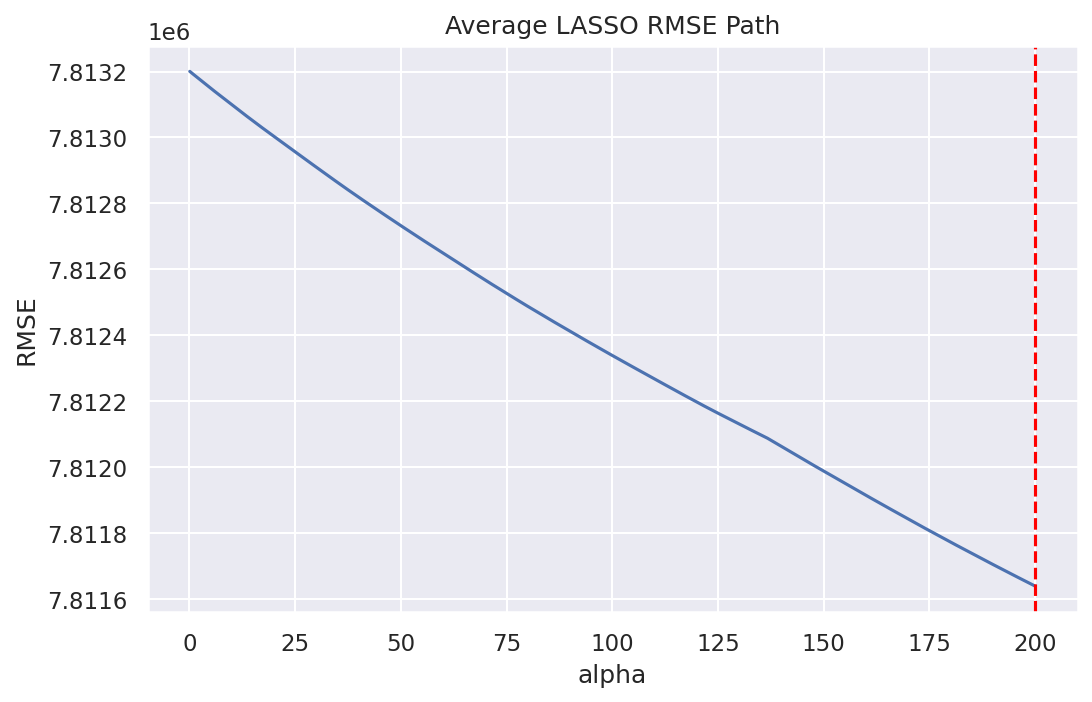

In [ ]:
plot_training_path(final_model)

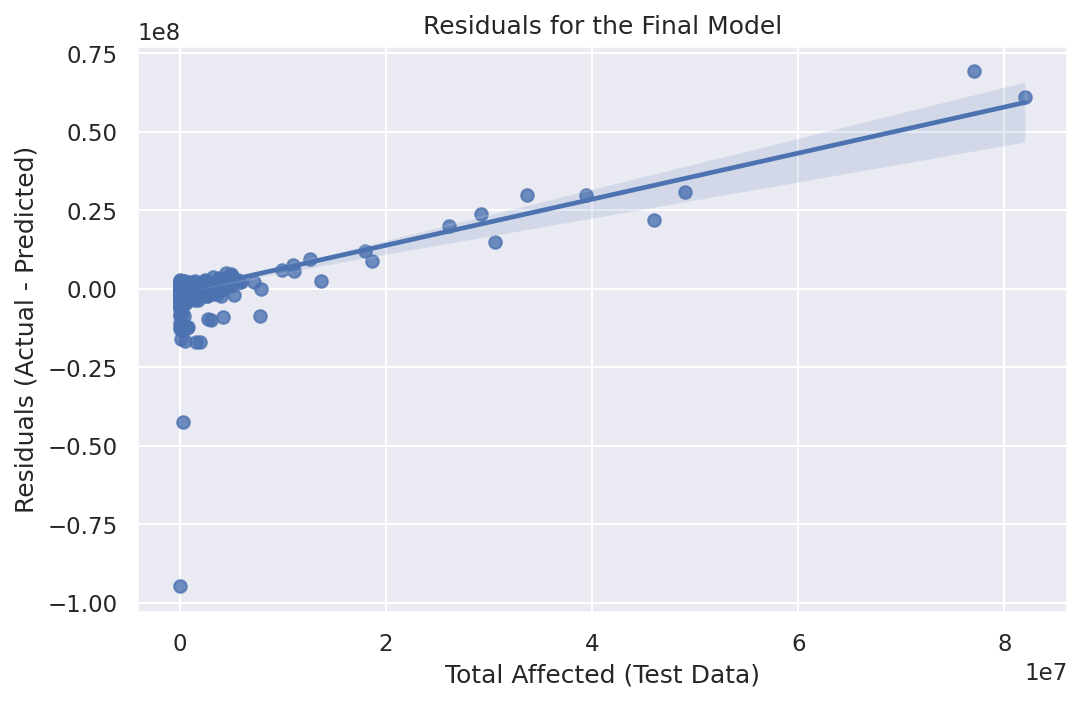

In [ ]:
plot_residuals(y_test, y_predicted, 'Total Affected')

**Predictions for Indonesia**

In [ ]:
train_ind, test_ind = train_test_country(full_data, 'Indonesia')
print('train:', train_ind.shape)
print('test:', test_ind.shape)

train: (170, 26)
test: (43, 26)


In [ ]:
def pipeline_damages_ind(data):
    data = (
        data
        # Transform data
        .pipe(select_columns, 
              "Total Damages, Adjusted ('000 US$)", 
              'Disaster Type', 
              'Dis Mag Scale', 
              'Year',
              'Start Month',
              'End Month',
              'Dis Mag Value',
              'Total Affected',
              'Total Deaths'
             )
        .pipe(ohe_disaster_type)
        .pipe(ohe_dis_mag_scale)
    )
    
    # Return predictor and response variables separately
    X = data.drop(["Total Damages, Adjusted ('000 US$)"], axis = 1)
    y = data["Total Damages, Adjusted ('000 US$)"]
    
    return X, y


def pipeline_deaths_ind(data):
    data = (
        data
        # Transform data
        .pipe(select_columns, 
              "Total Damages, Adjusted ('000 US$)", 
              'Disaster Type', 
              'Dis Mag Scale', 
              'Year',
              'Start Month',
              'End Month',
              'Dis Mag Value',
              'Total Affected',
              'Total Deaths'
             )
        .pipe(ohe_disaster_type)
        .pipe(ohe_dis_mag_scale)
    )
    
    # Return predictor and response variables separately
    X = data.drop(["Total Deaths"], axis = 1)
    y = data["Total Deaths"]
    
    return X, y


def pipeline_affected_ind(data):
    data = (
        data
        # Transform data
        .pipe(select_columns, 
              "Total Damages, Adjusted ('000 US$)", 
              'Disaster Type', 
              'Dis Mag Scale', 
              'Year',
              'Start Month',
              'End Month',
              'Dis Mag Value',
              'Total Affected',
              'Total Deaths'
             )
        .pipe(ohe_disaster_type)
        .pipe(ohe_dis_mag_scale)
    )

    # Return predictor and response variables separately
    X = data.drop(['Total Affected'], axis = 1)
    y = data['Total Affected']
    
    return X, y

In [ ]:
# DAMAGES
# Process the data
X_train, y_train = pipeline_damages_ind(train_ind)
X_test, y_test = pipeline_damages_ind(test_ind)


# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(max_iter=2000, alphas=alphas, cv=5)

# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(final_model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=0.1 is 1024210.36.


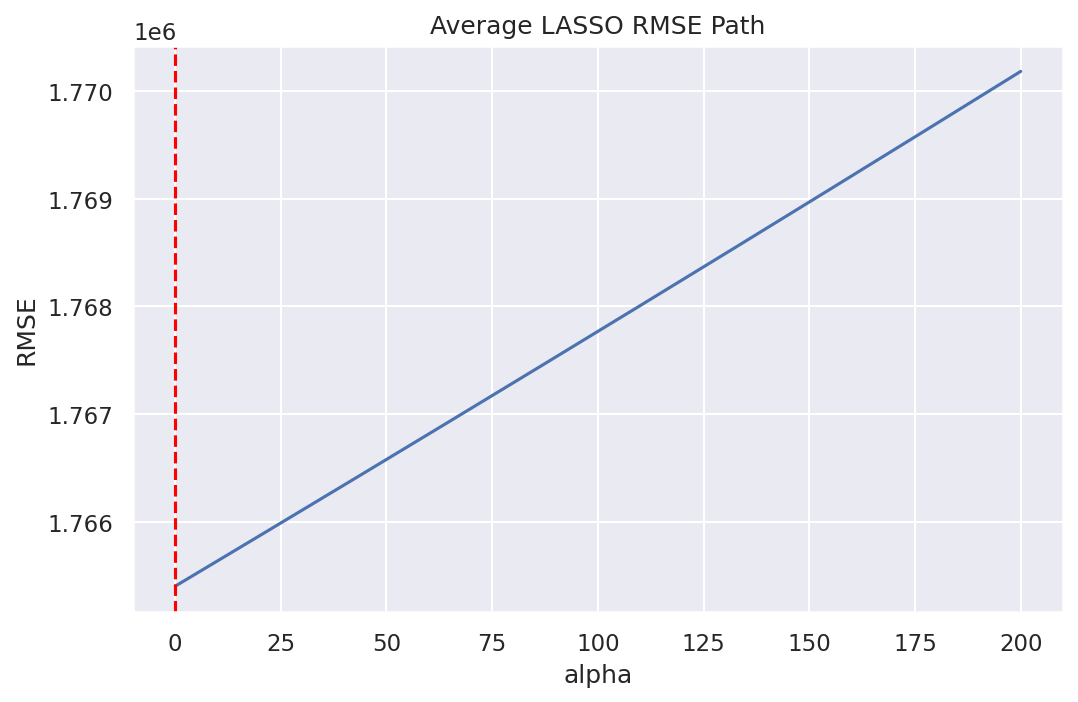

In [ ]:
plot_training_path(final_model)

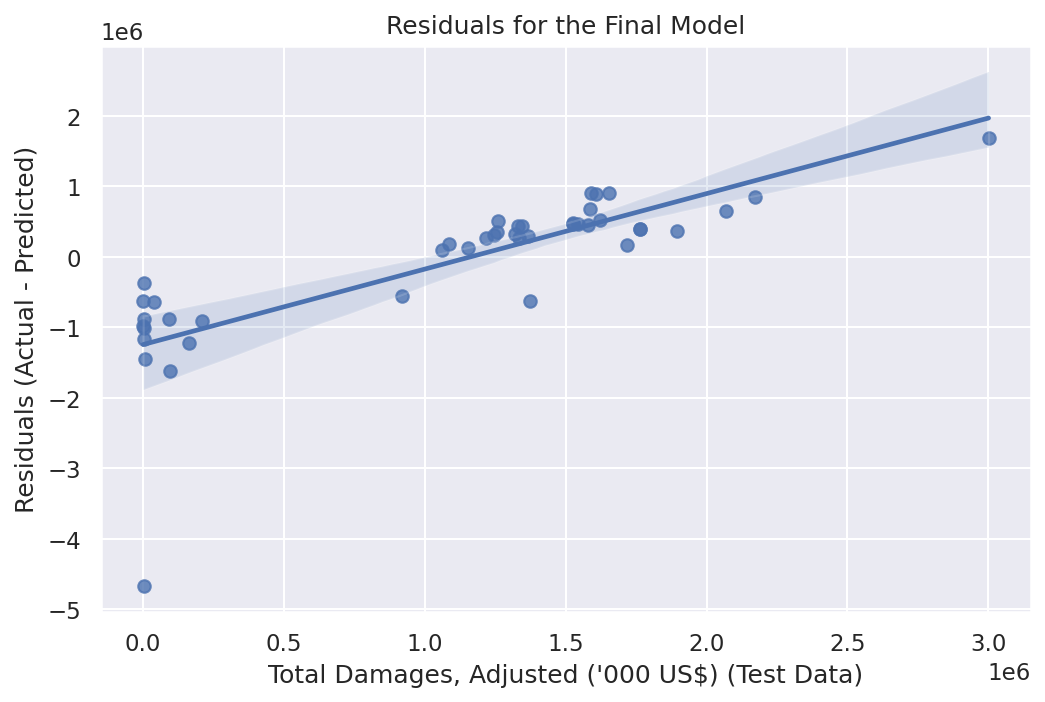

In [ ]:
plot_residuals(y_test, y_predicted, "Total Damages, Adjusted ('000 US$)")

In [ ]:
# DEATHS
# Process the data
X_train, y_train = pipeline_deaths_ind(train_ind)
X_test, y_test = pipeline_deaths_ind(test_ind)


# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(max_iter=2000, alphas=alphas, cv=5)

# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(final_model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=200.0 is 2782.22.


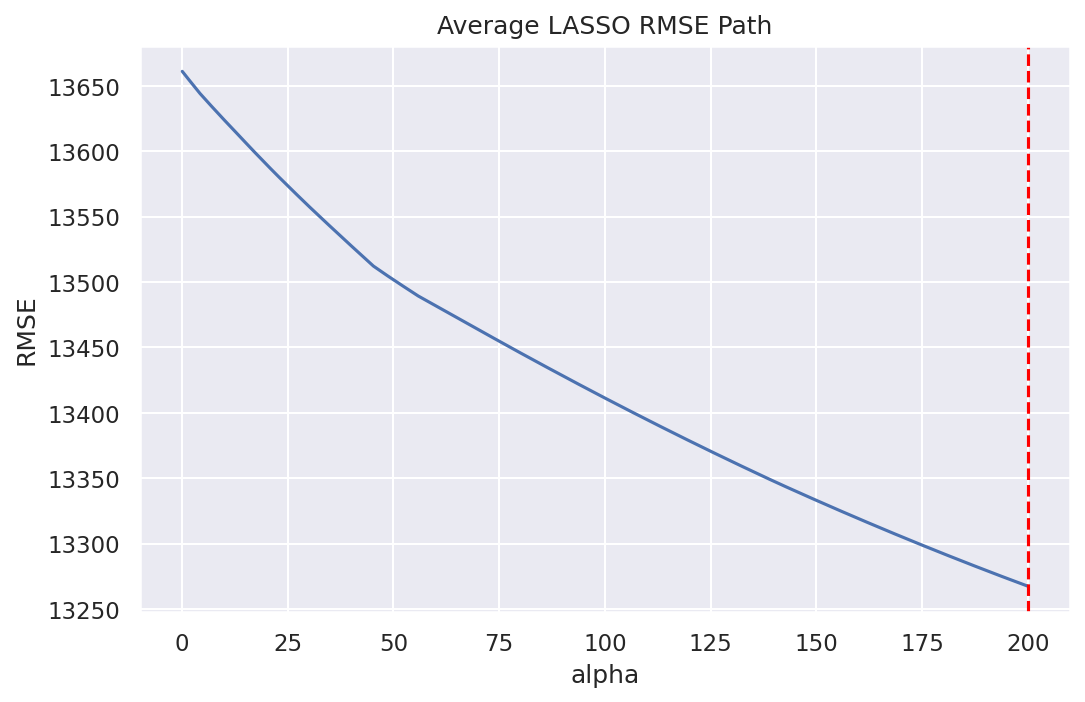

In [ ]:
plot_training_path(final_model)

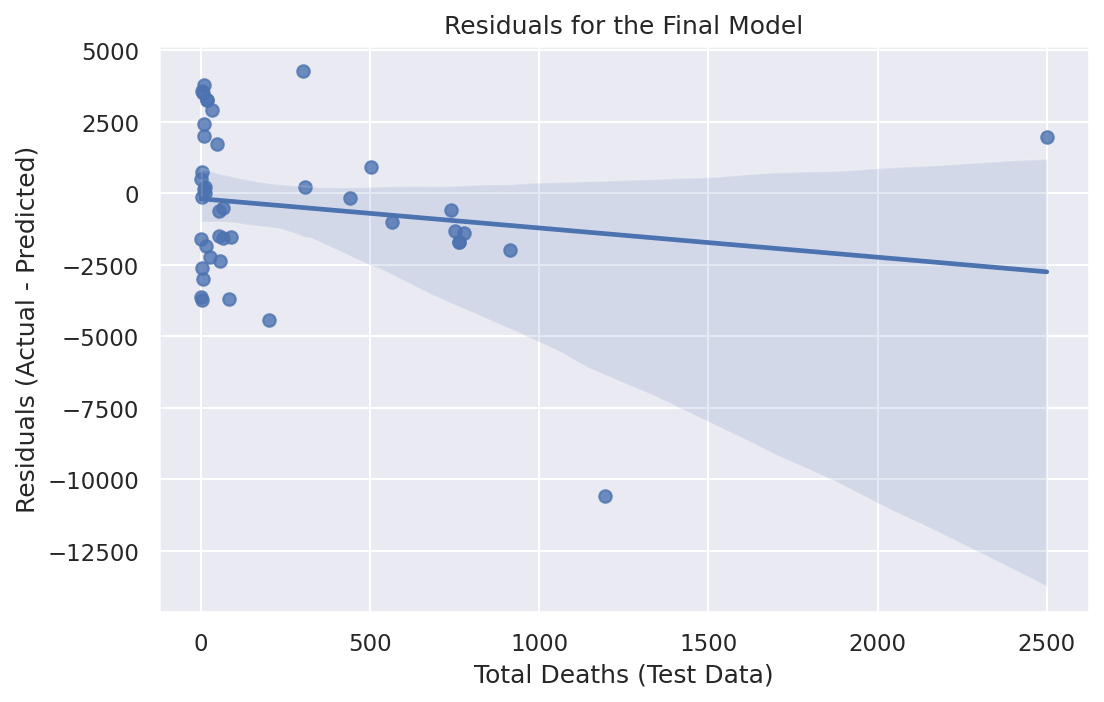

In [ ]:
plot_residuals(y_test, y_predicted, "Total Deaths")

In [ ]:
# AFFECTED
# Process the data
X_train, y_train = pipeline_affected_ind(train_ind)
X_test, y_test = pipeline_affected_ind(test_ind)


# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(max_iter=2000, alphas=alphas, cv=5)

# Fit and predict
final_model.fit(X_train, y_train)
y_predicted = final_model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(final_model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

The validation RMSE for this model with alpha=200.0 is 391006.28.


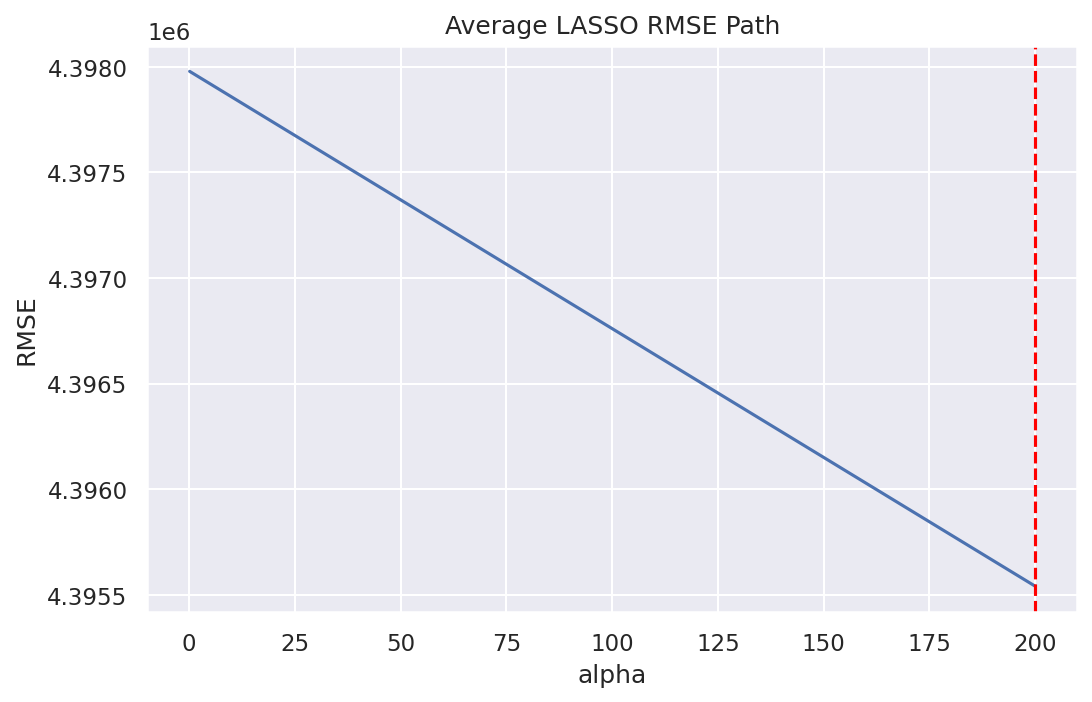

In [ ]:
plot_training_path(final_model)

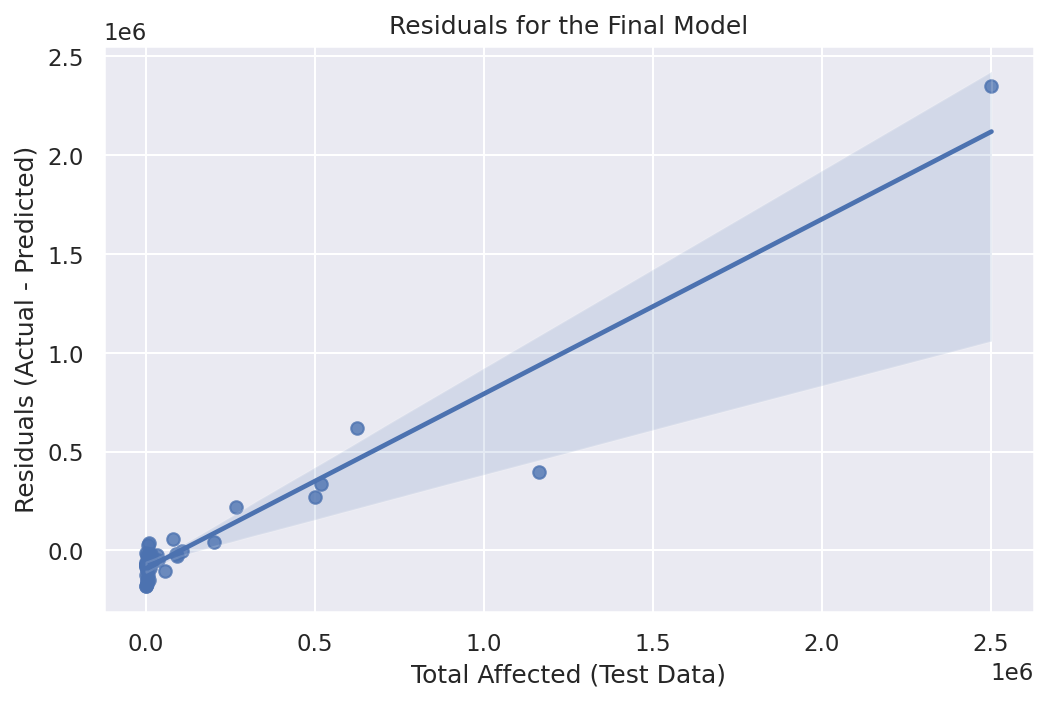

In [ ]:
plot_residuals(y_test, y_predicted, "Total Affected")

## ETHICAL CONSIDERATIONS:

The EM-DAT data (Emergency Events Database) is a globally accessible database that records technological and natural disasters severe enough to meet a set of standard conditions. In our case, we only used the natural disaster data recordings. Since the events record drastic events that have had a big impact on peoples’ lives, some important things should be considered:

- The data is collected by and from many different sources and although it is verified before publication, there may be a big difference in the records, based on what features and how they are recorded, possible resulting in bias. Our handling of missing values could have added to this, since we only included records with certain attributes for the analysis, due to the necessary feature selection.
- While no personal data about individuals is included, the data may still be sensitive and one should be mindful of the trauma and suffering experienced by those involved in the disasters. Thus, the data should not be used for personal gains.
- It is also very important to contextualise the data properly when using it for analysis or research. One should be aware of additional social, political, and economic factors that may have contributed to the events or increased its impact, such as more deaths in areas where housing is less safe, or larger recorded monetary damages in richer countries, since these are more prone to report the events and possessions may be valued at higher prices. 

At this point we also want to mention some limitations of our analysis and possible sources of bias. 
- Future predictions may be very difficult, since for many natural disasters geographical data is also very important to generate trustworthy predictions. General predictions about the trends and severity of disasters seem to be plausible.
- The historical data may be different, since measuring severity or impact of disasters might have been handled differently or done with inferior instrumentation than it was in recent years.
- Since the data was recorded from many different sources, inaccuracies or differences in records based on the recording location can occur, possibly introducing bias. Similarity, this bias can also be introduced due to underreporting of disasters in certain regions or overreporting of certain types of disasters.
- Lastly, one needs to consider that decisions made in the analysis process can also introduce bias, such as the feature selection for the predictive models, or the handling of missing values.

In summary, when working with this data set, one should be sensitive to the datas’ origin and the manner in which it will be used, while remembering the context and also acknowledging and addressing the bias. It is however very important to do this analysis (even with the current bias), since this can help communities endangered by natural disasters.

## **CONCLUSION**

After our analysis, we will have another look at our initially fromulated research questions:

1) How has the frequency and severity of natural disasters changed over time?
It could be seen that the disaster frequency and their impact had increased over time (since 1960). However, the frequency had also dropped again very slightly after 2010. This was observable worldwide as well as on the country we inspected more closely in this dataset, representative for one of the countries affected the most: Indonesia. Of course the trend is expected to vary on different countries.

2) Can we predict the economic impact and physical damage of natural disasters in the coming years?
The prediction task was executed using different methods: Facebook Prophet, SARIMAX, and linear regression. Furthermore, we attempted doing this for worldwide data, as well as for Indonesia. After examining the MSE for the different methods, we can see that the accuracy of predictions varies greatly for the different methods and features. For TS we used Mean absolute error for evaluation. Itshould be noted that the error varies greatly between the features due to the scale of the examined values. Here, for predicting the data of one country, the SARIMAX model outperformed the Facebook prophet for all features. For the worldwide predictions on the other hand, the Prophet model had a better prediction for the features "Count" (total occurences) and total damages.
For the linear regression model, we compared the errors to the other model after taking the squareroot, and in doing so we could see that the errors for this model were much lower for the estimated affected, deaths and damages. This is very likely due to the fact that in this model we were able to include more features that can be used for the prediction.
Hence, if we use a TS model for prediction, it would depend on what feature we want to predict, which one would be better to use, otherwise, a regression modle would be preferable.


3) Which countries have been affected the most in the past years?
Comparing the different countries on the fours selected features: 
- Total damages
- Total Affected
- Total Deaths, and 
- Event occurence

we were able to see that overall, the USA, China, and India were the countries that were most affected. While this varied slightly for the different features. It seems logical that the countries that were most affected according to the records were those with population rates. When only analyzing this for one year, we would recommend normalizing the numbers by population of the countries. In our analysis however we did not want to do so beacuse the population of countries changed over the monitored years.


4) How does the occurce of the disaster types differ in the world or a specific countries?
Overall, flood, storms and droughts were most recorded over all years. This could however also be becuase these cause the most damage. It would however be very recommendable to guard against these three types most of all. This of course can differ in specific countries or locations, but overall we expect at  least one of these to also be very damaging in individual countries (as could also be seen in Indonesia).